# Imports

In [11]:
import os
import re
import shutil
from skimage import io
from PIL import Image

from torchvision import transforms
from torch.utils.data import DataLoader
from skimage import io
import torch
import glob
import torch
from torch import nn
from torchvision import models
from torch.optim import Adam
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, Dataset
import random
import torchvision
from torchvision import datasets, models, transforms

from itertools import cycle

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import auc
import copy

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

import glob
# import staintools
from PIL import ImageOps

# Create dataset

In [12]:
class BiopsyDataset100(torch.utils.data.Dataset):
    def __init__(self, root_dir, df, label, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.df = df
        self.image_filenames = []
        self.labels = []
        self.label = label
                
        image_dict = {}
        for image_filename in glob.glob(os.path.join(self.root_dir, '*.jpeg')):
            ID_number = image_filename.split('/')[-1].split('.tif')[0]  # Assuming your filenames are like SCAN1_01.jpg, SCAN1_02.jpg
            if ID_number in df.ID_number.tolist():
                if ID_number not in image_dict:
                    image_dict[ID_number] = []
                image_dict[ID_number].append(image_filename)

        random.seed(42)
        for ID_number, filenames in image_dict.items():
            chosen_filenames = random.sample(filenames, min(100, len(filenames)))
            for filename in chosen_filenames:
                self.image_filenames.append(filename)
                self.labels.append(df[df['ID_number'] == ID_number][self.label].values[0])

                
    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        image = io.imread(self.image_filenames[idx])
        if self.transform:
            image = self.transform(image)
        label = self.labels[idx]
        return image, label
    
    
    def get_labels(self):
        return self.labels


In [13]:
# Define transformations
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(128),
    transforms.ToTensor(),
])

# Create necessary functions

In [14]:
def get_dataset_continous(label, seed):
    df = pd.read_excel('data_file.xlsx')
    df = df[['ID_number', label]]
    df[label] = pd.to_numeric(df[label], errors='coerce')
    df = df.dropna(subset=[label])

    q33 = df[label].quantile(0.33)
    q66 = df[label].quantile(0.66)

    df_new = df.copy()

    bin_edges = [-float('inf'), q33, q66, float('inf')]
    bin_labels = ['A', 'B', 'C']

    df_new[label] = pd.cut(df_new[label], bins=bin_edges, labels=bin_labels, include_lowest=True)

    # Now sample the 5 images for each label
    np.random.seed(seed)
    sampled_df = df_new.groupby(label).apply(lambda x: x.sample(n=5)).reset_index(drop=True)
    return sampled_df

In [15]:
def get_dataset_pos_neg(label, seed):
    df = pd.read_excel('data_file.xlsx')
    df = df[['ID_number', label]]
    df = df.dropna(subset=[label])

    df_new = df.copy()
    df_new.loc[df_new[label] == 'Negative', label] = 0
    df_new.loc[df_new[label] == 'Positive', label] = 1
    
    np.random.seed(seed)
    sampled_df = df_new.groupby(label).apply(lambda x: x.sample(n=5)).reset_index(drop=True)
    return sampled_df

In [16]:
def get_dataset_PAM50(label, seed):
    df = pd.read_excel('data_file.xlsx')
    df = df[df["timepoint"] != "SCR"]
    df = df[['ID_number', 'timepoint', label]]
    df = df.dropna(subset=[label])
    df_new = df.copy()
    
    df_new = df_new[(df_new[label] == "LumA") | (df_new[label] == "LumB")]
    df_new.loc[df_new[label] == 'LumA', label] = 'A'
    df_new.loc[df_new[label] == 'LumB', label] = 'B'
    
    np.random.seed(seed)
    sampled_df = df_new.groupby(label).apply(lambda x: x.sample(n=5)).reset_index(drop=True)
    sampled_df = sampled_df[['ID_number', label]]
    return sampled_df

In [17]:
def get_dataset_ROR(label, seed):
    df = pd.read_excel('data_file.xlsx')
    df = df[['ID_number', label]]
    df = df.dropna(subset=[label])

    df_new = df.copy()
    df_new.loc[df_new[label] == 'low', label] = 0
    df_new.loc[df_new[label] == 'med', label] = 1
    df_new.loc[df_new[label] == 'high', label] = 2
    np.random.seed(seed)
    sampled_df = df_new.groupby(label).apply(lambda x: x.sample(n=5)).reset_index(drop=True)
    return sampled_df

# Binning evaluation

In [18]:
# We first create an array that contains all the encoded images from the dataset: 
# And an array for all the labels:

def create_encoded_arr(dataset, encoder):
    
    encoded_arr = []
    labels = []
    
    for i in range(len(dataset)):
        image = dataset[i][0]
        label = dataset[i][1]
        
        encoded_arr.append(encoder(image))
        labels.append(label)
#     print(encoded_arr[0].shape)
    return encoded_arr, labels

In [19]:
# now we want to calculate the mus : 

def mean_calc(encoded_arr, labels):
    
    values = [[] for _ in range(len(labels))]
    dic_mus = dict(zip(np.unique(labels),values))
    dic_mean_final = copy.deepcopy(dic_mus)
    
    for i in range(len(encoded_arr)):
        dic_mus[labels[i]].append(encoded_arr[i].detach().cpu().numpy())
#         dic_mus[labels[i]].append(encoded_arr[i])
    
    for key in dic_mean_final.keys():
        dic_mean_final[key] = np.mean(dic_mus[key], axis=0)

    return dic_mean_final

In [20]:
def euclidean_distance(x, y):
    return np.sqrt(np.sum((x - y)**2))

In [21]:
def J_C_calc(encoded_arr, labels):
    
    C = len(encoded_arr)
    mean_dic = mean_calc(encoded_arr, labels)
    
    total_sum = 0
    
    for i in range(len(encoded_arr)):
        total_sum += euclidean_distance(encoded_arr[i].detach().cpu().numpy(), mean_dic[labels[i]])
        
    J_C = (1/C) * total_sum 
    return J_C

In [22]:
def binning_eval(dataset, sampled_df, encoder, title):
    
    encoded_arr, labels = create_encoded_arr(dataset, encoder)
    print(encoded_arr[0].shape)
    
#     all_pixels = np.vstack([img.detach().cpu().numpy() for img in encoded_arr])
    all_pixels = np.vstack(encoded_arr)
    global_mean = np.mean(all_pixels)
    global_std = np.std(all_pixels)
    standardized_images = [(img - global_mean) / global_std for img in encoded_arr]
    
    J_C = J_C_calc(standardized_images, labels)
    hist = [] 


    for i in range(100):
        random.seed(i)
        shuffled_labels = sampled_df[label].tolist()
        random.shuffle(shuffled_labels)
        sampled_df[label] = shuffled_labels
        dataset = BiopsyDataset100("/storage/Chloe/zoom_20_512", sampled_df, label, transform=transform)
        labels = dataset.get_labels()
        hist.append(J_C_calc(standardized_images, labels))

    
    print("J_C: ", J_C)
    print("mean hist: ", np.mean(hist))
    
    print(np.mean(hist) - J_C)
    distance = np.mean(hist) - J_C
    mean = np.mean(hist)
    
    higher_values = [value for value in hist if value > J_C]

    # Calculate percentage
    percentage = (len(higher_values) / len(hist)) * 100
    
    plt.hist(hist, bins=10, label=('J_random_labeling'))
    plt.axvline(x=J_C, color='r', linestyle='--', label='J(C)')
    plt.title(title)

    plt.legend()
    plt.show()
    
    return distance, mean, percentage

In [23]:
column_names = ["Label", "Encoder", "Distance", "Mean of distribution", "Percentage"]
df_results = pd.DataFrame(columns=column_names)

In [14]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
        )

        self.decoder = nn.Sequential(   
        )
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [15]:
autoencoder = Autoencoder()

In [16]:
encoder = autoencoder.encoder

In [17]:
encoder

Sequential()

In [18]:
label = 'Ki67 (%)'
for i in range(10):
    sampled_df = get_dataset_continous(label, i)
    print(sampled_df)
    dataset = BiopsyDataset100("/storage/Chloe/zoom_20_512", sampled_df, label, transform=transform)
    distance, mean, percentage = binning_eval(dataset, sampled_df, encoder, label)
    new_row = {'Label': label, 'Encoder': 'No encoder', 'Distance': distance, 'Mean of distribution': mean, "Percentage": percentage}
    df_results = df_results.append(new_row, ignore_index=True)

    ID_number Ki67 (%)
0   SCAN_0250        A
1   SCAN_0306        A
2   SCAN_0294        A
3   SCAN_0282        A
4   SCAN_0276        A
5   SCAN_0087        B
6   SCAN_0279        B
7   SCAN_0138        B
8   SCAN_0466        B
9   SCAN_0079        B
10  SCAN_0082        C
11  SCAN_0066        C
12  SCAN_0133        C
13  SCAN_0321        C
14  SCAN_0209        C
torch.Size([3, 128, 128])


KeyboardInterrupt: 

In [ ]:
label = 'TILS (%)'
for i in range(10):
    sampled_df = get_dataset_continous(label, i)
    print(sampled_df)
    dataset = BiopsyDataset100("/storage/Chloe/zoom_20_512", sampled_df, label, transform=transform)
    distance, mean, percentage = binning_eval(dataset, sampled_df, encoder, label)
    new_row = {'Label': label, 'Encoder': 'No encoder', 'Distance': distance, 'Mean of distribution': mean, "Percentage": percentage}
    df_results = df_results.append(new_row, ignore_index=True)

In [ ]:
label = 'MYC'
for i in range(10):
    sampled_df = get_dataset_continous(label, i)
    print(sampled_df)
    dataset = BiopsyDataset100("/storage/Chloe/zoom_20_512", sampled_df, label, transform=transform)
    distance, mean, percentage = binning_eval(dataset, sampled_df, encoder, label)
    new_row = {'Label': label, 'Encoder': 'No encoder', 'Distance': distance, 'Mean of distribution': mean, "Percentage": percentage}
    df_results = df_results.append(new_row, ignore_index=True)

In [ ]:
label = 'FOXA1'
for i in range(10):
    sampled_df = get_dataset_continous(label, i)
    print(sampled_df)
    dataset = BiopsyDataset100("/storage/Chloe/zoom_20_512", sampled_df, label, transform=transform)
    distance, mean, percentage = binning_eval(dataset, sampled_df, encoder, label)
    new_row = {'Label': label, 'Encoder': 'No encoder', 'Distance': distance, 'Mean of distribution': mean, "Percentage": percentage}
    df_results = df_results.append(new_row, ignore_index=True)

In [ ]:
label = 'HIF1A'
for i in range(10):
    sampled_df = get_dataset_continous(label, i)
    print(sampled_df)
    dataset = BiopsyDataset100("/storage/Chloe/zoom_20_512", sampled_df, label, transform=transform)
    distance, mean, percentage = binning_eval(dataset, sampled_df, encoder, label)
    new_row = {'Label': label, 'Encoder': 'No encoder', 'Distance': distance, 'Mean of distribution': mean, "Percentage": percentage}
    df_results = df_results.append(new_row, ignore_index=True)
    

In [ ]:
label = 'ROR.S.Group..Subtype.Only.'
for i in range(10):
    sampled_df = get_dataset_ROR(label, i)
    print(sampled_df)
    dataset = BiopsyDataset100("/storage/Chloe/zoom_20_512", sampled_df, label, transform=transform)
    distance, mean, percentage = binning_eval(dataset, sampled_df, encoder, label)
    new_row = {'Label': label, 'Encoder': 'No encoder', 'Distance': distance, 'Mean of distribution': mean, "Percentage": percentage}
    df_results = df_results.append(new_row, ignore_index=True)

In [ ]:
label = 'ROR.P.Group..Subtype...Proliferation.'
for i in range(10):
    sampled_df = get_dataset_ROR(label, i)
    print(sampled_df)
    dataset = BiopsyDataset100("/storage/Chloe/zoom_20_512", sampled_df, label, transform=transform)
    distance, mean, percentage = binning_eval(dataset, sampled_df, encoder, label)
    new_row = {'Label': label, 'Encoder': 'No encoder', 'Distance': distance, 'Mean of distribution': mean, "Percentage": percentage}
    df_results = df_results.append(new_row, ignore_index=True)

In [ ]:
label = 'PR status'
for i in range(10):
    sampled_df = get_dataset_pos_neg(label, i)
    print(sampled_df)
    dataset = BiopsyDataset100("/storage/Chloe/zoom_20_512", sampled_df, label, transform=transform)
    distance, mean, percentage = binning_eval(dataset, sampled_df, encoder, label)
    new_row = {'Label': label, 'Encoder': 'No encoder', 'Distance': distance, 'Mean of distribution': mean, "Percentage": percentage}
    df_results = df_results.append(new_row, ignore_index=True)
    

In [ ]:
label = 'PAM50 subtype'
for i in range(10):
    sampled_df = get_dataset_PAM50(label, i)
    print(sampled_df)
    dataset = BiopsyDataset100("/storage/Chloe/zoom_20_512", sampled_df, label, transform=transform)
    distance, mean, percentage = binning_eval(dataset, sampled_df, encoder, label)
    new_row = {'Label': label, 'Encoder': 'No encoder', 'Distance': distance, 'Mean of distribution': mean, "Percentage": percentage}
    df_results = df_results.append(new_row, ignore_index=True)
    

In [ ]:
df_results

# Autoencoder

In [38]:
def binning_eval(dataset, sampled_df, encoder, title):
    
    encoded_arr, labels = create_encoded_arr(dataset, encoder)
    print(encoded_arr[0].shape)
    
    all_pixels = np.vstack([img.detach().cpu().numpy() for img in encoded_arr])
    global_mean = np.mean(all_pixels)
    global_std = np.std(all_pixels)
    standardized_images = [(img - global_mean) / global_std for img in encoded_arr]
    
    J_C = J_C_calc(standardized_images, labels)
    hist = [] 


    for i in range(100):
        random.seed(i)
        shuffled_labels = sampled_df[label].tolist()
        random.shuffle(shuffled_labels)
        sampled_df[label] = shuffled_labels
        dataset = BiopsyDataset100("/storage/Chloe/zoom_20_512", sampled_df, label, transform=transform)
        labels = dataset.get_labels()
        hist.append(J_C_calc(standardized_images, labels))

    
    print("J_C: ", J_C)
    print("mean hist: ", np.mean(hist))
    
    print(np.mean(hist) - J_C)
    distance = np.mean(hist) - J_C
    mean = np.mean(hist)
    
    higher_values = [value for value in hist if value > J_C]

    # Calculate percentage
    percentage = (len(higher_values) / len(hist)) * 100
    
#     plt.hist(hist, bins=10, label=('J_random_labeling'))
#     plt.axvline(x=J_C, color='r', linestyle='--', label='J(C)')
#     plt.title(title)

#     plt.legend()
#     plt.show()
    
    plt.figure(figsize=(12, 8))  # Set the figure size

    # # Plot the histogram
    plt.hist(hist, bins=10, label='J_random_labeling', color='royalblue', alpha=0.8)

    # # Add a vertical dashed line
    plt.axvline(x=J_C, color='r', linestyle='--', linewidth=2, label='J(C)')


    plt.xlabel('Inertia', fontsize=22)
    plt.ylabel('Frequency', fontsize=22)

    # Customize tick labels font size
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)

    # # Add legend with larger font size
    plt.legend(fontsize=20)

    # # Display the plot
    plt.show()


    
    return distance, mean, percentage

In [39]:
# import matplotlib.pyplot as plt
# import numpy as np

# # Sample data for testing
# hist = np.random.randint(81, 87, size=100)  # Random data between 81 and 86
# J_C = 85  # Position of the vertical line
# title = "Ki67 (%)"

# # # Create a larger plot
# plt.figure(figsize=(12, 8))  # Set the figure size

# # # Plot the histogram
# plt.hist(hist, bins=np.arange(80.5, 87.5, 1), label='J_random_labeling', color='royalblue', alpha=0.8)

# # # Add a vertical dashed line
# plt.axvline(x=J_C, color='r', linestyle='--', linewidth=2, label='J(C)')


# plt.xlabel('Inertia', fontsize=22)
# plt.ylabel('Frequency', fontsize=22)

# # Customize tick labels font size
# plt.xticks(fontsize=20)
# plt.yticks(fontsize=20)

# # # Add legend with larger font size
# plt.legend(fontsize=20)

# # # Display the plot
# plt.show()


In [25]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid(),    
        )
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [26]:
autoencoder = Autoencoder()

In [28]:
autoencoder.load_state_dict(torch.load('/storage/Chloe/final_model_autoencoder/autoencoder_64*16*16_split41_2.pth', map_location='cpu'))

<All keys matched successfully>

In [29]:
encoder = autoencoder.encoder

In [30]:
encoder

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (3): ReLU()
  (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
)

    ID_number Ki67 (%)
0   SCAN_0250        A
1   SCAN_0306        A
2   SCAN_0294        A
3   SCAN_0282        A
4   SCAN_0276        A
5   SCAN_0087        B
6   SCAN_0279        B
7   SCAN_0138        B
8   SCAN_0466        B
9   SCAN_0079        B
10  SCAN_0082        C
11  SCAN_0066        C
12  SCAN_0133        C
13  SCAN_0321        C
14  SCAN_0209        C
torch.Size([64, 16, 16])
J_C:  84.81894295247396
mean hist:  84.97112243011476
0.1521794776408001


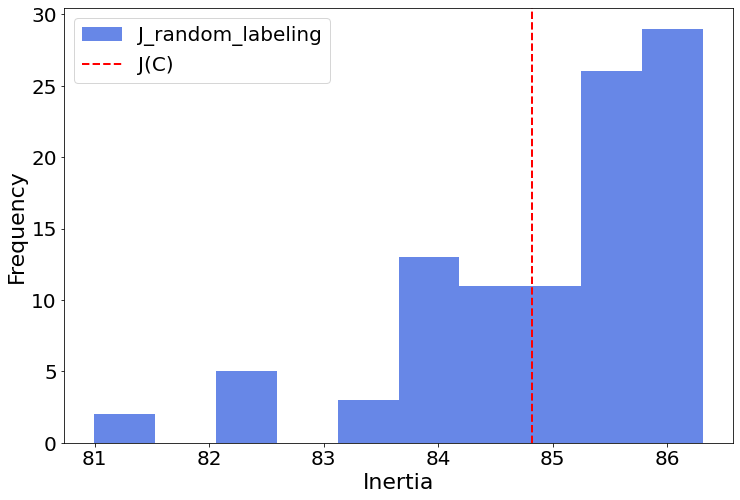

    ID_number Ki67 (%)
0   SCAN_0177        A
1   SCAN_0208        A
2   SCAN_0455        A
3   SCAN_0170        A
4   SCAN_0213        A
5   SCAN_0094        B
6   SCAN_0465        B
7   SCAN_0061        B
8   SCAN_0464        B
9   SCAN_0280        B
10  SCAN_0080        C
11  SCAN_0135        C
12  SCAN_0139        C
13  SCAN_0096        C
14  SCAN_0235        C
torch.Size([64, 16, 16])
J_C:  81.38309818903605
mean hist:  86.93537378592174
5.552275596885693


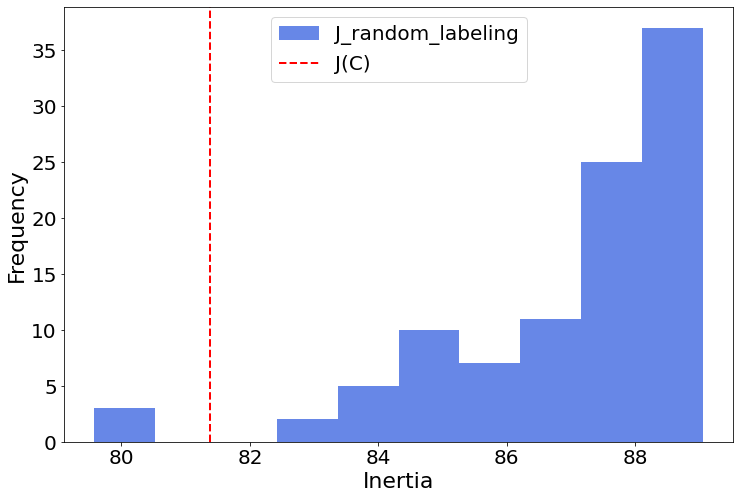

    ID_number Ki67 (%)
0   SCAN_0170        A
1   SCAN_0293        A
2   SCAN_0310        A
3   SCAN_0250        A
4   SCAN_0295        A
5   SCAN_0119        B
6   SCAN_0193        B
7   SCAN_0251        B
8   SCAN_0076        B
9   SCAN_0164        B
10  SCAN_0131        C
11  SCAN_0194        C
12  SCAN_0116        C
13  SCAN_0114        C
14  SCAN_0233        C
torch.Size([64, 16, 16])
J_C:  78.54953434344682
mean hist:  78.50450073807895
-0.04503360536787682


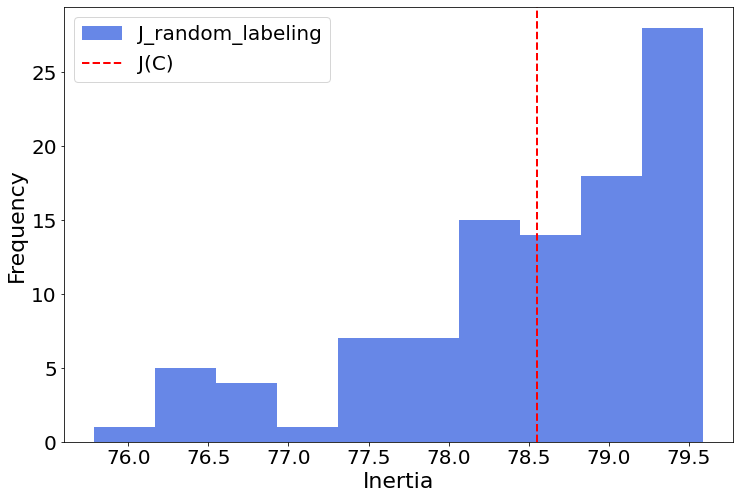

    ID_number Ki67 (%)
0   SCAN_0198        A
1   SCAN_0176        A
2   SCAN_0470        A
3   SCAN_0266        A
4   SCAN_0200        A
5   SCAN_0125        B
6   SCAN_0061        B
7   SCAN_0173        B
8   SCAN_0138        B
9   SCAN_0158        B
10  SCAN_0136        C
11  SCAN_0154        C
12  SCAN_0117        C
13  SCAN_0075        C
14  SCAN_0134        C
torch.Size([64, 16, 16])
J_C:  79.90433823267618
mean hist:  85.02768865503946
5.1233504223632735


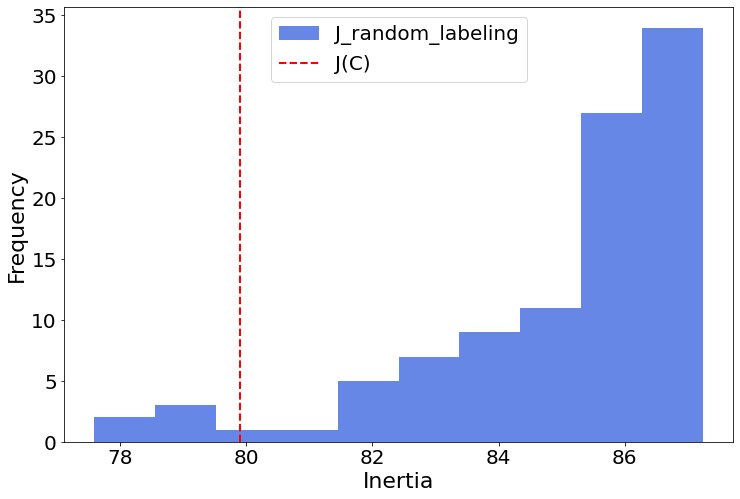

    ID_number Ki67 (%)
0   SCAN_0276        A
1   SCAN_0198        A
2   SCAN_0310        A
3   SCAN_0267        A
4   SCAN_0163        A
5   SCAN_0265        B
6   SCAN_0180        B
7   SCAN_0283        B
8   SCAN_0286        B
9   SCAN_0085        B
10  SCAN_0145        C
11  SCAN_0117        C
12  SCAN_0155        C
13  SCAN_0139        C
14  SCAN_0235        C
torch.Size([64, 16, 16])
J_C:  72.12408550898233
mean hist:  77.63917068339029
5.515085174407957


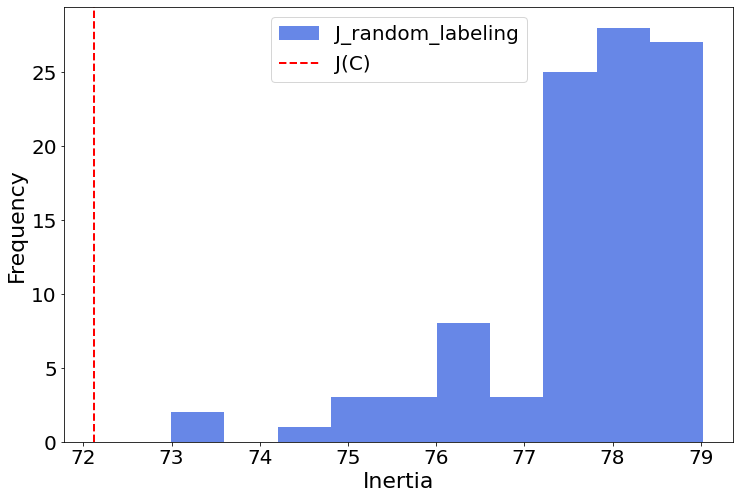

    ID_number Ki67 (%)
0   SCAN_0320        A
1   SCAN_0312        A
2   SCAN_0161        A
3   SCAN_0213        A
4   SCAN_0167        A
5   SCAN_0465        B
6   SCAN_0077        B
7   SCAN_0106        B
8   SCAN_0125        B
9   SCAN_0178        B
10  SCAN_0080        C
11  SCAN_0118        C
12  SCAN_0081        C
13  SCAN_0142        C
14  SCAN_0115        C
torch.Size([64, 16, 16])


KeyboardInterrupt: 

In [40]:
label = 'Ki67 (%)'
for i in range(10):
    sampled_df = get_dataset_continous(label, i)
    print(sampled_df)
    dataset = BiopsyDataset100("/storage/Chloe/zoom_20_512", sampled_df, label, transform=transform)
    distance, mean, percentage = binning_eval(dataset, sampled_df, encoder, label)
    new_row = {'Label': label, 'Encoder': '16384', 'Distance': distance, 'Mean of distribution': mean, "Percentage": percentage}
    df_results = df_results.append(new_row, ignore_index=True)
    

In [ ]:
label = 'TILS (%)'
for i in range(10):
    sampled_df = get_dataset_continous(label, i)
    print(sampled_df)
    dataset = BiopsyDataset100("/storage/Chloe/zoom_20_512", sampled_df, label, transform=transform)
    distance, mean, percentage = binning_eval(dataset, sampled_df, encoder, label)
    new_row = {'Label': label, 'Encoder': '16384', 'Distance': distance, 'Mean of distribution': mean, "Percentage": percentage}
    df_results = df_results.append(new_row, ignore_index=True)
    

In [ ]:
label = 'MYC'
for i in range(10):
    sampled_df = get_dataset_continous(label, i)
    print(sampled_df)
    dataset = BiopsyDataset100("/storage/Chloe/zoom_20_512", sampled_df, label, transform=transform)
    distance, mean, percentage = binning_eval(dataset, sampled_df, encoder, label)
    new_row = {'Label': label, 'Encoder': '16384', 'Distance': distance, 'Mean of distribution': mean, "Percentage": percentage}
    df_results = df_results.append(new_row, ignore_index=True)
    

In [ ]:
label = 'FOXA1'
for i in range(10):
    sampled_df = get_dataset_continous(label, i)
    print(sampled_df)
    dataset = BiopsyDataset100("/storage/Chloe/zoom_20_512", sampled_df, label, transform=transform)
    distance, mean, percentage = binning_eval(dataset, sampled_df, encoder, label)
    new_row = {'Label': label, 'Encoder': '16384', 'Distance': distance, 'Mean of distribution': mean, "Percentage": percentage}
    df_results = df_results.append(new_row, ignore_index=True)
    

In [ ]:
label = 'HIF1A'
for i in range(10):
    sampled_df = get_dataset_continous(label, i)
    print(sampled_df)
    dataset = BiopsyDataset100("/storage/Chloe/zoom_20_512", sampled_df, label, transform=transform)
    distance, mean, percentage = binning_eval(dataset, sampled_df, encoder, label)
    new_row = {'Label': label, 'Encoder': '16384', 'Distance': distance, 'Mean of distribution': mean, "Percentage": percentage}
    df_results = df_results.append(new_row, ignore_index=True)
    

In [ ]:
label = 'ROR.S.Group..Subtype.Only.'
for i in range(10):
    sampled_df = get_dataset_ROR(label, i)
    print(sampled_df)
    dataset = BiopsyDataset100("/storage/Chloe/zoom_20_512", sampled_df, label, transform=transform)
    distance, mean, percentage = binning_eval(dataset, sampled_df, encoder, label)
    new_row = {'Label': label, 'Encoder': '16384', 'Distance': distance, 'Mean of distribution': mean, "Percentage": percentage}
    df_results = df_results.append(new_row, ignore_index=True)
    

In [ ]:
label = 'ROR.P.Group..Subtype...Proliferation.'
for i in range(10):
    sampled_df = get_dataset_ROR(label, i)
    print(sampled_df)
    dataset = BiopsyDataset100("/storage/Chloe/zoom_20_512", sampled_df, label, transform=transform)
    distance, mean, percentage = binning_eval(dataset, sampled_df, encoder, label)
    new_row = {'Label': label, 'Encoder': '16384', 'Distance': distance, 'Mean of distribution': mean, "Percentage": percentage}
    df_results = df_results.append(new_row, ignore_index=True)
    

In [ ]:
label = 'PR status'
for i in range(10):
    sampled_df = get_dataset_pos_neg(label, i)
    print(sampled_df)
    dataset = BiopsyDataset100("/storage/Chloe/zoom_20_512", sampled_df, label, transform=transform)
    distance, mean, percentage = binning_eval(dataset, sampled_df, encoder, label)
    new_row = {'Label': label, 'Encoder': '16384', 'Distance': distance, 'Mean of distribution': mean, "Percentage": percentage}
    df_results = df_results.append(new_row, ignore_index=True)
    

In [ ]:
label = 'PAM50 subtype'
for i in range(10):
    sampled_df = get_dataset_PAM50(label, i)
    print(sampled_df)
    dataset = BiopsyDataset100("/storage/Chloe/zoom_20_512", sampled_df, label, transform=transform)
    distance, mean, percentage = binning_eval(dataset, sampled_df, encoder, label)
    new_row = {'Label': label, 'Encoder': '16384', 'Distance': distance, 'Mean of distribution': mean, "Percentage": percentage}
    df_results = df_results.append(new_row, ignore_index=True)
    

In [ ]:
df_results

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid(),    
        )
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [ ]:
autoencoder = Autoencoder()

In [ ]:
autoencoder.load_state_dict(torch.load('/storage/Chloe/final_model_autoencoder/autoencoder_256*4*4_split41.pth'))

In [ ]:
encoder = autoencoder.encoder

In [ ]:
encoder

In [ ]:
label = 'Ki67 (%)'
for i in range(10):
    sampled_df = get_dataset_continous(label, i)
    print(sampled_df)
    dataset = BiopsyDataset100("/storage/Chloe/zoom_20_512", sampled_df, label, transform=transform)
    distance, mean, percentage = binning_eval(dataset, sampled_df, encoder, label)
    new_row = {'Label': label, 'Encoder': '4096', 'Distance': distance, 'Mean of distribution': mean, "Percentage": percentage}
    df_results = df_results.append(new_row, ignore_index=True)

In [ ]:
label = 'TILS (%)'
for i in range(10):
    sampled_df = get_dataset_continous(label, i)
    print(sampled_df)
    dataset = BiopsyDataset100("/storage/Chloe/zoom_20_512", sampled_df, label, transform=transform)
    distance, mean, percentage = binning_eval(dataset, sampled_df, encoder, label)
    new_row = {'Label': label, 'Encoder': '4096', 'Distance': distance, 'Mean of distribution': mean, "Percentage": percentage}
    df_results = df_results.append(new_row, ignore_index=True)

In [ ]:
label = 'MYC'
for i in range(10):
    sampled_df = get_dataset_continous(label, i)
    print(sampled_df)
    dataset = BiopsyDataset100("/storage/Chloe/zoom_20_512", sampled_df, label, transform=transform)
    distance, mean, percentage = binning_eval(dataset, sampled_df, encoder, label)
    new_row = {'Label': label, 'Encoder': '4096', 'Distance': distance, 'Mean of distribution': mean, "Percentage": percentage}
    df_results = df_results.append(new_row, ignore_index=True)

In [ ]:
label = 'FOXA1'
for i in range(10):
    sampled_df = get_dataset_continous(label, i)
    print(sampled_df)
    dataset = BiopsyDataset100("/storage/Chloe/zoom_20_512", sampled_df, label, transform=transform)
    distance, mean, percentage = binning_eval(dataset, sampled_df, encoder, label)
    new_row = {'Label': label, 'Encoder': '4096', 'Distance': distance, 'Mean of distribution': mean, "Percentage": percentage}
    df_results = df_results.append(new_row, ignore_index=True)

In [ ]:
label = 'HIF1A'
for i in range(10):
    sampled_df = get_dataset_continous(label, i)
    print(sampled_df)
    dataset = BiopsyDataset100("/storage/Chloe/zoom_20_512", sampled_df, label, transform=transform)
    distance, mean, percentage = binning_eval(dataset, sampled_df, encoder, label)
    new_row = {'Label': label, 'Encoder': '4096', 'Distance': distance, 'Mean of distribution': mean, "Percentage": percentage}
    df_results = df_results.append(new_row, ignore_index=True)
    

In [ ]:
label = 'ROR.S.Group..Subtype.Only.'
for i in range(10):
    sampled_df = get_dataset_ROR(label, i)
    print(sampled_df)
    dataset = BiopsyDataset100("/storage/Chloe/zoom_20_512", sampled_df, label, transform=transform)
    distance, mean, percentage = binning_eval(dataset, sampled_df, encoder, label)
    new_row = {'Label': label, 'Encoder': '4096', 'Distance': distance, 'Mean of distribution': mean, "Percentage": percentage}
    df_results = df_results.append(new_row, ignore_index=True)

In [ ]:
label = 'ROR.P.Group..Subtype...Proliferation.'
for i in range(10):
    sampled_df = get_dataset_ROR(label, i)
    print(sampled_df)
    dataset = BiopsyDataset100("/storage/Chloe/zoom_20_512", sampled_df, label, transform=transform)
    distance, mean, percentage = binning_eval(dataset, sampled_df, encoder, label)
    new_row = {'Label': label, 'Encoder': '4096', 'Distance': distance, 'Mean of distribution': mean, "Percentage": percentage}
    df_results = df_results.append(new_row, ignore_index=True)

In [ ]:
label = 'PR status'
for i in range(10):
    sampled_df = get_dataset_pos_neg(label, i)
    print(sampled_df)
    dataset = BiopsyDataset100("/storage/Chloe/zoom_20_512", sampled_df, label, transform=transform)
    distance, mean, percentage = binning_eval(dataset, sampled_df, encoder, label)
    new_row = {'Label': label, 'Encoder': '4096', 'Distance': distance, 'Mean of distribution': mean, "Percentage": percentage}
    df_results = df_results.append(new_row, ignore_index=True)
    

In [ ]:
label = 'PAM50 subtype'
for i in range(10):
    sampled_df = get_dataset_PAM50(label, i)
    print(sampled_df)
    dataset = BiopsyDataset100("/storage/Chloe/zoom_20_512", sampled_df, label, transform=transform)
    distance, mean, percentage = binning_eval(dataset, sampled_df, encoder, label)
    new_row = {'Label': label, 'Encoder': '4096', 'Distance': distance, 'Mean of distribution': mean, "Percentage": percentage}
    df_results = df_results.append(new_row, ignore_index=True)
    

In [ ]:
df_results

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 4, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(4, 8, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 8, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 4, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(4, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid(),    
        )
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [ ]:
autoencoder = Autoencoder()

In [ ]:
autoencoder.load_state_dict(torch.load('/storage/Chloe/final_model_autoencoder/autoencoder_128*2*2_split41.pth'))

In [76]:
encoder = autoencoder.encoder

In [77]:
encoder

Sequential(
  (0): Conv2d(3, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(4, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (3): ReLU()
  (4): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (5): ReLU()
  (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (7): ReLU()
  (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (9): ReLU()
  (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
)

    ID_number Ki67 (%)
0   SCAN_0250        A
1   SCAN_0306        A
2   SCAN_0294        A
3   SCAN_0282        A
4   SCAN_0276        A
5   SCAN_0087        B
6   SCAN_0279        B
7   SCAN_0138        B
8   SCAN_0466        B
9   SCAN_0079        B
10  SCAN_0082        C
11  SCAN_0066        C
12  SCAN_0133        C
13  SCAN_0321        C
14  SCAN_0209        C
torch.Size([128, 2, 2])
J_C:  8.076770795981089
mean hist:  8.114252744944888
0.03748194896379964


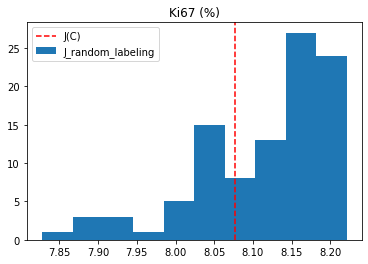

    ID_number Ki67 (%)
0   SCAN_0177        A
1   SCAN_0208        A
2   SCAN_0455        A
3   SCAN_0170        A
4   SCAN_0213        A
5   SCAN_0094        B
6   SCAN_0465        B
7   SCAN_0061        B
8   SCAN_0464        B
9   SCAN_0280        B
10  SCAN_0080        C
11  SCAN_0135        C
12  SCAN_0139        C
13  SCAN_0096        C
14  SCAN_0235        C
torch.Size([128, 2, 2])
J_C:  8.313400818983714
mean hist:  8.717000746463139
0.40359992747942464


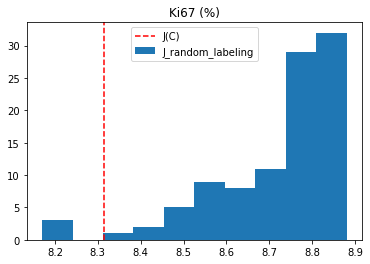

    ID_number Ki67 (%)
0   SCAN_0170        A
1   SCAN_0293        A
2   SCAN_0310        A
3   SCAN_0250        A
4   SCAN_0295        A
5   SCAN_0119        B
6   SCAN_0193        B
7   SCAN_0251        B
8   SCAN_0076        B
9   SCAN_0164        B
10  SCAN_0131        C
11  SCAN_0194        C
12  SCAN_0116        C
13  SCAN_0114        C
14  SCAN_0233        C
torch.Size([128, 2, 2])
J_C:  7.178235827562566
mean hist:  7.179917075853788
0.0016812482912218485


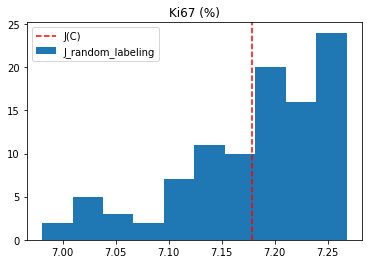

    ID_number Ki67 (%)
0   SCAN_0198        A
1   SCAN_0176        A
2   SCAN_0470        A
3   SCAN_0266        A
4   SCAN_0200        A
5   SCAN_0125        B
6   SCAN_0061        B
7   SCAN_0173        B
8   SCAN_0138        B
9   SCAN_0158        B
10  SCAN_0136        C
11  SCAN_0154        C
12  SCAN_0117        C
13  SCAN_0075        C
14  SCAN_0134        C
torch.Size([128, 2, 2])
J_C:  7.949974647363026
mean hist:  8.322453712822597
0.37247906545957044


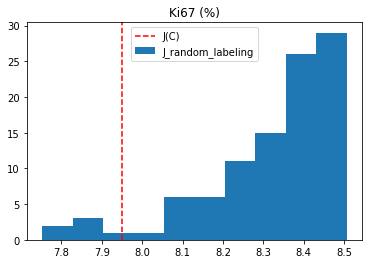

    ID_number Ki67 (%)
0   SCAN_0276        A
1   SCAN_0198        A
2   SCAN_0310        A
3   SCAN_0267        A
4   SCAN_0163        A
5   SCAN_0265        B
6   SCAN_0180        B
7   SCAN_0283        B
8   SCAN_0286        B
9   SCAN_0085        B
10  SCAN_0145        C
11  SCAN_0117        C
12  SCAN_0155        C
13  SCAN_0139        C
14  SCAN_0235        C
torch.Size([128, 2, 2])
J_C:  6.868475648323694
mean hist:  7.244552357966105
0.3760767096424109


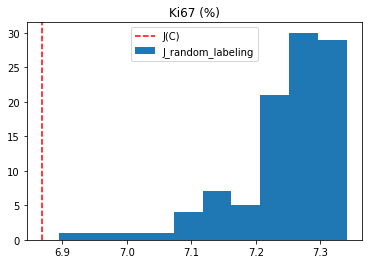

    ID_number Ki67 (%)
0   SCAN_0320        A
1   SCAN_0312        A
2   SCAN_0161        A
3   SCAN_0213        A
4   SCAN_0167        A
5   SCAN_0465        B
6   SCAN_0077        B
7   SCAN_0106        B
8   SCAN_0125        B
9   SCAN_0178        B
10  SCAN_0080        C
11  SCAN_0118        C
12  SCAN_0081        C
13  SCAN_0142        C
14  SCAN_0115        C
torch.Size([128, 2, 2])
J_C:  7.500743597576564
mean hist:  7.607344146179545
0.10660054860298107


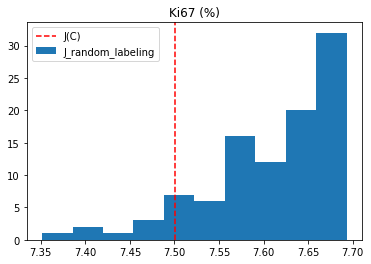

    ID_number Ki67 (%)
0   SCAN_0169        A
1   SCAN_0292        A
2   SCAN_0295        A
3   SCAN_0302        A
4   SCAN_0147        A
5   SCAN_0289        B
6   SCAN_0076        B
7   SCAN_0252        B
8   SCAN_0183        B
9   SCAN_0166        B
10  SCAN_0084        C
11  SCAN_0149        C
12  SCAN_0237        C
13  SCAN_0099        C
14  SCAN_0111        C
torch.Size([128, 2, 2])
J_C:  7.346999215841293
mean hist:  7.458381327055293
0.11138211121400055


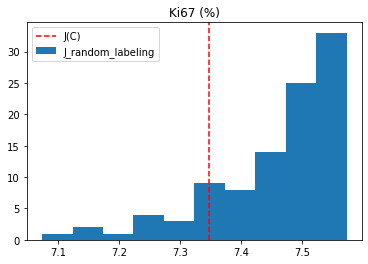

    ID_number Ki67 (%)
0   SCAN_0290        A
1   SCAN_0294        A
2   SCAN_0224        A
3   SCAN_0176        A
4   SCAN_0312        A
5   SCAN_0076        B
6   SCAN_0102        B
7   SCAN_0085        B
8   SCAN_0247        B
9   SCAN_0317        B
10  SCAN_0114        C
11  SCAN_0095        C
12  SCAN_0273        C
13  SCAN_0080        C
14  SCAN_0154        C
torch.Size([128, 2, 2])
J_C:  7.647549618244171
mean hist:  7.602048377323151
-0.045501240921019814


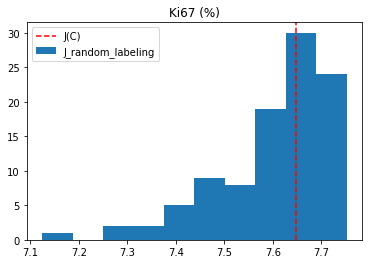

    ID_number Ki67 (%)
0   SCAN_0254        A
1   SCAN_0246        A
2   SCAN_0240        A
3   SCAN_0469        A
4   SCAN_0272        A
5   SCAN_0127        B
6   SCAN_0323        B
7   SCAN_0286        B
8   SCAN_0074        B
9   SCAN_0125        B
10  SCAN_0124        C
11  SCAN_0132        C
12  SCAN_0321        C
13  SCAN_0284        C
14  SCAN_0116        C
torch.Size([128, 2, 2])
J_C:  7.732329360237468
mean hist:  7.73418413829536
0.0018547780578916928


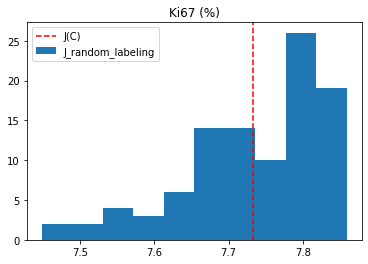

    ID_number Ki67 (%)
0   SCAN_0262        A
1   SCAN_0459        A
2   SCAN_0298        A
3   SCAN_0216        A
4   SCAN_0300        A
5   SCAN_0083        B
6   SCAN_0160        B
7   SCAN_0255        B
8   SCAN_0280        B
9   SCAN_0456        B
10  SCAN_0235        C
11  SCAN_0055        C
12  SCAN_0113        C
13  SCAN_0088        C
14  SCAN_0112        C
torch.Size([128, 2, 2])
J_C:  7.3900951193173725
mean hist:  7.3614046158425
-0.028690503474872564


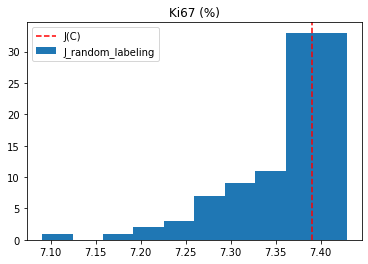

In [78]:
label = 'Ki67 (%)'
for i in range(10):
    sampled_df = get_dataset_continous(label, i)
    print(sampled_df)
    dataset = BiopsyDataset100("/storage/Chloe/zoom_20_512", sampled_df, label, transform=transform)
    distance, mean, percentage = binning_eval(dataset, sampled_df, encoder, label)
    new_row = {'Label': label, 'Encoder': '512', 'Distance': distance, 'Mean of distribution': mean, "Percentage": percentage}
    df_results = df_results.append(new_row, ignore_index=True)

    ID_number TILS (%)
0   SCAN_0067        A
1   SCAN_0271        A
2   SCAN_0255        A
3   SCAN_0102        A
4   SCAN_0305        A
5   SCAN_0108        B
6   SCAN_0232        B
7   SCAN_0247        B
8   SCAN_0188        B
9   SCAN_0099        B
10  SCAN_0203        C
11  SCAN_0118        C
12  SCAN_0170        C
13  SCAN_0128        C
14  SCAN_0086        C
torch.Size([128, 2, 2])
J_C:  7.498002800941467
mean hist:  7.460687544314068
-0.03731525662739976


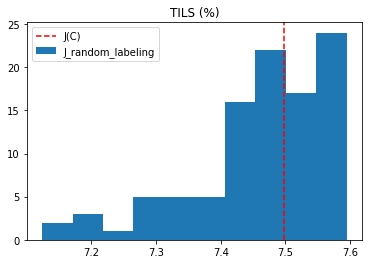

    ID_number TILS (%)
0   SCAN_0266        A
1   SCAN_0223        A
2   SCAN_0324        A
3   SCAN_0197        A
4   SCAN_0260        A
5   SCAN_0275        B
6   SCAN_0113        B
7   SCAN_0133        B
8   SCAN_0312        B
9   SCAN_0058        B
10  SCAN_0228        C
11  SCAN_0156        C
12  SCAN_0144        C
13  SCAN_0313        C
14  SCAN_0105        C
torch.Size([128, 2, 2])
J_C:  8.777602968851724
mean hist:  8.81714374911308
0.039540780261356545


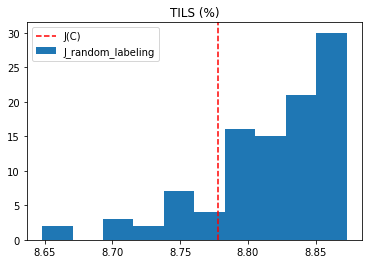

    ID_number TILS (%)
0   SCAN_0237        A
1   SCAN_0211        A
2   SCAN_0180        A
3   SCAN_0079        A
4   SCAN_0160        A
5   SCAN_0091        B
6   SCAN_0216        B
7   SCAN_0248        B
8   SCAN_0099        B
9   SCAN_0157        B
10  SCAN_0321        C
11  SCAN_0217        C
12  SCAN_0162        C
13  SCAN_0175        C
14  SCAN_0457        C
torch.Size([128, 2, 2])
J_C:  7.850301146666209
mean hist:  7.93106159830888
0.08076045164267143


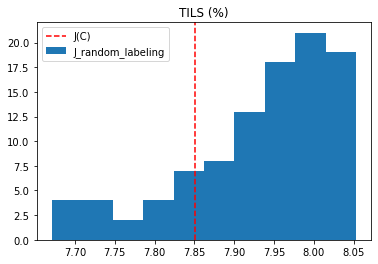

    ID_number TILS (%)
0   SCAN_0253        A
1   SCAN_0194        A
2   SCAN_0064        A
3   SCAN_0130        A
4   SCAN_0327        A
5   SCAN_0471        B
6   SCAN_0281        B
7   SCAN_0301        B
8   SCAN_0164        B
9   SCAN_0328        B
10  SCAN_0297        C
11  SCAN_0177        C
12  SCAN_0263        C
13  SCAN_0103        C
14  SCAN_0150        C
torch.Size([128, 2, 2])
J_C:  7.166220383753608
mean hist:  7.097655430606611
-0.06856495314699629


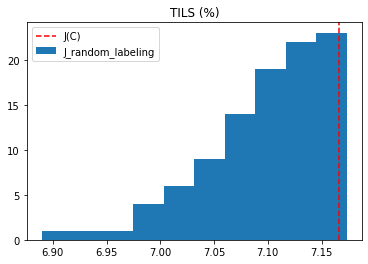

    ID_number TILS (%)
0   SCAN_0093        A
1   SCAN_0467        A
2   SCAN_0306        A
3   SCAN_0084        A
4   SCAN_0064        A
5   SCAN_0304        B
6   SCAN_0164        B
7   SCAN_0290        B
8   SCAN_0136        B
9   SCAN_0291        B
10  SCAN_0132        C
11  SCAN_0268        C
12  SCAN_0150        C
13  SCAN_0313        C
14  SCAN_0154        C
torch.Size([128, 2, 2])
J_C:  8.193305333455404
mean hist:  8.323585535739745
0.13028020228434123


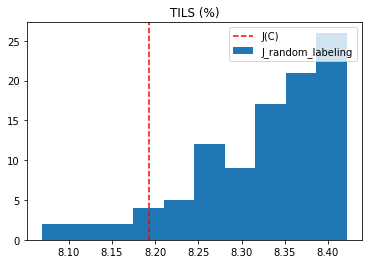

    ID_number TILS (%)
0   SCAN_0289        A
1   SCAN_0293        A
2   SCAN_0169        A
3   SCAN_0192        A
4   SCAN_0088        A
5   SCAN_0136        B
6   SCAN_0257        B
7   SCAN_0328        B
8   SCAN_0147        B
9   SCAN_0078        B
10  SCAN_0460        C
11  SCAN_0263        C
12  SCAN_0109        C
13  SCAN_0321        C
14  SCAN_0228        C
torch.Size([128, 2, 2])
J_C:  7.408084634319696
mean hist:  7.64506219360386
0.2369775592841643


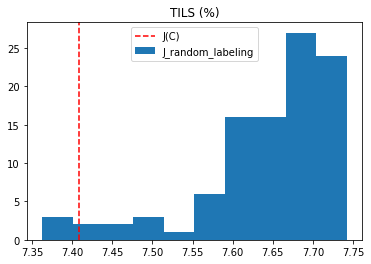

    ID_number TILS (%)
0   SCAN_0122        A
1   SCAN_0195        A
2   SCAN_0260        A
3   SCAN_0055        A
4   SCAN_0084        A
5   SCAN_0136        B
6   SCAN_0095        B
7   SCAN_0233        B
8   SCAN_0091        B
9   SCAN_0190        B
10  SCAN_0226        C
11  SCAN_0109        C
12  SCAN_0118        C
13  SCAN_0459        C
14  SCAN_0297        C
torch.Size([128, 2, 2])
J_C:  8.45739656829834
mean hist:  8.367111371793747
-0.09028519650459188


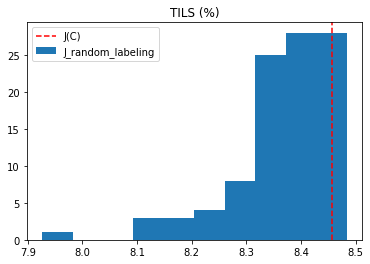

    ID_number TILS (%)
0   SCAN_0208        A
1   SCAN_0191        A
2   SCAN_0189        A
3   SCAN_0158        A
4   SCAN_0149        A
5   SCAN_0301        B
6   SCAN_0470        B
7   SCAN_0287        B
8   SCAN_0468        B
9   SCAN_0070        B
10  SCAN_0288        C
11  SCAN_0273        C
12  SCAN_0217        C
13  SCAN_0131        C
14  SCAN_0109        C
torch.Size([128, 2, 2])
J_C:  8.230852922121683
mean hist:  8.26863286422491
0.03777994210322788


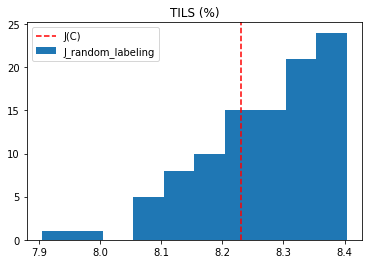

    ID_number TILS (%)
0   SCAN_0158        A
1   SCAN_0197        A
2   SCAN_0183        A
3   SCAN_0458        A
4   SCAN_0062        A
5   SCAN_0198        B
6   SCAN_0135        B
7   SCAN_0087        B
8   SCAN_0095        B
9   SCAN_0106        B
10  SCAN_0285        C
11  SCAN_0162        C
12  SCAN_0228        C
13  SCAN_0170        C
14  SCAN_0150        C
torch.Size([128, 2, 2])
J_C:  7.4795568233711895
mean hist:  7.52633700669307
0.046780183321880386


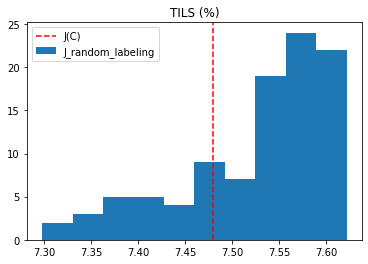

    ID_number TILS (%)
0   SCAN_0192        A
1   SCAN_0061        A
2   SCAN_0112        A
3   SCAN_0467        A
4   SCAN_0071        A
5   SCAN_0326        B
6   SCAN_0291        B
7   SCAN_0114        B
8   SCAN_0233        B
9   SCAN_0276        B
10  SCAN_0265        C
11  SCAN_0263        C
12  SCAN_0213        C
13  SCAN_0132        C
14  SCAN_0056        C
torch.Size([128, 2, 2])
J_C:  7.667290059465659
mean hist:  7.728869249806393
0.061579190340734336


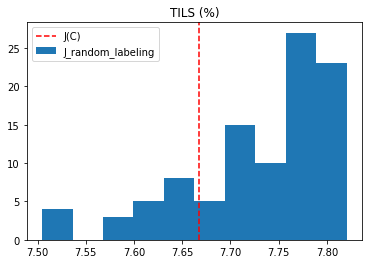

In [79]:
label = 'TILS (%)'
for i in range(10):
    sampled_df = get_dataset_continous(label, i)
    print(sampled_df)
    dataset = BiopsyDataset100("/storage/Chloe/zoom_20_512", sampled_df, label, transform=transform)
    distance, mean, percentage = binning_eval(dataset, sampled_df, encoder, label)
    new_row = {'Label': label, 'Encoder': '512', 'Distance': distance, 'Mean of distribution': mean, "Percentage": percentage}
    df_results = df_results.append(new_row, ignore_index=True)

    ID_number MYC
0   SCAN_0056   A
1   SCAN_0089   A
2   SCAN_0290   A
3   SCAN_0262   A
4   SCAN_0174   A
5   SCAN_0099   B
6   SCAN_0092   B
7   SCAN_0071   B
8   SCAN_0286   B
9   SCAN_0323   B
10  SCAN_0192   C
11  SCAN_0205   C
12  SCAN_0471   C
13  SCAN_0097   C
14  SCAN_0199   C
torch.Size([128, 2, 2])
J_C:  7.462337709108988
mean hist:  7.421375530320803
-0.04096217878818553


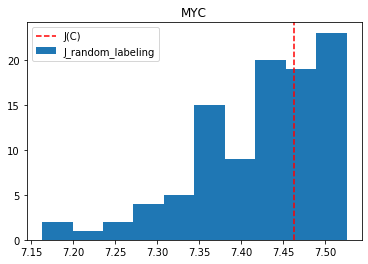

    ID_number MYC
0   SCAN_0296   A
1   SCAN_0202   A
2   SCAN_0266   A
3   SCAN_0292   A
4   SCAN_0325   A
5   SCAN_0096   B
6   SCAN_0322   B
7   SCAN_0065   B
8   SCAN_0318   B
9   SCAN_0204   B
10  SCAN_0198   C
11  SCAN_0180   C
12  SCAN_0157   C
13  SCAN_0197   C
14  SCAN_0123   C
torch.Size([128, 2, 2])
J_C:  7.357558479785919
mean hist:  7.350541459546089
-0.007017020239829641


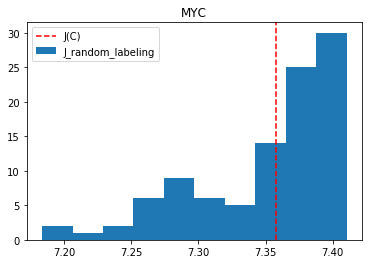

    ID_number MYC
0   SCAN_0293   A
1   SCAN_0111   A
2   SCAN_0251   A
3   SCAN_0056   A
4   SCAN_0119   A
5   SCAN_0115   B
6   SCAN_0323   B
7   SCAN_0063   B
8   SCAN_0173   B
9   SCAN_0465   B
10  SCAN_0209   C
11  SCAN_0098   C
12  SCAN_0205   C
13  SCAN_0129   C
14  SCAN_0219   C
torch.Size([128, 2, 2])
J_C:  8.85005554503095
mean hist:  8.700728577513175
-0.14932696751777463


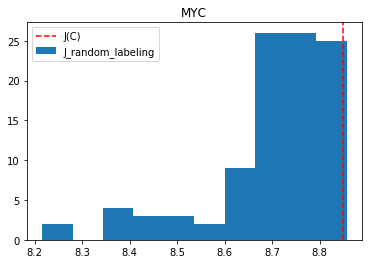

    ID_number MYC
0   SCAN_0215   A
1   SCAN_0161   A
2   SCAN_0457   A
3   SCAN_0468   A
4   SCAN_0257   A
5   SCAN_0115   B
6   SCAN_0065   B
7   SCAN_0216   B
8   SCAN_0126   B
9   SCAN_0162   B
10  SCAN_0235   C
11  SCAN_0217   C
12  SCAN_0137   C
13  SCAN_0462   C
14  SCAN_0134   C
torch.Size([128, 2, 2])
J_C:  8.959014468193054
mean hist:  8.912028028154372
-0.046986440038681465


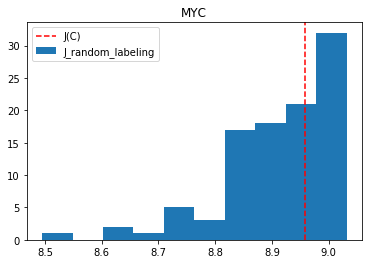

    ID_number MYC
0   SCAN_0089   A
1   SCAN_0316   A
2   SCAN_0251   A
3   SCAN_0085   A
4   SCAN_0290   A
5   SCAN_0258   B
6   SCAN_0173   B
7   SCAN_0272   B
8   SCAN_0274   B
9   SCAN_0090   B
10  SCAN_0231   C
11  SCAN_0058   C
12  SCAN_0195   C
13  SCAN_0200   C
14  SCAN_0157   C
torch.Size([128, 2, 2])
J_C:  7.397670258196931
mean hist:  7.3002997963423715
-0.09737046185455966


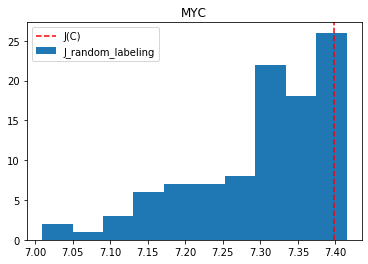

    ID_number MYC
0   SCAN_0257   A
1   SCAN_0253   A
2   SCAN_0295   A
3   SCAN_0298   A
4   SCAN_0232   A
5   SCAN_0272   B
6   SCAN_0065   B
7   SCAN_0122   B
8   SCAN_0322   B
9   SCAN_0310   B
10  SCAN_0211   C
11  SCAN_0196   C
12  SCAN_0124   C
13  SCAN_0195   C
14  SCAN_0315   C
torch.Size([128, 2, 2])
J_C:  7.254987930138905
mean hist:  7.165913827122053
-0.08907410301685204


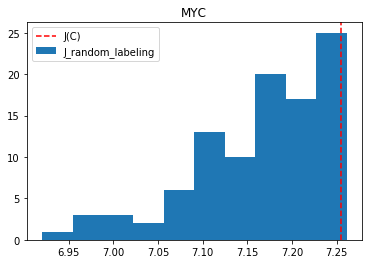

    ID_number MYC
0   SCAN_0291   A
1   SCAN_0109   A
2   SCAN_0119   A
3   SCAN_0141   A
4   SCAN_0054   A
5   SCAN_0281   B
6   SCAN_0077   B
7   SCAN_0248   B
8   SCAN_0181   B
9   SCAN_0310   B
10  SCAN_0139   C
11  SCAN_0287   C
12  SCAN_0222   C
13  SCAN_0157   C
14  SCAN_0170   C
torch.Size([128, 2, 2])
J_C:  7.352510551201492
mean hist:  7.394355318458903
0.04184476725741071


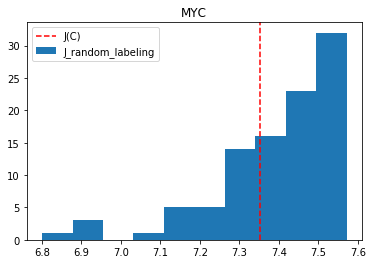

    ID_number MYC
0   SCAN_0106   A
1   SCAN_0118   A
2   SCAN_0320   A
3   SCAN_0296   A
4   SCAN_0253   A
5   SCAN_0077   B
6   SCAN_0100   B
7   SCAN_0090   B
8   SCAN_0145   B
9   SCAN_0307   B
10  SCAN_0194   C
11  SCAN_0178   C
12  SCAN_0193   C
13  SCAN_0200   C
14  SCAN_0170   C
torch.Size([128, 2, 2])
J_C:  6.999227902936664
mean hist:  7.207952755557542
0.20872485262087714


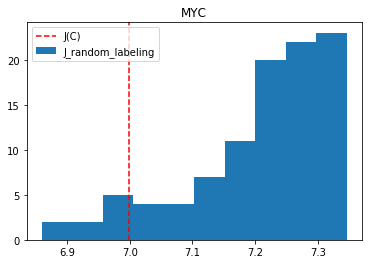

    ID_number MYC
0   SCAN_0251   A
1   SCAN_0202   A
2   SCAN_0296   A
3   SCAN_0461   A
4   SCAN_0277   A
5   SCAN_0216   B
6   SCAN_0204   B
7   SCAN_0260   B
8   SCAN_0062   B
9   SCAN_0258   B
10  SCAN_0163   C
11  SCAN_0177   C
12  SCAN_0188   C
13  SCAN_0205   C
14  SCAN_0460   C
torch.Size([128, 2, 2])
J_C:  6.917486135030197
mean hist:  7.018723348822029
0.10123721379183159


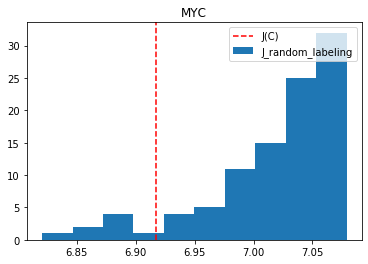

    ID_number MYC
0   SCAN_0268   A
1   SCAN_0136   A
2   SCAN_0292   A
3   SCAN_0317   A
4   SCAN_0319   A
5   SCAN_0084   B
6   SCAN_0322   B
7   SCAN_0162   B
8   SCAN_0328   B
9   SCAN_0263   B
10  SCAN_0165   C
11  SCAN_0132   C
12  SCAN_0156   C
13  SCAN_0113   C
14  SCAN_0167   C
torch.Size([128, 2, 2])
J_C:  7.459168926640427
mean hist:  7.4083606106969695
-0.05080831594345714


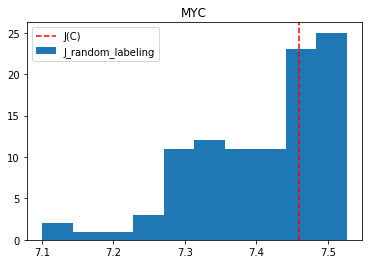

In [80]:
label = 'MYC'
for i in range(10):
    sampled_df = get_dataset_continous(label, i)
    print(sampled_df)
    dataset = BiopsyDataset100("/storage/Chloe/zoom_20_512", sampled_df, label, transform=transform)
    distance, mean, percentage = binning_eval(dataset, sampled_df, encoder, label)
    new_row = {'Label': label, 'Encoder': '512', 'Distance': distance, 'Mean of distribution': mean, "Percentage": percentage}
    df_results = df_results.append(new_row, ignore_index=True)

    ID_number FOXA1
0   SCAN_0070     A
1   SCAN_0143     A
2   SCAN_0182     A
3   SCAN_0165     A
4   SCAN_0237     A
5   SCAN_0089     B
6   SCAN_0085     B
7   SCAN_0069     B
8   SCAN_0280     B
9   SCAN_0298     B
10  SCAN_0290     C
11  SCAN_0316     C
12  SCAN_0471     C
13  SCAN_0078     C
14  SCAN_0307     C
torch.Size([128, 2, 2])
J_C:  7.849938022843832
mean hist:  7.783362810253063
-0.06657521259076837


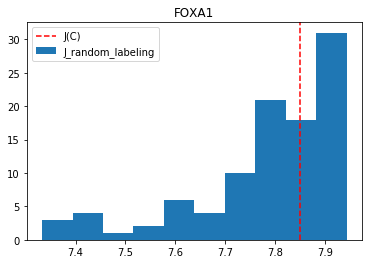

    ID_number FOXA1
0   SCAN_0190     A
1   SCAN_0241     A
2   SCAN_0167     A
3   SCAN_0184     A
4   SCAN_0216     A
5   SCAN_0087     B
6   SCAN_0297     B
7   SCAN_0057     B
8   SCAN_0292     B
9   SCAN_0188     B
10  SCAN_0306     C
11  SCAN_0278     C
12  SCAN_0111     C
13  SCAN_0304     C
14  SCAN_0088     C
torch.Size([128, 2, 2])
J_C:  7.035108267625173
mean hist:  7.063009878341358
0.027901610716185132


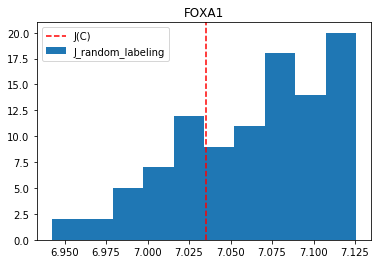

    ID_number FOXA1
0   SCAN_0186     A
1   SCAN_0267     A
2   SCAN_0326     A
3   SCAN_0070     A
4   SCAN_0276     A
5   SCAN_0116     B
6   SCAN_0298     B
7   SCAN_0056     B
8   SCAN_0466     B
9   SCAN_0329     B
10  SCAN_0322     C
11  SCAN_0079     C
12  SCAN_0316     C
13  SCAN_0091     C
14  SCAN_0467     C
torch.Size([128, 2, 2])
J_C:  7.832555657311071
mean hist:  7.9557655444631905
0.12320988715211989


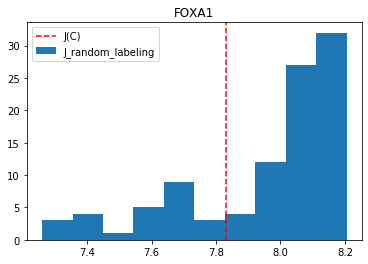

    ID_number FOXA1
0   SCAN_0469     A
1   SCAN_0235     A
2   SCAN_0225     A
3   SCAN_0234     A
4   SCAN_0163     A
5   SCAN_0116     B
6   SCAN_0057     B
7   SCAN_0204     B
8   SCAN_0131     B
9   SCAN_0458     B
10  SCAN_0213     C
11  SCAN_0462     C
12  SCAN_0099     C
13  SCAN_0253     C
14  SCAN_0098     C
torch.Size([128, 2, 2])
J_C:  7.831970655918121
mean hist:  7.877796170318922
0.04582551440080085


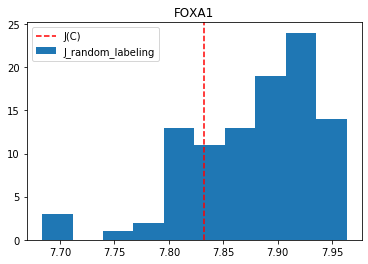

    ID_number FOXA1
0   SCAN_0143     A
1   SCAN_0207     A
2   SCAN_0326     A
3   SCAN_0132     A
4   SCAN_0182     A
5   SCAN_0246     B
6   SCAN_0466     B
7   SCAN_0272     B
8   SCAN_0274     B
9   SCAN_0084     B
10  SCAN_0193     C
11  SCAN_0058     C
12  SCAN_0299     C
13  SCAN_0310     C
14  SCAN_0111     C
torch.Size([128, 2, 2])
J_C:  7.7555300594569045
mean hist:  7.688060788046608
-0.0674692714102969


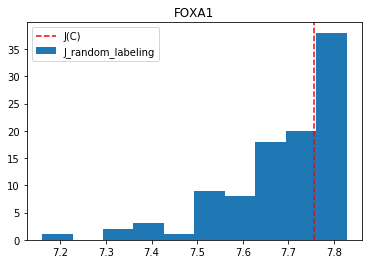

    ID_number FOXA1
0   SCAN_0163     A
1   SCAN_0460     A
2   SCAN_0189     A
3   SCAN_0196     A
4   SCAN_0470     A
5   SCAN_0272     B
6   SCAN_0057     B
7   SCAN_0130     B
8   SCAN_0297     B
9   SCAN_0287     B
10  SCAN_0325     C
11  SCAN_0301     C
12  SCAN_0090     C
13  SCAN_0299     C
14  SCAN_0157     C
torch.Size([128, 2, 2])
J_C:  7.264483709653218
mean hist:  7.22209216411352
-0.04239154553969815


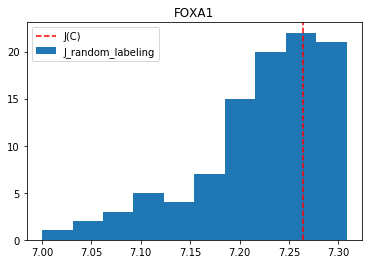

    ID_number FOXA1
0   SCAN_0183     A
1   SCAN_0260     A
2   SCAN_0276     A
3   SCAN_0305     A
4   SCAN_0064     A
5   SCAN_0275     B
6   SCAN_0076     B
7   SCAN_0148     B
8   SCAN_0164     B
9   SCAN_0287     B
10  SCAN_0102     C
11  SCAN_0125     C
12  SCAN_0468     C
13  SCAN_0111     C
14  SCAN_0264     C
torch.Size([128, 2, 2])
J_C:  7.6232793334325155
mean hist:  7.798418177405198
0.17513884397268242


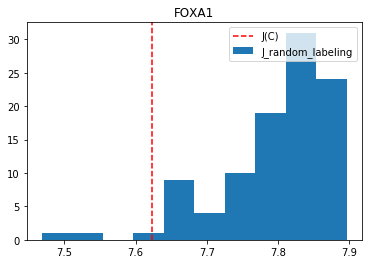

    ID_number FOXA1
0   SCAN_0155     A
1   SCAN_0268     A
2   SCAN_0212     A
3   SCAN_0190     A
4   SCAN_0460     A
5   SCAN_0076     B
6   SCAN_0094     B
7   SCAN_0084     B
8   SCAN_0137     B
9   SCAN_0285     B
10  SCAN_0293     C
11  SCAN_0271     C
12  SCAN_0291     C
13  SCAN_0310     C
14  SCAN_0264     C
torch.Size([128, 2, 2])
J_C:  7.899726638158162
mean hist:  8.07052490277449
0.1707982646163284


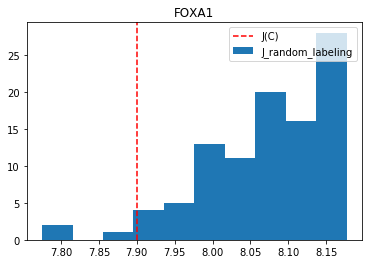

    ID_number FOXA1
0   SCAN_0326     A
1   SCAN_0241     A
2   SCAN_0190     A
3   SCAN_0228     A
4   SCAN_0171     A
5   SCAN_0204     B
6   SCAN_0188     B
7   SCAN_0249     B
8   SCAN_0055     B
9   SCAN_0246     B
10  SCAN_0257     C
11  SCAN_0270     C
12  SCAN_0283     C
13  SCAN_0316     C
14  SCAN_0251     C
torch.Size([128, 2, 2])
J_C:  6.750923692265536
mean hist:  6.724845729436453
-0.026077962829083035


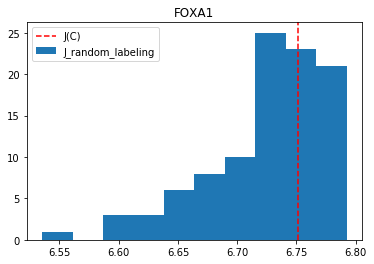

    ID_number FOXA1
0   SCAN_0169     A
1   SCAN_0296     A
2   SCAN_0184     A
3   SCAN_0210     A
4   SCAN_0211     A
5   SCAN_0082     B
6   SCAN_0297     B
7   SCAN_0458     B
8   SCAN_0317     B
9   SCAN_0252     B
10  SCAN_0258     C
11  SCAN_0093     C
12  SCAN_0110     C
13  SCAN_0086     C
14  SCAN_0261     C
torch.Size([128, 2, 2])
J_C:  7.430367001056671
mean hist:  7.6197052811988195
0.18933828014214882


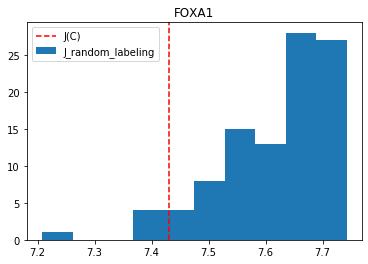

In [81]:
label = 'FOXA1'
for i in range(10):
    sampled_df = get_dataset_continous(label, i)
    print(sampled_df)
    dataset = BiopsyDataset100("/storage/Chloe/zoom_20_512", sampled_df, label, transform=transform)
    distance, mean, percentage = binning_eval(dataset, sampled_df, encoder, label)
    new_row = {'Label': label, 'Encoder': '512', 'Distance': distance, 'Mean of distribution': mean, "Percentage": percentage}
    df_results = df_results.append(new_row, ignore_index=True)

    ID_number HIF1A
0   SCAN_0061     A
1   SCAN_0081     A
2   SCAN_0271     A
3   SCAN_0150     A
4   SCAN_0215     A
5   SCAN_0115     B
6   SCAN_0110     B
7   SCAN_0082     B
8   SCAN_0305     B
9   SCAN_0328     B
10  SCAN_0169     C
11  SCAN_0189     C
12  SCAN_0469     C
13  SCAN_0098     C
14  SCAN_0181     C
torch.Size([128, 2, 2])
J_C:  7.874161031400486
mean hist:  7.764627552118745
-0.1095334792817404


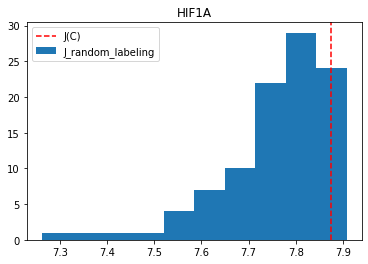

    ID_number HIF1A
0   SCAN_0291     A
1   SCAN_0222     A
2   SCAN_0156     A
3   SCAN_0276     A
4   SCAN_0463     A
5   SCAN_0114     B
6   SCAN_0327     B
7   SCAN_0071     B
8   SCAN_0321     B
9   SCAN_0205     B
10  SCAN_0178     C
11  SCAN_0162     C
12  SCAN_0258     C
13  SCAN_0177     C
14  SCAN_0130     C
torch.Size([128, 2, 2])
J_C:  6.980715825398763
mean hist:  6.973983948299089
-0.006731877099674044


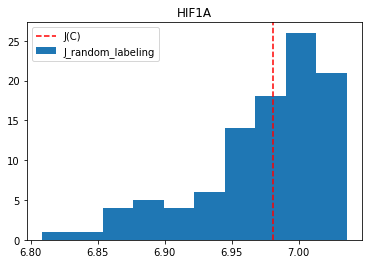

    ID_number HIF1A
0   SCAN_0277     A
1   SCAN_0093     A
2   SCAN_0132     A
3   SCAN_0061     A
4   SCAN_0097     A
5   SCAN_0131     B
6   SCAN_0328     B
7   SCAN_0066     B
8   SCAN_0182     B
9   SCAN_0160     B
10  SCAN_0202     C
11  SCAN_0103     C
12  SCAN_0189     C
13  SCAN_0137     C
14  SCAN_0218     C
torch.Size([128, 2, 2])
J_C:  7.663278341293335
mean hist:  7.552476364772339
-0.11080197652099599


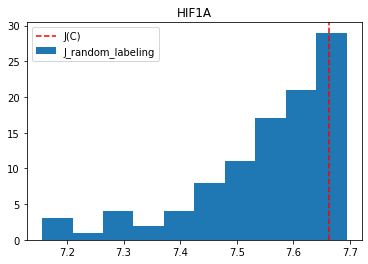

    ID_number HIF1A
0   SCAN_0223     A
1   SCAN_0208     A
2   SCAN_0168     A
3   SCAN_0200     A
4   SCAN_0147     A
5   SCAN_0131     B
6   SCAN_0071     B
7   SCAN_0210     B
8   SCAN_0143     B
9   SCAN_0173     B
10  SCAN_0234     C
11  SCAN_0213     C
12  SCAN_0146     C
13  SCAN_0301     C
14  SCAN_0145     C
torch.Size([128, 2, 2])
J_C:  7.5756330192883805
mean hist:  7.501119293111959
-0.07451372617642171


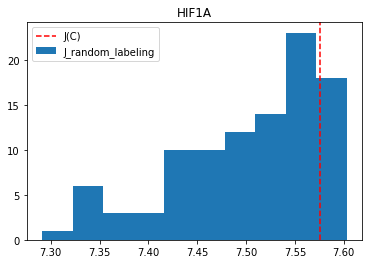

    ID_number HIF1A
0   SCAN_0081     A
1   SCAN_0324     A
2   SCAN_0132     A
3   SCAN_0073     A
4   SCAN_0271     A
5   SCAN_0273     B
6   SCAN_0182     B
7   SCAN_0294     B
8   SCAN_0298     B
9   SCAN_0109     B
10  SCAN_0231     C
11  SCAN_0054     C
12  SCAN_0175     C
13  SCAN_0184     C
14  SCAN_0258     C
torch.Size([128, 2, 2])
J_C:  7.163209589423141
mean hist:  7.157997271390339
-0.005212318032802088


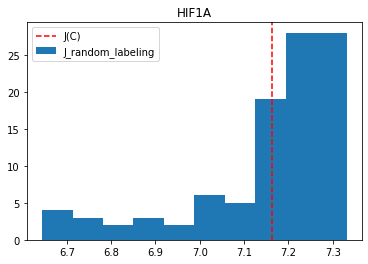

    ID_number HIF1A
0   SCAN_0147     A
1   SCAN_0136     A
2   SCAN_0283     A
3   SCAN_0303     A
4   SCAN_0471     A
5   SCAN_0294     B
6   SCAN_0071     B
7   SCAN_0140     B
8   SCAN_0327     B
9   SCAN_0314     B
10  SCAN_0207     C
11  SCAN_0176     C
12  SCAN_0134     C
13  SCAN_0175     C
14  SCAN_0295     C
torch.Size([128, 2, 2])
J_C:  8.27070420890957
mean hist:  8.251334130765796
-0.01937007814377445


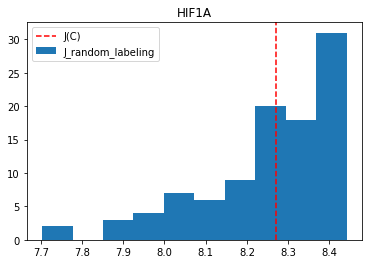

    ID_number HIF1A
0   SCAN_0275     A
1   SCAN_0092     A
2   SCAN_0097     A
3   SCAN_0113     A
4   SCAN_0055     A
5   SCAN_0300     B
6   SCAN_0095     B
7   SCAN_0262     B
8   SCAN_0183     B
9   SCAN_0314     B
10  SCAN_0151     C
11  SCAN_0285     C
12  SCAN_0219     C
13  SCAN_0258     C
14  SCAN_0329     C
torch.Size([128, 2, 2])
J_C:  7.285538115070365
mean hist:  7.251264882872333
-0.034273232198031245


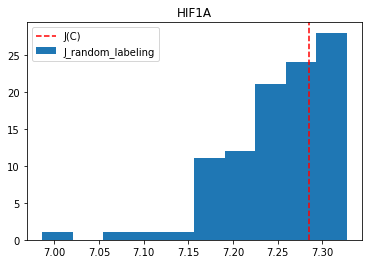

    ID_number HIF1A
0   SCAN_0090     A
1   SCAN_0096     A
2   SCAN_0457     A
3   SCAN_0291     A
4   SCAN_0136     A
5   SCAN_0095     B
6   SCAN_0116     B
7   SCAN_0109     B
8   SCAN_0252     B
9   SCAN_0312     B
10  SCAN_0171     C
11  SCAN_0468     C
12  SCAN_0170     C
13  SCAN_0184     C
14  SCAN_0329     C
torch.Size([128, 2, 2])
J_C:  7.9423342800140375
mean hist:  8.182879120979308
0.24054484096527062


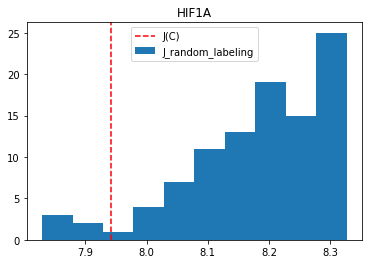

    ID_number HIF1A
0   SCAN_0132     A
1   SCAN_0222     A
2   SCAN_0291     A
3   SCAN_0191     A
4   SCAN_0256     A
5   SCAN_0210     B
6   SCAN_0205     B
7   SCAN_0278     B
8   SCAN_0058     B
9   SCAN_0273     B
10  SCAN_0317     C
11  SCAN_0462     C
12  SCAN_0164     C
13  SCAN_0189     C
14  SCAN_0296     C
torch.Size([128, 2, 2])
J_C:  7.3718814304306
mean hist:  7.495334881974348
0.12345345154374865


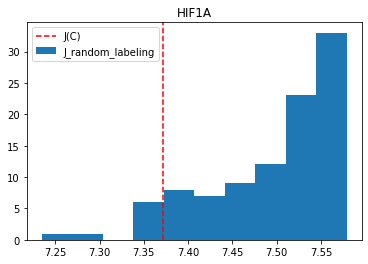

    ID_number HIF1A
0   SCAN_0253     A
1   SCAN_0111     A
2   SCAN_0276     A
3   SCAN_0325     A
4   SCAN_0455     A
5   SCAN_0108     B
6   SCAN_0327     B
7   SCAN_0173     B
8   SCAN_0465     B
9   SCAN_0281     B
10  SCAN_0322     C
11  SCAN_0144     C
12  SCAN_0257     C
13  SCAN_0128     C
14  SCAN_0323     C
torch.Size([128, 2, 2])
J_C:  8.663758356253306
mean hist:  8.469907442020574
-0.1938509142327316


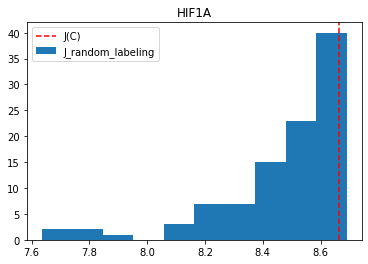

In [82]:
label = 'HIF1A'
for i in range(10):
    sampled_df = get_dataset_continous(label, i)
    print(sampled_df)
    dataset = BiopsyDataset100("/storage/Chloe/zoom_20_512", sampled_df, label, transform=transform)
    distance, mean, percentage = binning_eval(dataset, sampled_df, encoder, label)
    new_row = {'Label': label, 'Encoder': '512', 'Distance': distance, 'Mean of distribution': mean, "Percentage": percentage}
    df_results = df_results.append(new_row, ignore_index=True)
    

    ID_number ROR.S.Group..Subtype.Only.
0   SCAN_0311                          0
1   SCAN_0292                          0
2   SCAN_0190                          0
3   SCAN_0329                          0
4   SCAN_0259                          0
5   SCAN_0115                          1
6   SCAN_0111                          1
7   SCAN_0181                          1
8   SCAN_0097                          1
9   SCAN_0248                          1
10  SCAN_0313                          2
11  SCAN_0238                          2
12  SCAN_0145                          2
13  SCAN_0134                          2
14  SCAN_0112                          2
torch.Size([128, 2, 2])
J_C:  7.897480191389719
mean hist:  8.029255714651745
0.1317755232620259


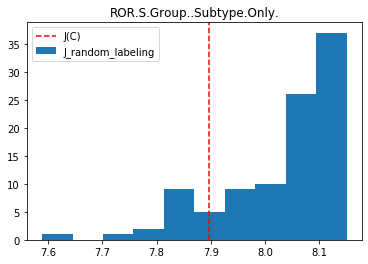

    ID_number ROR.S.Group..Subtype.Only.
0   SCAN_0233                          0
1   SCAN_0212                          0
2   SCAN_0459                          0
3   SCAN_0460                          0
4   SCAN_0301                          0
5   SCAN_0094                          1
6   SCAN_0137                          1
7   SCAN_0248                          1
8   SCAN_0209                          1
9   SCAN_0136                          1
10  SCAN_0112                          2
11  SCAN_0082                          2
12  SCAN_0253                          2
13  SCAN_0145                          2
14  SCAN_0129                          2
torch.Size([128, 2, 2])
J_C:  8.229386756738027
mean hist:  8.388099474864006
0.15871271812597953


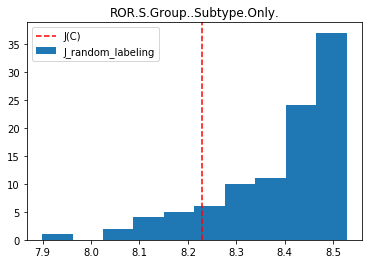

    ID_number ROR.S.Group..Subtype.Only.
0   SCAN_0197                          0
1   SCAN_0305                          0
2   SCAN_0266                          0
3   SCAN_0250                          0
4   SCAN_0298                          0
5   SCAN_0090                          1
6   SCAN_0138                          1
7   SCAN_0461                          1
8   SCAN_0078                          1
9   SCAN_0265                          1
10  SCAN_0268                          2
11  SCAN_0128                          2
12  SCAN_0134                          2
13  SCAN_0130                          2
14  SCAN_0154                          2
torch.Size([128, 2, 2])
J_C:  8.405507713476817
mean hist:  8.620246786233583
0.21473907275676574


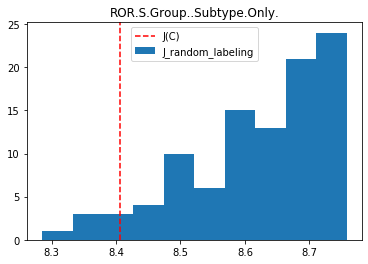

    ID_number ROR.S.Group..Subtype.Only.
0   SCAN_0304                          0
1   SCAN_0259                          0
2   SCAN_0221                          0
3   SCAN_0302                          0
4   SCAN_0254                          0
5   SCAN_0081                          1
6   SCAN_0084                          1
7   SCAN_0186                          1
8   SCAN_0060                          1
9   SCAN_0127                          1
10  SCAN_0232                          2
11  SCAN_0318                          2
12  SCAN_0150                          2
13  SCAN_0092                          2
14  SCAN_0135                          2
torch.Size([128, 2, 2])
J_C:  7.693622193012872
mean hist:  7.781609802070253
0.08798760905738146


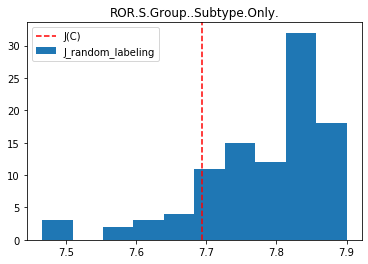

    ID_number ROR.S.Group..Subtype.Only.
0   SCAN_0254                          0
1   SCAN_0292                          0
2   SCAN_0297                          0
3   SCAN_0467                          0
4   SCAN_0282                          0
5   SCAN_0314                          1
6   SCAN_0054                          1
7   SCAN_0101                          1
8   SCAN_0148                          1
9   SCAN_0270                          1
10  SCAN_0056                          2
11  SCAN_0238                          2
12  SCAN_0092                          2
13  SCAN_0068                          2
14  SCAN_0129                          2
torch.Size([128, 2, 2])
J_C:  7.8886558389933095
mean hist:  8.033906871390208
0.14525103239689852


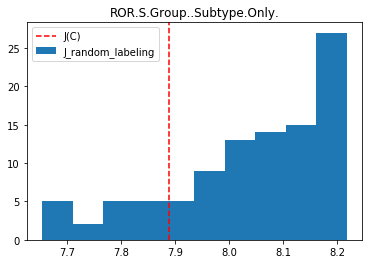

    ID_number ROR.S.Group..Subtype.Only.
0   SCAN_0185                          0
1   SCAN_0326                          0
2   SCAN_0277                          0
3   SCAN_0291                          0
4   SCAN_0212                          0
5   SCAN_0088                          1
6   SCAN_0148                          1
7   SCAN_0283                          1
8   SCAN_0140                          1
9   SCAN_0094                          1
10  SCAN_0100                          2
11  SCAN_0284                          2
12  SCAN_0103                          2
13  SCAN_0129                          2
14  SCAN_0082                          2
torch.Size([128, 2, 2])
J_C:  8.18913553771326
mean hist:  8.321714679428682
0.1325791417154214


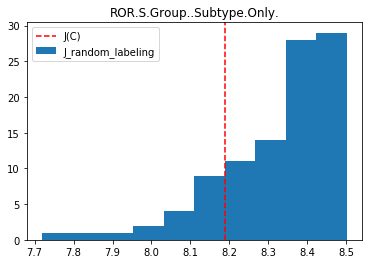

    ID_number ROR.S.Group..Subtype.Only.
0   SCAN_0231                          0
1   SCAN_0211                          0
2   SCAN_0295                          0
3   SCAN_0208                          0
4   SCAN_0058                          0
5   SCAN_0186                          1
6   SCAN_0138                          1
7   SCAN_0133                          1
8   SCAN_0060                          1
9   SCAN_0078                          1
10  SCAN_0108                          2
11  SCAN_0100                          2
12  SCAN_0109                          2
13  SCAN_0132                          2
14  SCAN_0141                          2
torch.Size([128, 2, 2])
J_C:  8.719838273453664
mean hist:  9.115743671899798
0.3959053984461338


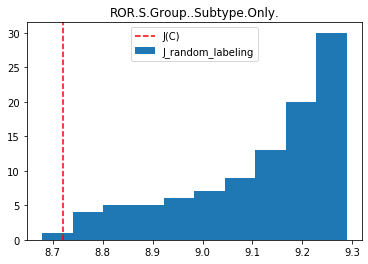

    ID_number ROR.S.Group..Subtype.Only.
0   SCAN_0192                          0
1   SCAN_0231                          0
2   SCAN_0471                          0
3   SCAN_0240                          0
4   SCAN_0312                          0
5   SCAN_0469                          1
6   SCAN_0126                          1
7   SCAN_0265                          1
8   SCAN_0089                          1
9   SCAN_0307                          1
10  SCAN_0144                          2
11  SCAN_0117                          2
12  SCAN_0128                          2
13  SCAN_0150                          2
14  SCAN_0086                          2
torch.Size([128, 2, 2])
J_C:  9.039748833780473
mean hist:  8.957804963293169
-0.08194387048730434


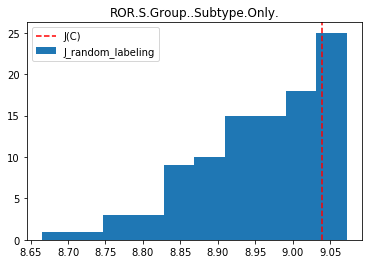

    ID_number ROR.S.Group..Subtype.Only.
0   SCAN_0224                          0
1   SCAN_0225                          0
2   SCAN_0167                          0
3   SCAN_0191                          0
4   SCAN_0251                          0
5   SCAN_0148                          1
6   SCAN_0252                          1
7   SCAN_0084                          1
8   SCAN_0275                          1
9   SCAN_0075                          1
10  SCAN_0313                          2
11  SCAN_0323                          2
12  SCAN_0150                          2
13  SCAN_0156                          2
14  SCAN_0157                          2
torch.Size([128, 2, 2])
J_C:  8.163987845677749
mean hist:  8.28043076210075
0.11644291642300075


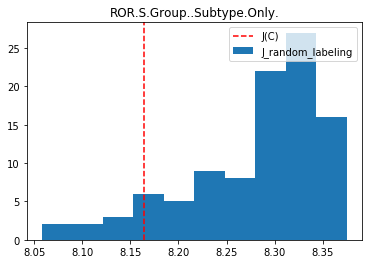

    ID_number ROR.S.Group..Subtype.Only.
0   SCAN_0259                          0
1   SCAN_0250                          0
2   SCAN_0310                          0
3   SCAN_0189                          0
4   SCAN_0263                          0
5   SCAN_0062                          1
6   SCAN_0160                          1
7   SCAN_0281                          1
8   SCAN_0127                          1
9   SCAN_0102                          1
10  SCAN_0142                          2
11  SCAN_0063                          2
12  SCAN_0156                          2
13  SCAN_0114                          2
14  SCAN_0145                          2
torch.Size([128, 2, 2])
J_C:  7.797377276738485
mean hist:  7.873729195222854
0.07635191848436929


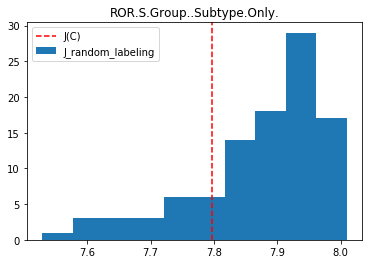

In [83]:
label = 'ROR.S.Group..Subtype.Only.'
for i in range(10):
    sampled_df = get_dataset_ROR(label, i)
    print(sampled_df)
    dataset = BiopsyDataset100("/storage/Chloe/zoom_20_512", sampled_df, label, transform=transform)
    distance, mean, percentage = binning_eval(dataset, sampled_df, encoder, label)
    new_row = {'Label': label, 'Encoder': '512', 'Distance': distance, 'Mean of distribution': mean, "Percentage": percentage}
    df_results = df_results.append(new_row, ignore_index=True)

    ID_number ROR.P.Group..Subtype...Proliferation.
0   SCAN_0203                                     0
1   SCAN_0208                                     0
2   SCAN_0308                                     0
3   SCAN_0470                                     0
4   SCAN_0329                                     0
5   SCAN_0124                                     1
6   SCAN_0210                                     1
7   SCAN_0461                                     1
8   SCAN_0464                                     1
9   SCAN_0314                                     1
10  SCAN_0074                                     2
11  SCAN_0092                                     2
12  SCAN_0063                                     2
13  SCAN_0072                                     2
14  SCAN_0109                                     2
torch.Size([128, 2, 2])
J_C:  8.365550879743838
mean hist:  8.525438924799008
0.15988804505517074


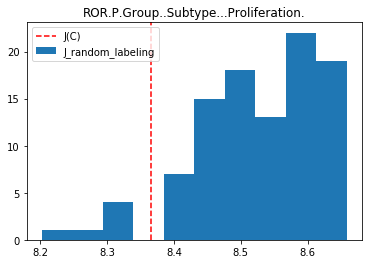

    ID_number ROR.P.Group..Subtype...Proliferation.
0   SCAN_0299                                     0
1   SCAN_0207                                     0
2   SCAN_0277                                     0
3   SCAN_0236                                     0
4   SCAN_0206                                     0
5   SCAN_0161                                     1
6   SCAN_0301                                     1
7   SCAN_0105                                     1
8   SCAN_0317                                     1
9   SCAN_0254                                     1
10  SCAN_0123                                     2
11  SCAN_0275                                     2
12  SCAN_0194                                     2
13  SCAN_0323                                     2
14  SCAN_0068                                     2
torch.Size([128, 2, 2])
J_C:  7.548615594314317
mean hist:  7.590875334868997
0.04225974055468029


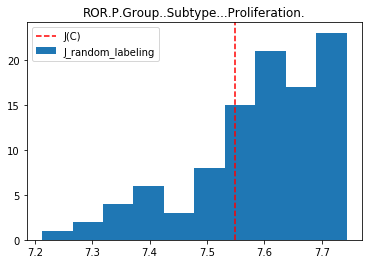

    ID_number ROR.P.Group..Subtype...Proliferation.
0   SCAN_0234                                     0
1   SCAN_0217                                     0
2   SCAN_0470                                     0
3   SCAN_0256                                     0
4   SCAN_0460                                     0
5   SCAN_0174                                     1
6   SCAN_0104                                     1
7   SCAN_0173                                     1
8   SCAN_0161                                     1
9   SCAN_0101                                     1
10  SCAN_0289                                     2
11  SCAN_0144                                     2
12  SCAN_0286                                     2
13  SCAN_0093                                     2
14  SCAN_0327                                     2
torch.Size([128, 2, 2])
J_C:  7.6143295208613075
mean hist:  7.61607348785003
0.0017439669887222564


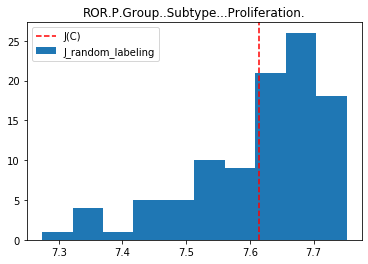

    ID_number ROR.P.Group..Subtype...Proliferation.
0   SCAN_0462                                     0
1   SCAN_0163                                     0
2   SCAN_0295                                     0
3   SCAN_0192                                     0
4   SCAN_0272                                     0
5   SCAN_0260                                     1
6   SCAN_0251                                     1
7   SCAN_0221                                     1
8   SCAN_0213                                     1
9   SCAN_0110                                     1
10  SCAN_0463                                     2
11  SCAN_0133                                     2
12  SCAN_0056                                     2
13  SCAN_0073                                     2
14  SCAN_0082                                     2
torch.Size([128, 2, 2])
J_C:  7.462614076137543
mean hist:  7.699082471907933
0.23646839577039014


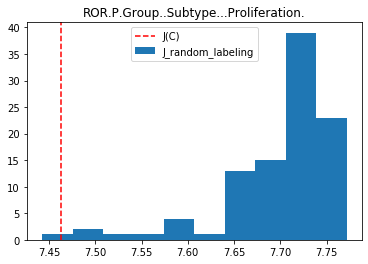

    ID_number ROR.P.Group..Subtype...Proliferation.
0   SCAN_0197                                     0
1   SCAN_0225                                     0
2   SCAN_0214                                     0
3   SCAN_0196                                     0
4   SCAN_0293                                     0
5   SCAN_0231                                     1
6   SCAN_0105                                     1
7   SCAN_0226                                     1
8   SCAN_0240                                     1
9   SCAN_0188                                     1
10  SCAN_0156                                     2
11  SCAN_0054                                     2
12  SCAN_0125                                     2
13  SCAN_0130                                     2
14  SCAN_0232                                     2
torch.Size([128, 2, 2])
J_C:  7.45083815908432
mean hist:  7.432346312292417
-0.0184918467919033


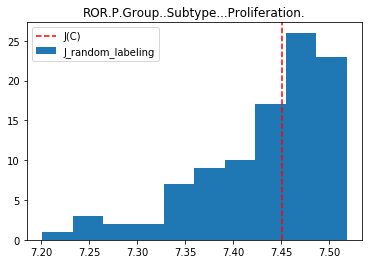

    ID_number ROR.P.Group..Subtype...Proliferation.
0   SCAN_0315                                     0
1   SCAN_0319                                     0
2   SCAN_0277                                     0
3   SCAN_0158                                     0
4   SCAN_0218                                     0
5   SCAN_0058                                     1
6   SCAN_0185                                     1
7   SCAN_0466                                     1
8   SCAN_0227                                     1
9   SCAN_0101                                     1
10  SCAN_0128                                     2
11  SCAN_0108                                     2
12  SCAN_0143                                     2
13  SCAN_0268                                     2
14  SCAN_0123                                     2
torch.Size([128, 2, 2])
J_C:  8.64955830994299
mean hist:  8.66030964582896
0.010751335885970548


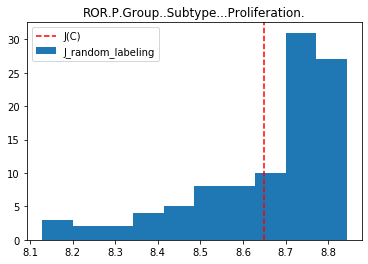

    ID_number ROR.P.Group..Subtype...Proliferation.
0   SCAN_0459                                     0
1   SCAN_0158                                     0
2   SCAN_0311                                     0
3   SCAN_0211                                     0
4   SCAN_0207                                     0
5   SCAN_0104                                     1
6   SCAN_0285                                     1
7   SCAN_0091                                     1
8   SCAN_0188                                     1
9   SCAN_0310                                     1
10  SCAN_0136                                     2
11  SCAN_0255                                     2
12  SCAN_0113                                     2
13  SCAN_0258                                     2
14  SCAN_0076                                     2
torch.Size([128, 2, 2])
J_C:  7.860523661851882
mean hist:  7.844057107016243
-0.01646655483563908


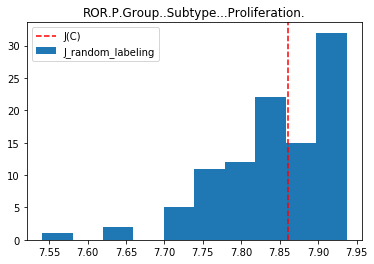

    ID_number ROR.P.Group..Subtype...Proliferation.
0   SCAN_0204                                     0
1   SCAN_0163                                     0
2   SCAN_0234                                     0
3   SCAN_0296                                     0
4   SCAN_0182                                     0
5   SCAN_0322                                     1
6   SCAN_0161                                     1
7   SCAN_0213                                     1
8   SCAN_0171                                     1
9   SCAN_0324                                     1
10  SCAN_0095                                     2
11  SCAN_0327                                     2
12  SCAN_0080                                     2
13  SCAN_0083                                     2
14  SCAN_0077                                     2
torch.Size([128, 2, 2])
J_C:  6.6182805658741435
mean hist:  6.7965515372538094
0.17827097137966597


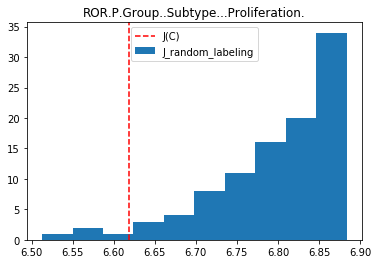

    ID_number ROR.P.Group..Subtype...Proliferation.
0   SCAN_0163                                     0
1   SCAN_0159                                     0
2   SCAN_0299                                     0
3   SCAN_0262                                     0
4   SCAN_0192                                     0
5   SCAN_0171                                     1
6   SCAN_0221                                     1
7   SCAN_0464                                     1
8   SCAN_0310                                     1
9   SCAN_0104                                     1
10  SCAN_0265                                     2
11  SCAN_0142                                     2
12  SCAN_0255                                     2
13  SCAN_0270                                     2
14  SCAN_0118                                     2
torch.Size([128, 2, 2])
J_C:  6.324292582829793
mean hist:  6.430346601893903
0.10605401906410972


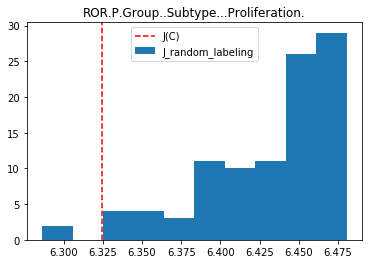

    ID_number ROR.P.Group..Subtype...Proliferation.
0   SCAN_0296                                     0
1   SCAN_0300                                     0
2   SCAN_0319                                     0
3   SCAN_0191                                     0
4   SCAN_0211                                     0
5   SCAN_0105                                     1
6   SCAN_0466                                     1
7   SCAN_0137                                     1
8   SCAN_0190                                     1
9   SCAN_0455                                     1
10  SCAN_0269                                     2
11  SCAN_0056                                     2
12  SCAN_0095                                     2
13  SCAN_0074                                     2
14  SCAN_0089                                     2
torch.Size([128, 2, 2])
J_C:  8.007576687830168
mean hist:  8.208421997960125
0.20084531012995654


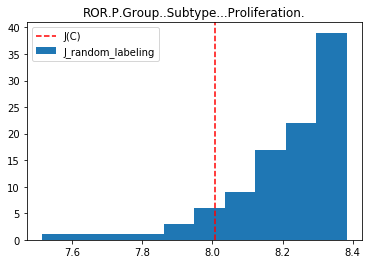

In [84]:
label = 'ROR.P.Group..Subtype...Proliferation.'
for i in range(10):
    sampled_df = get_dataset_ROR(label, i)
    print(sampled_df)
    dataset = BiopsyDataset100("/storage/Chloe/zoom_20_512", sampled_df, label, transform=transform)
    distance, mean, percentage = binning_eval(dataset, sampled_df, encoder, label)
    new_row = {'Label': label, 'Encoder': '512', 'Distance': distance, 'Mean of distribution': mean, "Percentage": percentage}
    df_results = df_results.append(new_row, ignore_index=True)

   ID_number PR status
0  SCAN_0103         0
1  SCAN_0060         0
2  SCAN_0090         0
3  SCAN_0156         0
4  SCAN_0130         0
5  SCAN_0057         1
6  SCAN_0095         1
7  SCAN_0126         1
8  SCAN_0077         1
9  SCAN_0074         1
torch.Size([128, 2, 2])
J_C:  8.958199977304377
mean hist:  9.086758287135494
0.12855830983111716


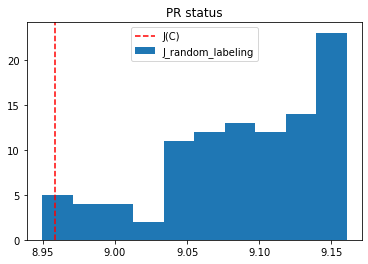

   ID_number PR status
0  SCAN_0065         0
1  SCAN_0132         0
2  SCAN_0082         0
3  SCAN_0103         0
4  SCAN_0061         0
5  SCAN_0106         1
6  SCAN_0096         1
7  SCAN_0112         1
8  SCAN_0131         1
9  SCAN_0155         1
torch.Size([128, 2, 2])
J_C:  8.689390909206402
mean hist:  8.610863400978129
-0.07852750822827304


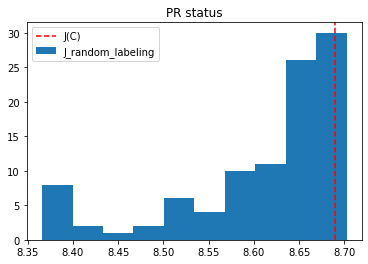

   ID_number PR status
0  SCAN_0092         0
1  SCAN_0067         0
2  SCAN_0130         0
3  SCAN_0056         0
4  SCAN_0103         0
5  SCAN_0101         1
6  SCAN_0093         1
7  SCAN_0125         1
8  SCAN_0085         1
9  SCAN_0077         1
torch.Size([128, 2, 2])
J_C:  7.807356696034319
mean hist:  7.769301104910573
-0.03805559112374546


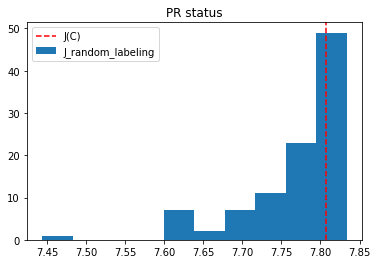

   ID_number PR status
0  SCAN_0119         0
1  SCAN_0061         0
2  SCAN_0060         0
3  SCAN_0144         0
4  SCAN_0067         0
5  SCAN_0129         1
6  SCAN_0085         1
7  SCAN_0058         1
8  SCAN_0070         1
9  SCAN_0088         1
torch.Size([128, 2, 2])
J_C:  8.1465982419916
mean hist:  8.150307087654335
0.0037088456627358823


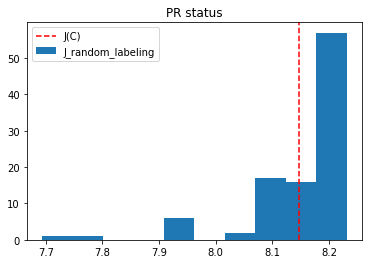

   ID_number PR status
0  SCAN_0082         0
1  SCAN_0065         0
2  SCAN_0150         0
3  SCAN_0119         0
4  SCAN_0067         0
5  SCAN_0110         1
6  SCAN_0075         1
7  SCAN_0074         1
8  SCAN_0124         1
9  SCAN_0131         1
torch.Size([128, 2, 2])
J_C:  8.161757810480713
mean hist:  8.2670742759743
0.10531646549358697


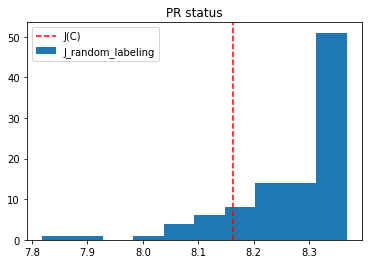

   ID_number PR status
0  SCAN_0061         0
1  SCAN_0060         0
2  SCAN_0114         0
3  SCAN_0103         0
4  SCAN_0069         0
5  SCAN_0106         1
6  SCAN_0102         1
7  SCAN_0122         1
8  SCAN_0148         1
9  SCAN_0125         1
torch.Size([128, 2, 2])
J_C:  8.24601381969452
mean hist:  8.279026834948064
0.03301301525354461


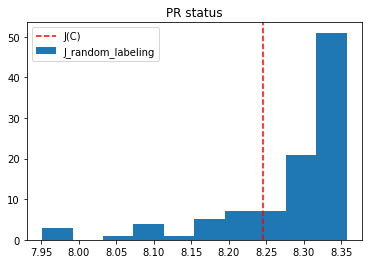

   ID_number PR status
0  SCAN_0069         0
1  SCAN_0144         0
2  SCAN_0061         0
3  SCAN_0114         0
4  SCAN_0090         0
5  SCAN_0157         1
6  SCAN_0085         1
7  SCAN_0141         1
8  SCAN_0078         1
9  SCAN_0140         1
torch.Size([128, 2, 2])
J_C:  9.241221497535706
mean hist:  9.124029339540005
-0.11719215799570115


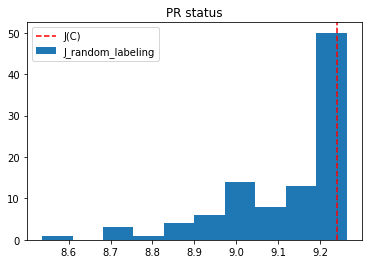

   ID_number PR status
0  SCAN_0060         0
1  SCAN_0061         0
2  SCAN_0069         0
3  SCAN_0156         0
4  SCAN_0056         0
5  SCAN_0081         1
6  SCAN_0143         1
7  SCAN_0154         1
8  SCAN_0135         1
9  SCAN_0140         1
torch.Size([128, 2, 2])
J_C:  9.699545716285705
mean hist:  9.57679821261406
-0.12274750367164522


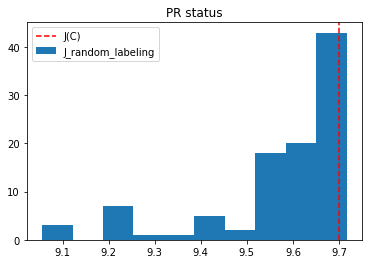

   ID_number PR status
0  SCAN_0130         0
1  SCAN_0082         0
2  SCAN_0144         0
3  SCAN_0114         0
4  SCAN_0067         0
5  SCAN_0087         1
6  SCAN_0072         1
7  SCAN_0055         1
8  SCAN_0073         1
9  SCAN_0097         1
torch.Size([128, 2, 2])
J_C:  8.068013587236404
mean hist:  7.968746999571322
-0.099266587665082


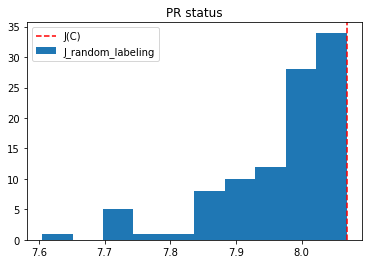

   ID_number PR status
0  SCAN_0065         0
1  SCAN_0082         0
2  SCAN_0086         0
3  SCAN_0069         0
4  SCAN_0144         0
5  SCAN_0107         1
6  SCAN_0102         1
7  SCAN_0141         1
8  SCAN_0112         1
9  SCAN_0142         1
torch.Size([128, 2, 2])
J_C:  8.903247672319413
mean hist:  8.876175833556651
-0.027071838762761757


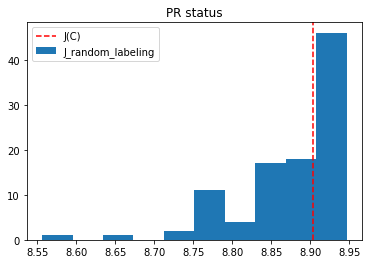

In [85]:
label = 'PR status'
for i in range(10):
    sampled_df = get_dataset_pos_neg(label, i)
    print(sampled_df)
    dataset = BiopsyDataset100("/storage/Chloe/zoom_20_512", sampled_df, label, transform=transform)
    distance, mean, percentage = binning_eval(dataset, sampled_df, encoder, label)
    new_row = {'Label': label, 'Encoder': '512', 'Distance': distance, 'Mean of distribution': mean, "Percentage": percentage}
    df_results = df_results.append(new_row, ignore_index=True)
    

   ID_number PAM50 subtype
0  SCAN_0315             A
1  SCAN_0460             A
2  SCAN_0257             A
3  SCAN_0324             A
4  SCAN_0468             A
5  SCAN_0318             B
6  SCAN_0286             B
7  SCAN_0289             B
8  SCAN_0269             B
9  SCAN_0253             B
torch.Size([128, 2, 2])
J_C:  7.867647485971451
mean hist:  8.107542745108606
0.23989525913715504


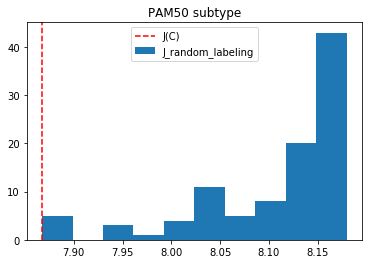

   ID_number PAM50 subtype
0  SCAN_0171             A
1  SCAN_0216             A
2  SCAN_0297             A
3  SCAN_0254             A
4  SCAN_0226             A
5  SCAN_0287             B
6  SCAN_0280             B
7  SCAN_0258             B
8  SCAN_0253             B
9  SCAN_0303             B
torch.Size([128, 2, 2])
J_C:  7.233639737143787
mean hist:  7.216950507869366
-0.01668922927442118


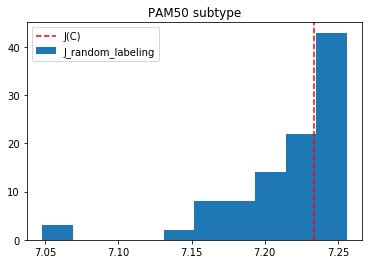

   ID_number PAM50 subtype
0  SCAN_0234             A
1  SCAN_0197             A
2  SCAN_0190             A
3  SCAN_0310             A
4  SCAN_0250             A
5  SCAN_0281             B
6  SCAN_0280             B
7  SCAN_0323             B
8  SCAN_0463             B
9  SCAN_0303             B
torch.Size([128, 2, 2])
J_C:  6.586471300198001
mean hist:  6.583820680312194
-0.0026506198858067265


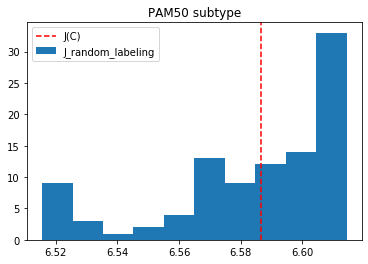

   ID_number PAM50 subtype
0  SCAN_0291             A
1  SCAN_0256             A
2  SCAN_0250             A
3  SCAN_0315             A
4  SCAN_0308             A
5  SCAN_0461             B
6  SCAN_0258             B
7  SCAN_0255             B
8  SCAN_0280             B
9  SCAN_0209             B
torch.Size([128, 2, 2])
J_C:  7.485675174713135
mean hist:  7.463326280117036
-0.022348894596099456


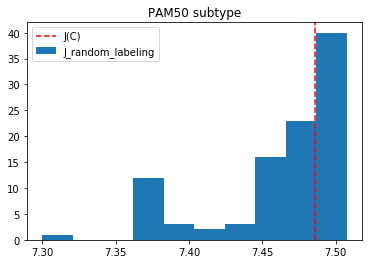

   ID_number PAM50 subtype
0  SCAN_0264             A
1  SCAN_0466             A
2  SCAN_0310             A
3  SCAN_0263             A
4  SCAN_0254             A
5  SCAN_0289             B
6  SCAN_0227             B
7  SCAN_0160             B
8  SCAN_0318             B
9  SCAN_0178             B
torch.Size([128, 2, 2])
J_C:  8.199356227397919
mean hist:  8.20622455019474
0.006868322796821147


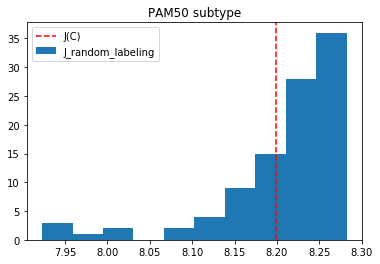

   ID_number PAM50 subtype
0  SCAN_0322             A
1  SCAN_0208             A
2  SCAN_0462             A
3  SCAN_0466             A
4  SCAN_0211             A
5  SCAN_0280             B
6  SCAN_0194             B
7  SCAN_0268             B
8  SCAN_0323             B
9  SCAN_0160             B
torch.Size([128, 2, 2])
J_C:  7.620104581356049
mean hist:  7.656736447868347
0.03663186651229822


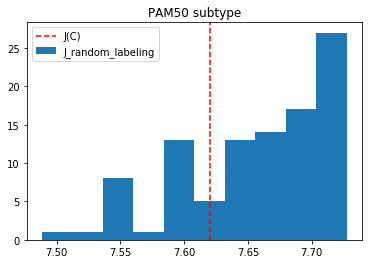

   ID_number PAM50 subtype
0  SCAN_0300             A
1  SCAN_0189             A
2  SCAN_0163             A
3  SCAN_0296             A
4  SCAN_0316             A
5  SCAN_0283             B
6  SCAN_0323             B
7  SCAN_0318             B
8  SCAN_0253             B
9  SCAN_0280             B
torch.Size([128, 2, 2])
J_C:  5.681727839781119
mean hist:  5.705850401004632
0.024122561223513195


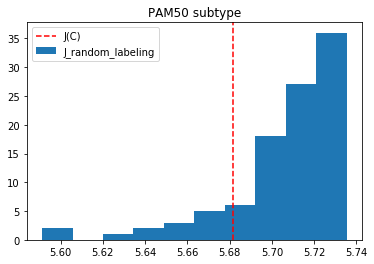

   ID_number PAM50 subtype
0  SCAN_0235             A
1  SCAN_0218             A
2  SCAN_0167             A
3  SCAN_0298             A
4  SCAN_0315             A
5  SCAN_0287             B
6  SCAN_0283             B
7  SCAN_0232             B
8  SCAN_0289             B
9  SCAN_0461             B
torch.Size([128, 2, 2])
J_C:  7.020611059904098
mean hist:  6.957222097902299
-0.06338896200179889


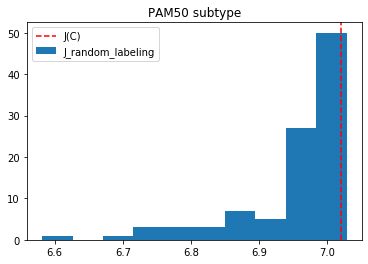

   ID_number PAM50 subtype
0  SCAN_0212             A
1  SCAN_0285             A
2  SCAN_0206             A
3  SCAN_0233             A
4  SCAN_0251             A
5  SCAN_0227             B
6  SCAN_0238             B
7  SCAN_0283             B
8  SCAN_0253             B
9  SCAN_0281             B
torch.Size([128, 2, 2])
J_C:  6.9415943553447725
mean hist:  6.955131831996441
0.013537476651668712


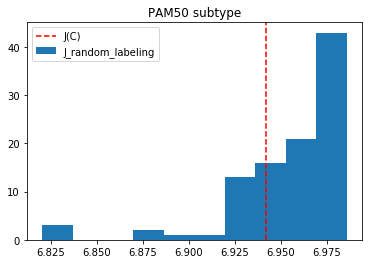

   ID_number PAM50 subtype
0  SCAN_0158             A
1  SCAN_0179             A
2  SCAN_0177             A
3  SCAN_0183             A
4  SCAN_0297             A
5  SCAN_0252             B
6  SCAN_0178             B
7  SCAN_0286             B
8  SCAN_0280             B
9  SCAN_0283             B
torch.Size([128, 2, 2])
J_C:  6.491013538122178
mean hist:  6.5204986274552335
0.029485089333055825


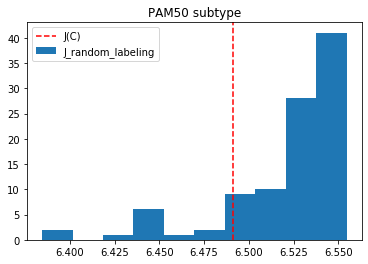

In [86]:
label = 'PAM50 subtype'
for i in range(10):
    sampled_df = get_dataset_PAM50(label, i)
    print(sampled_df)
    dataset = BiopsyDataset100("/storage/Chloe/zoom_20_512", sampled_df, label, transform=transform)
    distance, mean, percentage = binning_eval(dataset, sampled_df, encoder, label)
    new_row = {'Label': label, 'Encoder': '512', 'Distance': distance, 'Mean of distribution': mean, "Percentage": percentage}
    df_results = df_results.append(new_row, ignore_index=True)
    

In [87]:
df_results

,Label,Encoder,Distance,Mean of distribution,Percentage
0,Ki67 (%),No encoder,0.248609,206.088552,63.0
1,Ki67 (%),No encoder,12.491632,203.237264,97.0
2,Ki67 (%),No encoder,-0.270534,206.013481,54.0
3,Ki67 (%),No encoder,11.781205,201.536183,95.0
4,Ki67 (%),No encoder,13.686516,200.189516,100.0
...,...,...,...,...,...
355,PAM50 subtype,512,0.036632,7.656736,73.0
356,PAM50 subtype,512,0.024123,5.705850,84.0
357,PAM50 subtype,512,-0.063389,6.957222,8.0
358,PAM50 subtype,512,0.013537,6.955132,77.0


In [41]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 4, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(4, 8, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 8, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 4, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(4, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid(),    
        )
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [42]:
autoencoder = Autoencoder()

In [43]:
autoencoder.load_state_dict(torch.load('/storage/Chloe/final_model_autoencoder/autoencoder_64*1*1_split41.pth', map_location='cpu'))

<All keys matched successfully>

In [44]:
encoder = autoencoder.encoder

In [45]:
encoder

Sequential(
  (0): Conv2d(3, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(4, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (3): ReLU()
  (4): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (5): ReLU()
  (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (7): ReLU()
  (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (9): ReLU()
  (10): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (11): ReLU()
  (12): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
)

    ID_number Ki67 (%)
0   SCAN_0276        A
1   SCAN_0198        A
2   SCAN_0310        A
3   SCAN_0267        A
4   SCAN_0163        A
5   SCAN_0265        B
6   SCAN_0180        B
7   SCAN_0283        B
8   SCAN_0286        B
9   SCAN_0085        B
10  SCAN_0145        C
11  SCAN_0117        C
12  SCAN_0155        C
13  SCAN_0139        C
14  SCAN_0235        C
torch.Size([64, 1, 1])
J_C:  2.699132849375407
mean hist:  2.8792216689042247
0.18008881952881772


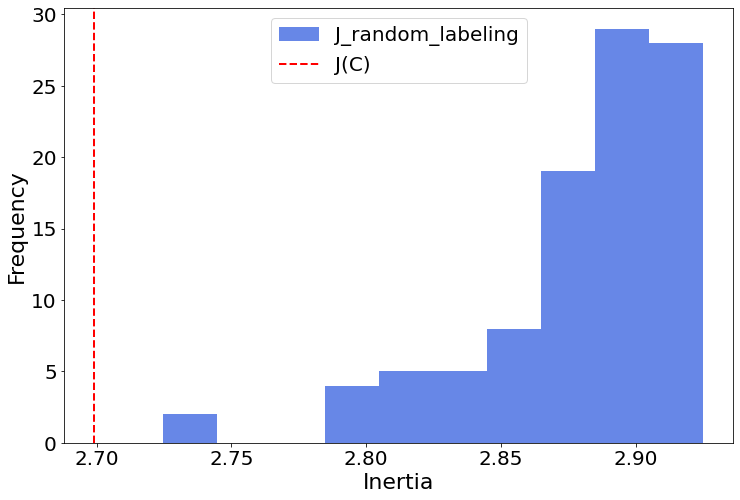

    ID_number Ki67 (%)
0   SCAN_0320        A
1   SCAN_0312        A
2   SCAN_0161        A
3   SCAN_0213        A
4   SCAN_0167        A
5   SCAN_0465        B
6   SCAN_0077        B
7   SCAN_0106        B
8   SCAN_0125        B
9   SCAN_0178        B
10  SCAN_0080        C
11  SCAN_0118        C
12  SCAN_0081        C
13  SCAN_0142        C
14  SCAN_0115        C
torch.Size([64, 1, 1])
J_C:  3.0411454839208587
mean hist:  3.094338140443645
0.053192656522786486


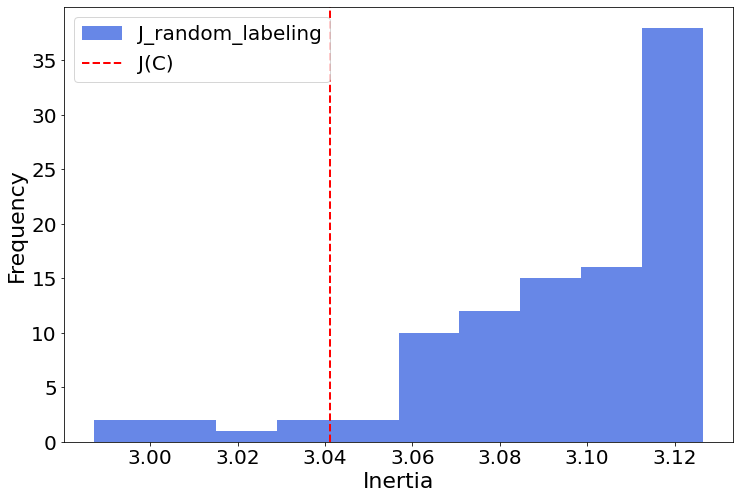

    ID_number Ki67 (%)
0   SCAN_0169        A
1   SCAN_0292        A
2   SCAN_0295        A
3   SCAN_0302        A
4   SCAN_0147        A
5   SCAN_0289        B
6   SCAN_0076        B
7   SCAN_0252        B
8   SCAN_0183        B
9   SCAN_0166        B
10  SCAN_0084        C
11  SCAN_0149        C
12  SCAN_0237        C
13  SCAN_0099        C
14  SCAN_0111        C
torch.Size([64, 1, 1])
J_C:  2.9659865440328916
mean hist:  3.0185796880869074
0.05259314405401572


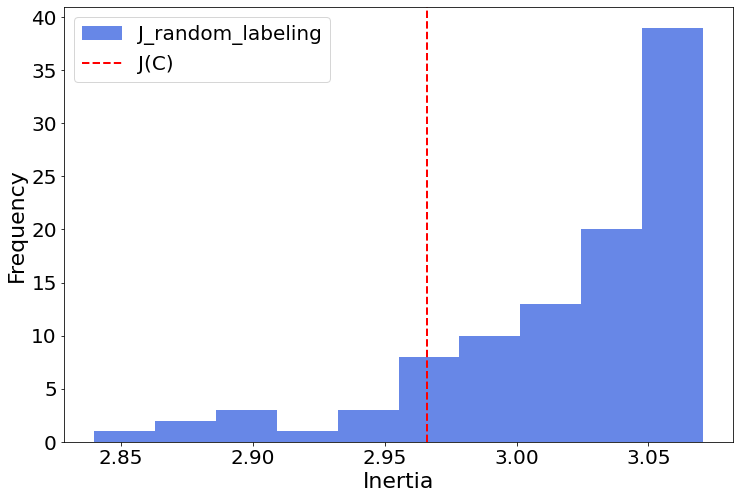

    ID_number Ki67 (%)
0   SCAN_0290        A
1   SCAN_0294        A
2   SCAN_0224        A
3   SCAN_0176        A
4   SCAN_0312        A
5   SCAN_0076        B
6   SCAN_0102        B
7   SCAN_0085        B
8   SCAN_0247        B
9   SCAN_0317        B
10  SCAN_0114        C
11  SCAN_0095        C
12  SCAN_0273        C
13  SCAN_0080        C
14  SCAN_0154        C
torch.Size([64, 1, 1])


KeyboardInterrupt: 

In [46]:
label = 'Ki67 (%)'
for i in range(4, 10):
    sampled_df = get_dataset_continous(label, i)
    print(sampled_df)
    dataset = BiopsyDataset100("/storage/Chloe/zoom_20_512", sampled_df, label, transform=transform)
    distance, mean, percentage = binning_eval(dataset, sampled_df, encoder, label)
    new_row = {'Label': label, 'Encoder': '64', 'Distance': distance, 'Mean of distribution': mean, "Percentage": percentage}
    df_results = df_results.append(new_row, ignore_index=True)

    ID_number TILS (%)
0   SCAN_0067        A
1   SCAN_0271        A
2   SCAN_0255        A
3   SCAN_0102        A
4   SCAN_0305        A
5   SCAN_0108        B
6   SCAN_0232        B
7   SCAN_0247        B
8   SCAN_0188        B
9   SCAN_0099        B
10  SCAN_0203        C
11  SCAN_0118        C
12  SCAN_0170        C
13  SCAN_0128        C
14  SCAN_0086        C
torch.Size([64, 1, 1])
J_C:  3.0102057429949443
mean hist:  2.997112234579325
-0.013093508415619404


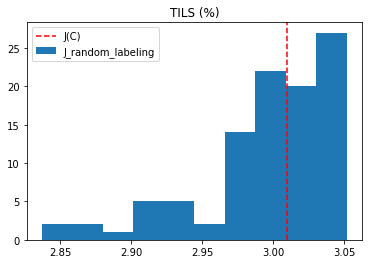

    ID_number TILS (%)
0   SCAN_0266        A
1   SCAN_0223        A
2   SCAN_0324        A
3   SCAN_0197        A
4   SCAN_0260        A
5   SCAN_0275        B
6   SCAN_0113        B
7   SCAN_0133        B
8   SCAN_0312        B
9   SCAN_0058        B
10  SCAN_0228        C
11  SCAN_0156        C
12  SCAN_0144        C
13  SCAN_0313        C
14  SCAN_0105        C
torch.Size([64, 1, 1])
J_C:  3.5924086155891417
mean hist:  3.613205972956816
0.020797357367674074


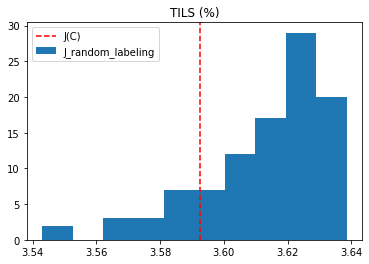

    ID_number TILS (%)
0   SCAN_0237        A
1   SCAN_0211        A
2   SCAN_0180        A
3   SCAN_0079        A
4   SCAN_0160        A
5   SCAN_0091        B
6   SCAN_0216        B
7   SCAN_0248        B
8   SCAN_0099        B
9   SCAN_0157        B
10  SCAN_0321        C
11  SCAN_0217        C
12  SCAN_0162        C
13  SCAN_0175        C
14  SCAN_0457        C
torch.Size([64, 1, 1])
J_C:  3.187077419877052
mean hist:  3.2191386411670835
0.032061221290031305


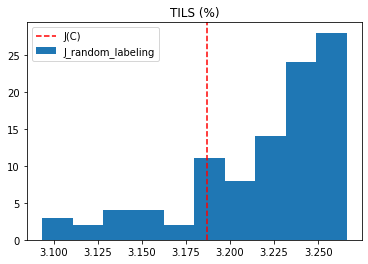

    ID_number TILS (%)
0   SCAN_0253        A
1   SCAN_0194        A
2   SCAN_0064        A
3   SCAN_0130        A
4   SCAN_0327        A
5   SCAN_0471        B
6   SCAN_0281        B
7   SCAN_0301        B
8   SCAN_0164        B
9   SCAN_0328        B
10  SCAN_0297        C
11  SCAN_0177        C
12  SCAN_0263        C
13  SCAN_0103        C
14  SCAN_0150        C
torch.Size([64, 1, 1])
J_C:  2.8580158588449907
mean hist:  2.833305060099875
-0.024710798745115614


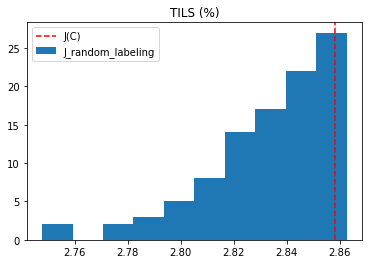

    ID_number TILS (%)
0   SCAN_0093        A
1   SCAN_0467        A
2   SCAN_0306        A
3   SCAN_0084        A
4   SCAN_0064        A
5   SCAN_0304        B
6   SCAN_0164        B
7   SCAN_0290        B
8   SCAN_0136        B
9   SCAN_0291        B
10  SCAN_0132        C
11  SCAN_0268        C
12  SCAN_0150        C
13  SCAN_0313        C
14  SCAN_0154        C
torch.Size([64, 1, 1])
J_C:  3.346565909420378
mean hist:  3.402128085004977
0.05556217558459897


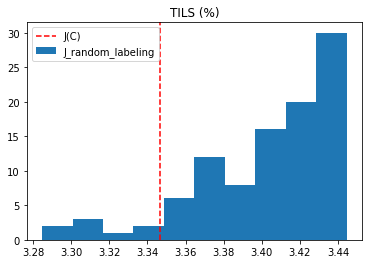

    ID_number TILS (%)
0   SCAN_0289        A
1   SCAN_0293        A
2   SCAN_0169        A
3   SCAN_0192        A
4   SCAN_0088        A
5   SCAN_0136        B
6   SCAN_0257        B
7   SCAN_0328        B
8   SCAN_0147        B
9   SCAN_0078        B
10  SCAN_0460        C
11  SCAN_0263        C
12  SCAN_0109        C
13  SCAN_0321        C
14  SCAN_0228        C
torch.Size([64, 1, 1])
J_C:  3.0158281610144595
mean hist:  3.126872682922731
0.11104452190827141


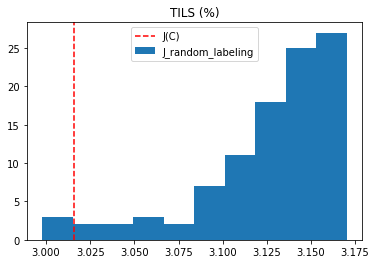

    ID_number TILS (%)
0   SCAN_0122        A
1   SCAN_0195        A
2   SCAN_0260        A
3   SCAN_0055        A
4   SCAN_0084        A
5   SCAN_0136        B
6   SCAN_0095        B
7   SCAN_0233        B
8   SCAN_0091        B
9   SCAN_0190        B
10  SCAN_0226        C
11  SCAN_0109        C
12  SCAN_0118        C
13  SCAN_0459        C
14  SCAN_0297        C
torch.Size([64, 1, 1])
J_C:  3.451124052961667
mean hist:  3.4028552009073887
-0.048268852054278444


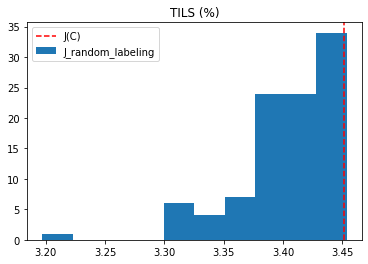

    ID_number TILS (%)
0   SCAN_0208        A
1   SCAN_0191        A
2   SCAN_0189        A
3   SCAN_0158        A
4   SCAN_0149        A
5   SCAN_0301        B
6   SCAN_0470        B
7   SCAN_0287        B
8   SCAN_0468        B
9   SCAN_0070        B
10  SCAN_0288        C
11  SCAN_0273        C
12  SCAN_0217        C
13  SCAN_0131        C
14  SCAN_0109        C
torch.Size([64, 1, 1])
J_C:  3.3135293900966643
mean hist:  3.33730161516408
0.023772225067415942


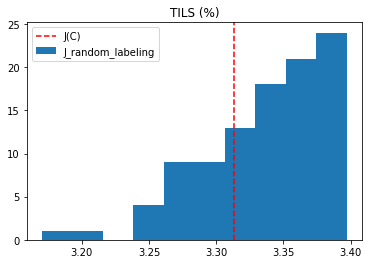

    ID_number TILS (%)
0   SCAN_0158        A
1   SCAN_0197        A
2   SCAN_0183        A
3   SCAN_0458        A
4   SCAN_0062        A
5   SCAN_0198        B
6   SCAN_0135        B
7   SCAN_0087        B
8   SCAN_0095        B
9   SCAN_0106        B
10  SCAN_0285        C
11  SCAN_0162        C
12  SCAN_0228        C
13  SCAN_0170        C
14  SCAN_0150        C
torch.Size([64, 1, 1])
J_C:  3.0686582777638844
mean hist:  3.0865669871499337
0.01790870938604927


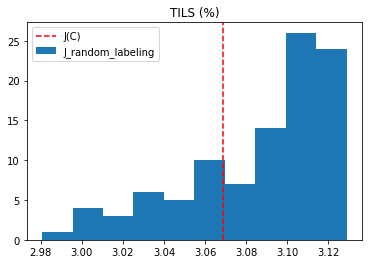

    ID_number TILS (%)
0   SCAN_0192        A
1   SCAN_0061        A
2   SCAN_0112        A
3   SCAN_0467        A
4   SCAN_0071        A
5   SCAN_0326        B
6   SCAN_0291        B
7   SCAN_0114        B
8   SCAN_0233        B
9   SCAN_0276        B
10  SCAN_0265        C
11  SCAN_0263        C
12  SCAN_0213        C
13  SCAN_0132        C
14  SCAN_0056        C
torch.Size([64, 1, 1])
J_C:  3.12248982867851
mean hist:  3.1459093682590207
0.023419539580510573


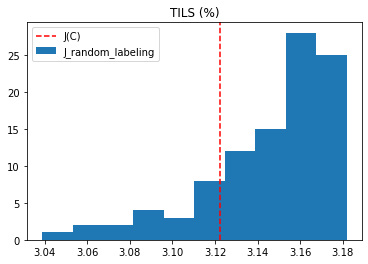

In [94]:
label = 'TILS (%)'
for i in range(10):
    sampled_df = get_dataset_continous(label, i)
    print(sampled_df)
    dataset = BiopsyDataset100("/storage/Chloe/zoom_20_512", sampled_df, label, transform=transform)
    distance, mean, percentage = binning_eval(dataset, sampled_df, encoder, label)
    new_row = {'Label': label, 'Encoder': '64', 'Distance': distance, 'Mean of distribution': mean, "Percentage": percentage}
    df_results = df_results.append(new_row, ignore_index=True)

    ID_number MYC
0   SCAN_0056   A
1   SCAN_0089   A
2   SCAN_0290   A
3   SCAN_0262   A
4   SCAN_0174   A
5   SCAN_0099   B
6   SCAN_0092   B
7   SCAN_0071   B
8   SCAN_0286   B
9   SCAN_0323   B
10  SCAN_0192   C
11  SCAN_0205   C
12  SCAN_0471   C
13  SCAN_0097   C
14  SCAN_0199   C
torch.Size([64, 1, 1])
J_C:  3.0282138525644937
mean hist:  3.0081516179752352
-0.020062234589258487


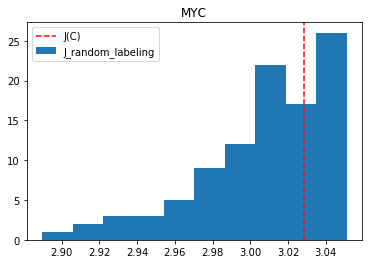

    ID_number MYC
0   SCAN_0296   A
1   SCAN_0202   A
2   SCAN_0266   A
3   SCAN_0292   A
4   SCAN_0325   A
5   SCAN_0096   B
6   SCAN_0322   B
7   SCAN_0065   B
8   SCAN_0318   B
9   SCAN_0204   B
10  SCAN_0198   C
11  SCAN_0180   C
12  SCAN_0157   C
13  SCAN_0197   C
14  SCAN_0123   C
torch.Size([64, 1, 1])
J_C:  3.0247117819388705
mean hist:  3.009875054290692
-0.01483672764817845


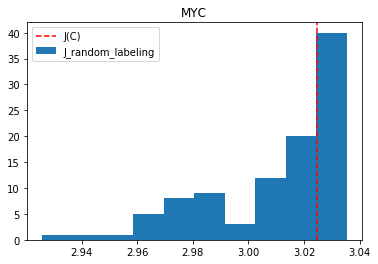

    ID_number MYC
0   SCAN_0293   A
1   SCAN_0111   A
2   SCAN_0251   A
3   SCAN_0056   A
4   SCAN_0119   A
5   SCAN_0115   B
6   SCAN_0323   B
7   SCAN_0063   B
8   SCAN_0173   B
9   SCAN_0465   B
10  SCAN_0209   C
11  SCAN_0098   C
12  SCAN_0205   C
13  SCAN_0129   C
14  SCAN_0219   C
torch.Size([64, 1, 1])
J_C:  3.5294277669990075
mean hist:  3.4690321408738747
-0.06039562612513283


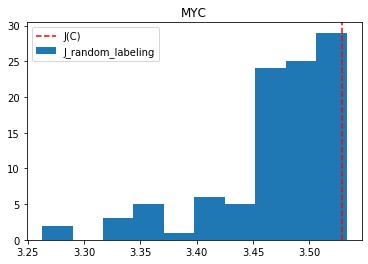

    ID_number MYC
0   SCAN_0215   A
1   SCAN_0161   A
2   SCAN_0457   A
3   SCAN_0468   A
4   SCAN_0257   A
5   SCAN_0115   B
6   SCAN_0065   B
7   SCAN_0216   B
8   SCAN_0126   B
9   SCAN_0162   B
10  SCAN_0235   C
11  SCAN_0217   C
12  SCAN_0137   C
13  SCAN_0462   C
14  SCAN_0134   C
torch.Size([64, 1, 1])
J_C:  3.634817002534866
mean hist:  3.6103457010324798
-0.0244713015023863


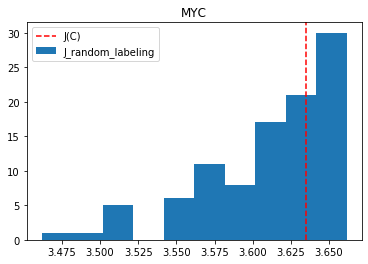

    ID_number MYC
0   SCAN_0089   A
1   SCAN_0316   A
2   SCAN_0251   A
3   SCAN_0085   A
4   SCAN_0290   A
5   SCAN_0258   B
6   SCAN_0173   B
7   SCAN_0272   B
8   SCAN_0274   B
9   SCAN_0090   B
10  SCAN_0231   C
11  SCAN_0058   C
12  SCAN_0195   C
13  SCAN_0200   C
14  SCAN_0157   C
torch.Size([64, 1, 1])
J_C:  2.998446078003049
mean hist:  2.954111856716803
-0.04433422128624587


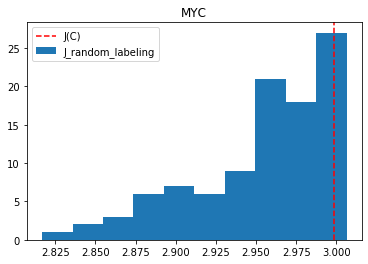

    ID_number MYC
0   SCAN_0257   A
1   SCAN_0253   A
2   SCAN_0295   A
3   SCAN_0298   A
4   SCAN_0232   A
5   SCAN_0272   B
6   SCAN_0065   B
7   SCAN_0122   B
8   SCAN_0322   B
9   SCAN_0310   B
10  SCAN_0211   C
11  SCAN_0196   C
12  SCAN_0124   C
13  SCAN_0195   C
14  SCAN_0315   C
torch.Size([64, 1, 1])
J_C:  2.8800942582289375
mean hist:  2.8401133212826646
-0.039980936946272916


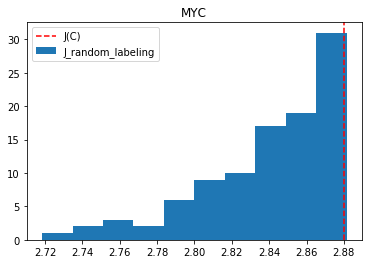

    ID_number MYC
0   SCAN_0291   A
1   SCAN_0109   A
2   SCAN_0119   A
3   SCAN_0141   A
4   SCAN_0054   A
5   SCAN_0281   B
6   SCAN_0077   B
7   SCAN_0248   B
8   SCAN_0181   B
9   SCAN_0310   B
10  SCAN_0139   C
11  SCAN_0287   C
12  SCAN_0222   C
13  SCAN_0157   C
14  SCAN_0170   C
torch.Size([64, 1, 1])
J_C:  2.9927420784145915
mean hist:  3.0031980535284055
0.01045597511381402


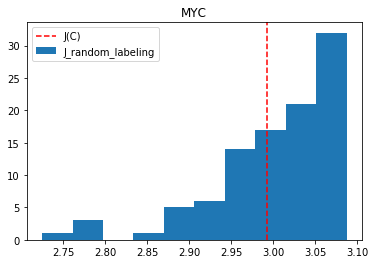

    ID_number MYC
0   SCAN_0106   A
1   SCAN_0118   A
2   SCAN_0320   A
3   SCAN_0296   A
4   SCAN_0253   A
5   SCAN_0077   B
6   SCAN_0100   B
7   SCAN_0090   B
8   SCAN_0145   B
9   SCAN_0307   B
10  SCAN_0194   C
11  SCAN_0178   C
12  SCAN_0193   C
13  SCAN_0200   C
14  SCAN_0170   C
torch.Size([64, 1, 1])
J_C:  2.800775080622936
mean hist:  2.882147747930986
0.0813726673080497


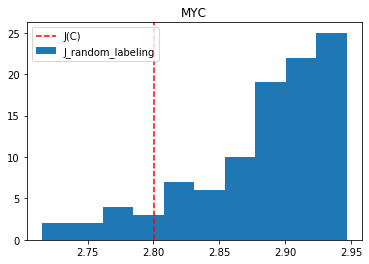

    ID_number MYC
0   SCAN_0251   A
1   SCAN_0202   A
2   SCAN_0296   A
3   SCAN_0461   A
4   SCAN_0277   A
5   SCAN_0216   B
6   SCAN_0204   B
7   SCAN_0260   B
8   SCAN_0062   B
9   SCAN_0258   B
10  SCAN_0163   C
11  SCAN_0177   C
12  SCAN_0188   C
13  SCAN_0205   C
14  SCAN_0460   C
torch.Size([64, 1, 1])
J_C:  2.770231674364058
mean hist:  2.8158201472797635
0.04558847291570567


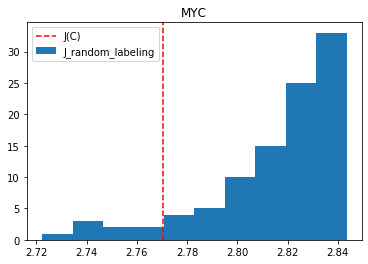

    ID_number MYC
0   SCAN_0268   A
1   SCAN_0136   A
2   SCAN_0292   A
3   SCAN_0317   A
4   SCAN_0319   A
5   SCAN_0084   B
6   SCAN_0322   B
7   SCAN_0162   B
8   SCAN_0328   B
9   SCAN_0263   B
10  SCAN_0165   C
11  SCAN_0132   C
12  SCAN_0156   C
13  SCAN_0113   C
14  SCAN_0167   C
torch.Size([64, 1, 1])
J_C:  3.0131809441397723
mean hist:  2.985190792686778
-0.02799015145299455


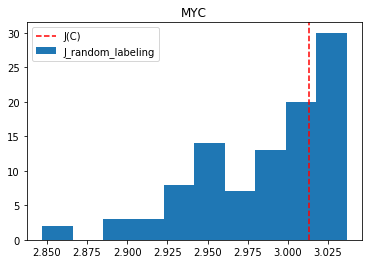

In [95]:
label = 'MYC'
for i in range(10):
    sampled_df = get_dataset_continous(label, i)
    print(sampled_df)
    dataset = BiopsyDataset100("/storage/Chloe/zoom_20_512", sampled_df, label, transform=transform)
    distance, mean, percentage = binning_eval(dataset, sampled_df, encoder, label)
    new_row = {'Label': label, 'Encoder': '64', 'Distance': distance, 'Mean of distribution': mean, "Percentage": percentage}
    df_results = df_results.append(new_row, ignore_index=True)

    ID_number FOXA1
0   SCAN_0070     A
1   SCAN_0143     A
2   SCAN_0182     A
3   SCAN_0165     A
4   SCAN_0237     A
5   SCAN_0089     B
6   SCAN_0085     B
7   SCAN_0069     B
8   SCAN_0280     B
9   SCAN_0298     B
10  SCAN_0290     C
11  SCAN_0316     C
12  SCAN_0471     C
13  SCAN_0078     C
14  SCAN_0307     C
torch.Size([64, 1, 1])
J_C:  3.1396713715700244
mean hist:  3.1142975760583793
-0.025373795511645092


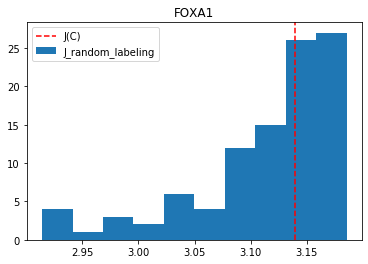

    ID_number FOXA1
0   SCAN_0190     A
1   SCAN_0241     A
2   SCAN_0167     A
3   SCAN_0184     A
4   SCAN_0216     A
5   SCAN_0087     B
6   SCAN_0297     B
7   SCAN_0057     B
8   SCAN_0292     B
9   SCAN_0188     B
10  SCAN_0306     C
11  SCAN_0278     C
12  SCAN_0111     C
13  SCAN_0304     C
14  SCAN_0088     C
torch.Size([64, 1, 1])
J_C:  2.7835903894106546
mean hist:  2.7959797618186473
0.01238937240799265


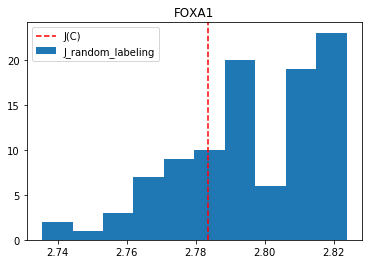

    ID_number FOXA1
0   SCAN_0186     A
1   SCAN_0267     A
2   SCAN_0326     A
3   SCAN_0070     A
4   SCAN_0276     A
5   SCAN_0116     B
6   SCAN_0298     B
7   SCAN_0056     B
8   SCAN_0466     B
9   SCAN_0329     B
10  SCAN_0322     C
11  SCAN_0079     C
12  SCAN_0316     C
13  SCAN_0091     C
14  SCAN_0467     C
torch.Size([64, 1, 1])
J_C:  3.112698333075716
mean hist:  3.161282682002306
0.04858434892659025


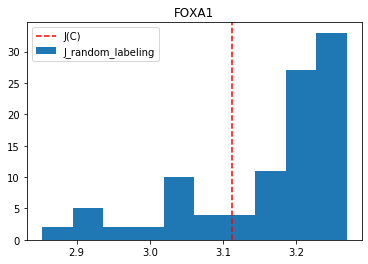

    ID_number FOXA1
0   SCAN_0469     A
1   SCAN_0235     A
2   SCAN_0225     A
3   SCAN_0234     A
4   SCAN_0163     A
5   SCAN_0116     B
6   SCAN_0057     B
7   SCAN_0204     B
8   SCAN_0131     B
9   SCAN_0458     B
10  SCAN_0213     C
11  SCAN_0462     C
12  SCAN_0099     C
13  SCAN_0253     C
14  SCAN_0098     C
torch.Size([64, 1, 1])
J_C:  3.136552907903989
mean hist:  3.161491372637351
0.024938464733362142


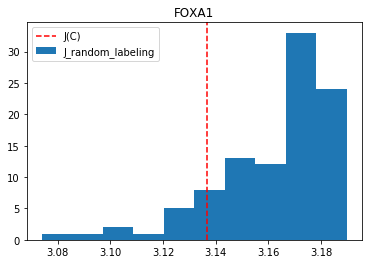

    ID_number FOXA1
0   SCAN_0143     A
1   SCAN_0207     A
2   SCAN_0326     A
3   SCAN_0132     A
4   SCAN_0182     A
5   SCAN_0246     B
6   SCAN_0466     B
7   SCAN_0272     B
8   SCAN_0274     B
9   SCAN_0084     B
10  SCAN_0193     C
11  SCAN_0058     C
12  SCAN_0299     C
13  SCAN_0310     C
14  SCAN_0111     C
torch.Size([64, 1, 1])
J_C:  3.118134048320676
mean hist:  3.094211908449046
-0.023922139871630055


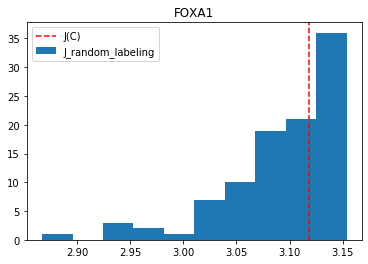

    ID_number FOXA1
0   SCAN_0163     A
1   SCAN_0460     A
2   SCAN_0189     A
3   SCAN_0196     A
4   SCAN_0470     A
5   SCAN_0272     B
6   SCAN_0057     B
7   SCAN_0130     B
8   SCAN_0297     B
9   SCAN_0287     B
10  SCAN_0325     C
11  SCAN_0301     C
12  SCAN_0090     C
13  SCAN_0299     C
14  SCAN_0157     C
torch.Size([64, 1, 1])
J_C:  2.8891805931131045
mean hist:  2.8651211244100327
-0.02405946870307174


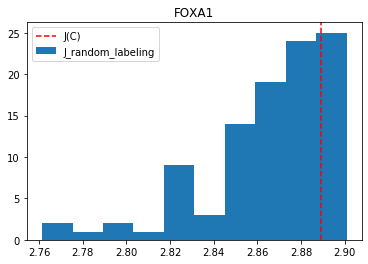

    ID_number FOXA1
0   SCAN_0183     A
1   SCAN_0260     A
2   SCAN_0276     A
3   SCAN_0305     A
4   SCAN_0064     A
5   SCAN_0275     B
6   SCAN_0076     B
7   SCAN_0148     B
8   SCAN_0164     B
9   SCAN_0287     B
10  SCAN_0102     C
11  SCAN_0125     C
12  SCAN_0468     C
13  SCAN_0111     C
14  SCAN_0264     C
torch.Size([64, 1, 1])
J_C:  3.0541916591326395
mean hist:  3.141088604420026
0.08689694528738645


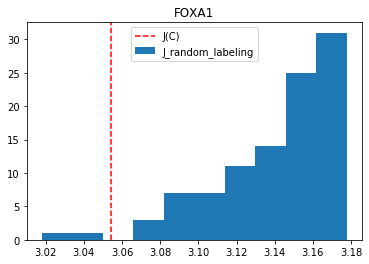

    ID_number FOXA1
0   SCAN_0155     A
1   SCAN_0268     A
2   SCAN_0212     A
3   SCAN_0190     A
4   SCAN_0460     A
5   SCAN_0076     B
6   SCAN_0094     B
7   SCAN_0084     B
8   SCAN_0137     B
9   SCAN_0285     B
10  SCAN_0293     C
11  SCAN_0271     C
12  SCAN_0291     C
13  SCAN_0310     C
14  SCAN_0264     C
torch.Size([64, 1, 1])
J_C:  3.2004428890546164
mean hist:  3.262389375582138
0.06194648652752166


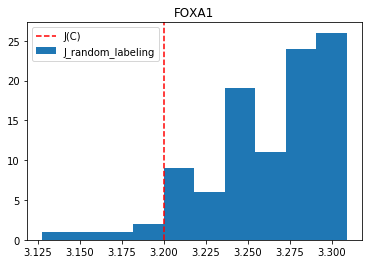

    ID_number FOXA1
0   SCAN_0326     A
1   SCAN_0241     A
2   SCAN_0190     A
3   SCAN_0228     A
4   SCAN_0171     A
5   SCAN_0204     B
6   SCAN_0188     B
7   SCAN_0249     B
8   SCAN_0055     B
9   SCAN_0246     B
10  SCAN_0257     C
11  SCAN_0270     C
12  SCAN_0283     C
13  SCAN_0316     C
14  SCAN_0251     C
torch.Size([64, 1, 1])
J_C:  2.6421084746350596
mean hist:  2.6254947964472315
-0.016613678187828107


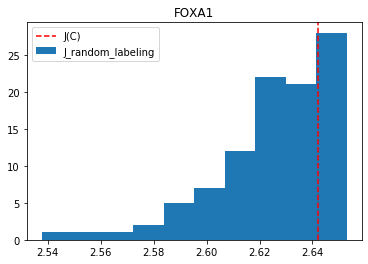

    ID_number FOXA1
0   SCAN_0169     A
1   SCAN_0296     A
2   SCAN_0184     A
3   SCAN_0210     A
4   SCAN_0211     A
5   SCAN_0082     B
6   SCAN_0297     B
7   SCAN_0458     B
8   SCAN_0317     B
9   SCAN_0252     B
10  SCAN_0258     C
11  SCAN_0093     C
12  SCAN_0110     C
13  SCAN_0086     C
14  SCAN_0261     C
torch.Size([64, 1, 1])
J_C:  3.001654990752538
mean hist:  3.0909013445484637
0.0892463537959256


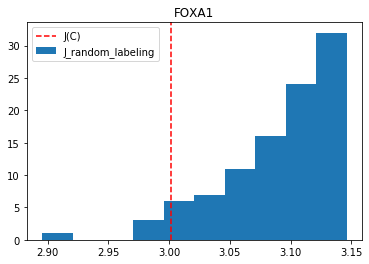

In [96]:
label = 'FOXA1'
for i in range(10):
    sampled_df = get_dataset_continous(label, i)
    print(sampled_df)
    dataset = BiopsyDataset100("/storage/Chloe/zoom_20_512", sampled_df, label, transform=transform)
    distance, mean, percentage = binning_eval(dataset, sampled_df, encoder, label)
    new_row = {'Label': label, 'Encoder': '64', 'Distance': distance, 'Mean of distribution': mean, "Percentage": percentage}
    df_results = df_results.append(new_row, ignore_index=True)

    ID_number HIF1A
0   SCAN_0061     A
1   SCAN_0081     A
2   SCAN_0271     A
3   SCAN_0150     A
4   SCAN_0215     A
5   SCAN_0115     B
6   SCAN_0110     B
7   SCAN_0082     B
8   SCAN_0305     B
9   SCAN_0328     B
10  SCAN_0169     C
11  SCAN_0189     C
12  SCAN_0469     C
13  SCAN_0098     C
14  SCAN_0181     C
torch.Size([64, 1, 1])
J_C:  3.1770314139546665
mean hist:  3.136959886915915
-0.0400715270387515


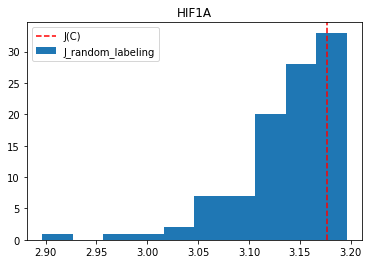

    ID_number HIF1A
0   SCAN_0291     A
1   SCAN_0222     A
2   SCAN_0156     A
3   SCAN_0276     A
4   SCAN_0463     A
5   SCAN_0114     B
6   SCAN_0327     B
7   SCAN_0071     B
8   SCAN_0321     B
9   SCAN_0205     B
10  SCAN_0178     C
11  SCAN_0162     C
12  SCAN_0258     C
13  SCAN_0177     C
14  SCAN_0130     C
torch.Size([64, 1, 1])
J_C:  2.8337635037501654
mean hist:  2.834911291011969
0.0011477872618037566


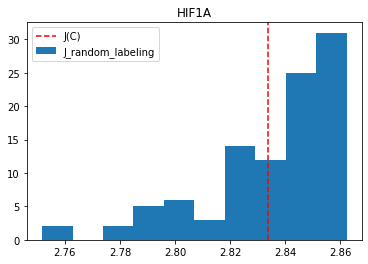

    ID_number HIF1A
0   SCAN_0277     A
1   SCAN_0093     A
2   SCAN_0132     A
3   SCAN_0061     A
4   SCAN_0097     A
5   SCAN_0131     B
6   SCAN_0328     B
7   SCAN_0066     B
8   SCAN_0182     B
9   SCAN_0160     B
10  SCAN_0202     C
11  SCAN_0103     C
12  SCAN_0189     C
13  SCAN_0137     C
14  SCAN_0218     C
torch.Size([64, 1, 1])
J_C:  3.1417955243026796
mean hist:  3.0948461582226745
-0.046949366080005106


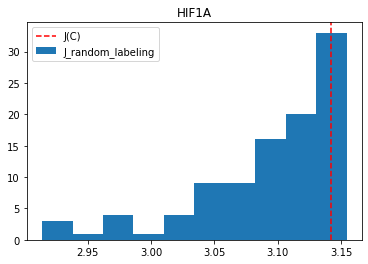

    ID_number HIF1A
0   SCAN_0223     A
1   SCAN_0208     A
2   SCAN_0168     A
3   SCAN_0200     A
4   SCAN_0147     A
5   SCAN_0131     B
6   SCAN_0071     B
7   SCAN_0210     B
8   SCAN_0143     B
9   SCAN_0173     B
10  SCAN_0234     C
11  SCAN_0213     C
12  SCAN_0146     C
13  SCAN_0301     C
14  SCAN_0145     C
torch.Size([64, 1, 1])
J_C:  3.0480383918285368
mean hist:  3.0123180945996437
-0.03572029722889303


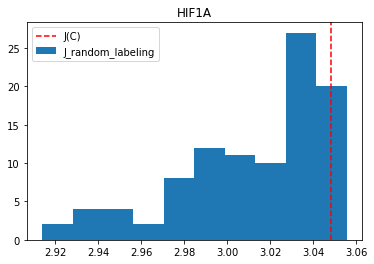

    ID_number HIF1A
0   SCAN_0081     A
1   SCAN_0324     A
2   SCAN_0132     A
3   SCAN_0073     A
4   SCAN_0271     A
5   SCAN_0273     B
6   SCAN_0182     B
7   SCAN_0294     B
8   SCAN_0298     B
9   SCAN_0109     B
10  SCAN_0231     C
11  SCAN_0054     C
12  SCAN_0175     C
13  SCAN_0184     C
14  SCAN_0258     C
torch.Size([64, 1, 1])
J_C:  2.880295742265855
mean hist:  2.88336280445006
0.0030670621842050494


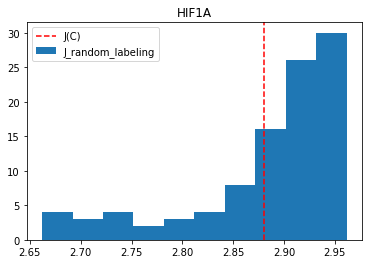

    ID_number HIF1A
0   SCAN_0147     A
1   SCAN_0136     A
2   SCAN_0283     A
3   SCAN_0303     A
4   SCAN_0471     A
5   SCAN_0294     B
6   SCAN_0071     B
7   SCAN_0140     B
8   SCAN_0327     B
9   SCAN_0314     B
10  SCAN_0207     C
11  SCAN_0176     C
12  SCAN_0134     C
13  SCAN_0175     C
14  SCAN_0295     C
torch.Size([64, 1, 1])
J_C:  3.3506996467843786
mean hist:  3.341383376792745
-0.009316269991633597


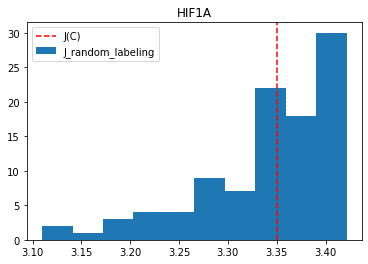

    ID_number HIF1A
0   SCAN_0275     A
1   SCAN_0092     A
2   SCAN_0097     A
3   SCAN_0113     A
4   SCAN_0055     A
5   SCAN_0300     B
6   SCAN_0095     B
7   SCAN_0262     B
8   SCAN_0183     B
9   SCAN_0314     B
10  SCAN_0151     C
11  SCAN_0285     C
12  SCAN_0219     C
13  SCAN_0258     C
14  SCAN_0329     C
torch.Size([64, 1, 1])
J_C:  2.895746445841035
mean hist:  2.8966790573694605
0.0009326115284253866


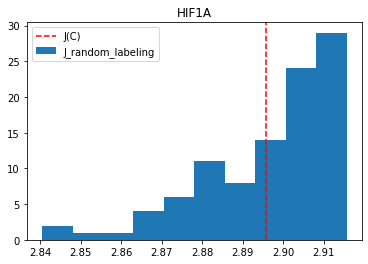

    ID_number HIF1A
0   SCAN_0090     A
1   SCAN_0096     A
2   SCAN_0457     A
3   SCAN_0291     A
4   SCAN_0136     A
5   SCAN_0095     B
6   SCAN_0116     B
7   SCAN_0109     B
8   SCAN_0252     B
9   SCAN_0312     B
10  SCAN_0171     C
11  SCAN_0468     C
12  SCAN_0170     C
13  SCAN_0184     C
14  SCAN_0329     C
torch.Size([64, 1, 1])
J_C:  3.281133519689242
mean hist:  3.400161188176473
0.1190276684872309


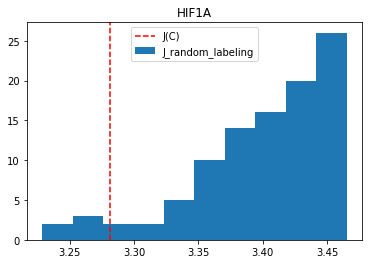

    ID_number HIF1A
0   SCAN_0132     A
1   SCAN_0222     A
2   SCAN_0291     A
3   SCAN_0191     A
4   SCAN_0256     A
5   SCAN_0210     B
6   SCAN_0205     B
7   SCAN_0278     B
8   SCAN_0058     B
9   SCAN_0273     B
10  SCAN_0317     C
11  SCAN_0462     C
12  SCAN_0164     C
13  SCAN_0189     C
14  SCAN_0296     C
torch.Size([64, 1, 1])
J_C:  2.9503886743415744
mean hist:  3.015253073365947
0.06486439902437269


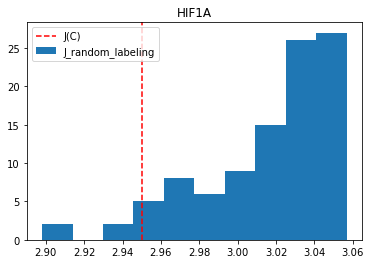

    ID_number HIF1A
0   SCAN_0253     A
1   SCAN_0111     A
2   SCAN_0276     A
3   SCAN_0325     A
4   SCAN_0455     A
5   SCAN_0108     B
6   SCAN_0327     B
7   SCAN_0173     B
8   SCAN_0465     B
9   SCAN_0281     B
10  SCAN_0322     C
11  SCAN_0144     C
12  SCAN_0257     C
13  SCAN_0128     C
14  SCAN_0323     C
torch.Size([64, 1, 1])
J_C:  3.4031354046265285
mean hist:  3.3228659167853993
-0.0802694878411292


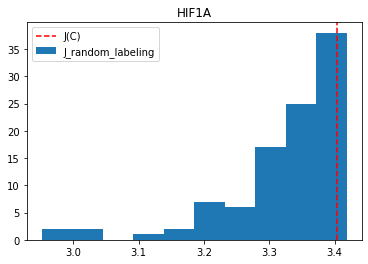

In [97]:
label = 'HIF1A'
for i in range(10):
    sampled_df = get_dataset_continous(label, i)
    print(sampled_df)
    dataset = BiopsyDataset100("/storage/Chloe/zoom_20_512", sampled_df, label, transform=transform)
    distance, mean, percentage = binning_eval(dataset, sampled_df, encoder, label)
    new_row = {'Label': label, 'Encoder': '64', 'Distance': distance, 'Mean of distribution': mean, "Percentage": percentage}
    df_results = df_results.append(new_row, ignore_index=True)
    

    ID_number ROR.S.Group..Subtype.Only.
0   SCAN_0311                          0
1   SCAN_0292                          0
2   SCAN_0190                          0
3   SCAN_0329                          0
4   SCAN_0259                          0
5   SCAN_0115                          1
6   SCAN_0111                          1
7   SCAN_0181                          1
8   SCAN_0097                          1
9   SCAN_0248                          1
10  SCAN_0313                          2
11  SCAN_0238                          2
12  SCAN_0145                          2
13  SCAN_0134                          2
14  SCAN_0112                          2
torch.Size([64, 1, 1])
J_C:  3.190588983972867
mean hist:  3.252363386336167
0.061774402363299785


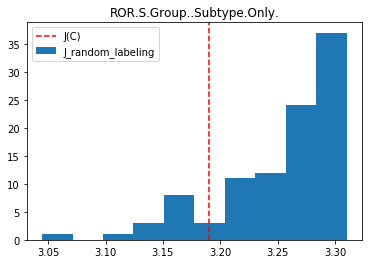

    ID_number ROR.S.Group..Subtype.Only.
0   SCAN_0233                          0
1   SCAN_0212                          0
2   SCAN_0459                          0
3   SCAN_0460                          0
4   SCAN_0301                          0
5   SCAN_0094                          1
6   SCAN_0137                          1
7   SCAN_0248                          1
8   SCAN_0209                          1
9   SCAN_0136                          1
10  SCAN_0112                          2
11  SCAN_0082                          2
12  SCAN_0253                          2
13  SCAN_0145                          2
14  SCAN_0129                          2
torch.Size([64, 1, 1])
J_C:  3.3509136322339375
mean hist:  3.4259138201280446
0.07500018789410712


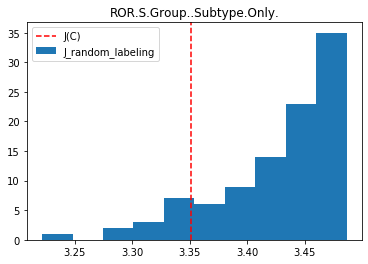

    ID_number ROR.S.Group..Subtype.Only.
0   SCAN_0197                          0
1   SCAN_0305                          0
2   SCAN_0266                          0
3   SCAN_0250                          0
4   SCAN_0298                          0
5   SCAN_0090                          1
6   SCAN_0138                          1
7   SCAN_0461                          1
8   SCAN_0078                          1
9   SCAN_0265                          1
10  SCAN_0268                          2
11  SCAN_0128                          2
12  SCAN_0134                          2
13  SCAN_0130                          2
14  SCAN_0154                          2
torch.Size([64, 1, 1])
J_C:  3.411348350962003
mean hist:  3.5163046858668325
0.1049563349048297


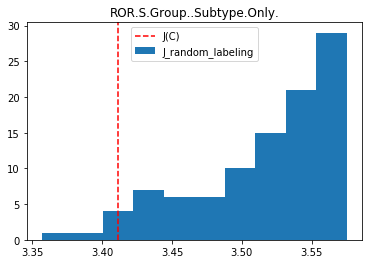

    ID_number ROR.S.Group..Subtype.Only.
0   SCAN_0304                          0
1   SCAN_0259                          0
2   SCAN_0221                          0
3   SCAN_0302                          0
4   SCAN_0254                          0
5   SCAN_0081                          1
6   SCAN_0084                          1
7   SCAN_0186                          1
8   SCAN_0060                          1
9   SCAN_0127                          1
10  SCAN_0232                          2
11  SCAN_0318                          2
12  SCAN_0150                          2
13  SCAN_0092                          2
14  SCAN_0135                          2
torch.Size([64, 1, 1])
J_C:  3.10727662727278
mean hist:  3.1348007158408784
0.027524088568098293


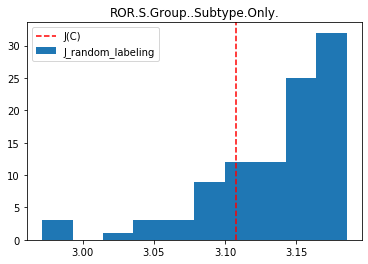

    ID_number ROR.S.Group..Subtype.Only.
0   SCAN_0254                          0
1   SCAN_0292                          0
2   SCAN_0297                          0
3   SCAN_0467                          0
4   SCAN_0282                          0
5   SCAN_0314                          1
6   SCAN_0054                          1
7   SCAN_0101                          1
8   SCAN_0148                          1
9   SCAN_0270                          1
10  SCAN_0056                          2
11  SCAN_0238                          2
12  SCAN_0092                          2
13  SCAN_0068                          2
14  SCAN_0129                          2
torch.Size([64, 1, 1])
J_C:  3.169323263868774
mean hist:  3.2473835303537597
0.07806026648498587


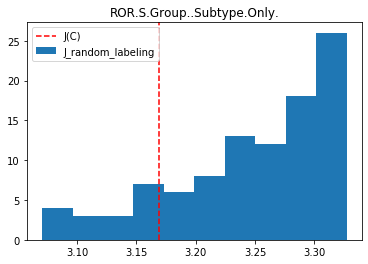

    ID_number ROR.S.Group..Subtype.Only.
0   SCAN_0185                          0
1   SCAN_0326                          0
2   SCAN_0277                          0
3   SCAN_0291                          0
4   SCAN_0212                          0
5   SCAN_0088                          1
6   SCAN_0148                          1
7   SCAN_0283                          1
8   SCAN_0140                          1
9   SCAN_0094                          1
10  SCAN_0100                          2
11  SCAN_0284                          2
12  SCAN_0103                          2
13  SCAN_0129                          2
14  SCAN_0082                          2
torch.Size([64, 1, 1])
J_C:  3.3079430141287336
mean hist:  3.37019924536802
0.062256231239286475


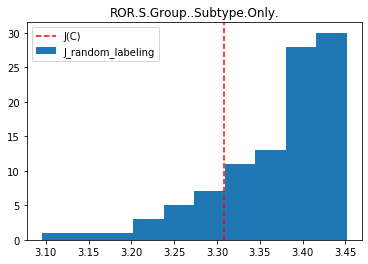

    ID_number ROR.S.Group..Subtype.Only.
0   SCAN_0231                          0
1   SCAN_0211                          0
2   SCAN_0295                          0
3   SCAN_0208                          0
4   SCAN_0058                          0
5   SCAN_0186                          1
6   SCAN_0138                          1
7   SCAN_0133                          1
8   SCAN_0060                          1
9   SCAN_0078                          1
10  SCAN_0108                          2
11  SCAN_0100                          2
12  SCAN_0109                          2
13  SCAN_0132                          2
14  SCAN_0141                          2
torch.Size([64, 1, 1])
J_C:  3.5835388387498095
mean hist:  3.7592032519255265
0.17566441317571702


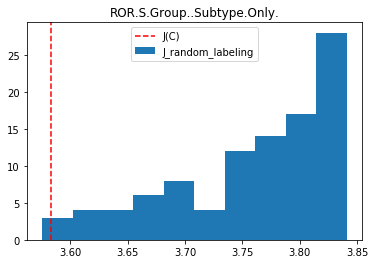

    ID_number ROR.S.Group..Subtype.Only.
0   SCAN_0192                          0
1   SCAN_0231                          0
2   SCAN_0471                          0
3   SCAN_0240                          0
4   SCAN_0312                          0
5   SCAN_0469                          1
6   SCAN_0126                          1
7   SCAN_0265                          1
8   SCAN_0089                          1
9   SCAN_0307                          1
10  SCAN_0144                          2
11  SCAN_0117                          2
12  SCAN_0128                          2
13  SCAN_0150                          2
14  SCAN_0086                          2
torch.Size([64, 1, 1])
J_C:  3.6935923763259297
mean hist:  3.666559349573798
-0.027033026752131928


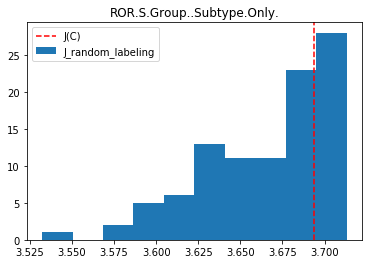

    ID_number ROR.S.Group..Subtype.Only.
0   SCAN_0224                          0
1   SCAN_0225                          0
2   SCAN_0167                          0
3   SCAN_0191                          0
4   SCAN_0251                          0
5   SCAN_0148                          1
6   SCAN_0252                          1
7   SCAN_0084                          1
8   SCAN_0275                          1
9   SCAN_0075                          1
10  SCAN_0313                          2
11  SCAN_0323                          2
12  SCAN_0150                          2
13  SCAN_0156                          2
14  SCAN_0157                          2
torch.Size([64, 1, 1])
J_C:  3.3206399860391986
mean hist:  3.368040864354934
0.04740087831573536


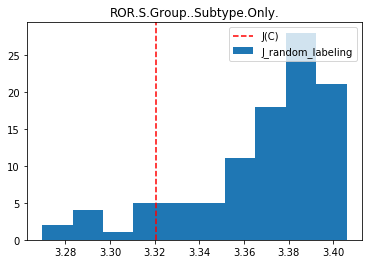

    ID_number ROR.S.Group..Subtype.Only.
0   SCAN_0259                          0
1   SCAN_0250                          0
2   SCAN_0310                          0
3   SCAN_0189                          0
4   SCAN_0263                          0
5   SCAN_0062                          1
6   SCAN_0160                          1
7   SCAN_0281                          1
8   SCAN_0127                          1
9   SCAN_0102                          1
10  SCAN_0142                          2
11  SCAN_0063                          2
12  SCAN_0156                          2
13  SCAN_0114                          2
14  SCAN_0145                          2
torch.Size([64, 1, 1])
J_C:  3.0961763799587882
mean hist:  3.140452742696206
0.04427636273741786


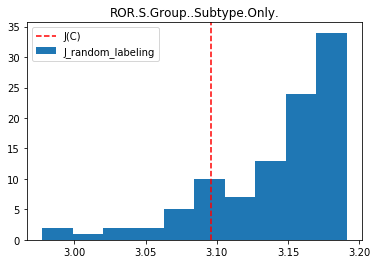

In [98]:
label = 'ROR.S.Group..Subtype.Only.'
for i in range(10):
    sampled_df = get_dataset_ROR(label, i)
    print(sampled_df)
    dataset = BiopsyDataset100("/storage/Chloe/zoom_20_512", sampled_df, label, transform=transform)
    distance, mean, percentage = binning_eval(dataset, sampled_df, encoder, label)
    new_row = {'Label': label, 'Encoder': '64', 'Distance': distance, 'Mean of distribution': mean, "Percentage": percentage}
    df_results = df_results.append(new_row, ignore_index=True)

    ID_number ROR.P.Group..Subtype...Proliferation.
0   SCAN_0203                                     0
1   SCAN_0208                                     0
2   SCAN_0308                                     0
3   SCAN_0470                                     0
4   SCAN_0329                                     0
5   SCAN_0124                                     1
6   SCAN_0210                                     1
7   SCAN_0461                                     1
8   SCAN_0464                                     1
9   SCAN_0314                                     1
10  SCAN_0074                                     2
11  SCAN_0092                                     2
12  SCAN_0063                                     2
13  SCAN_0072                                     2
14  SCAN_0109                                     2
torch.Size([64, 1, 1])
J_C:  3.389156051113137
mean hist:  3.4820840222778777
0.09292797116474061


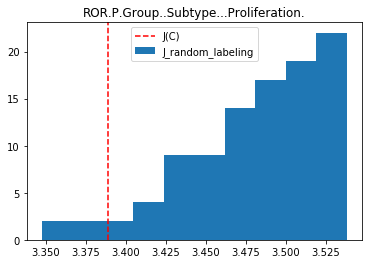

    ID_number ROR.P.Group..Subtype...Proliferation.
0   SCAN_0299                                     0
1   SCAN_0207                                     0
2   SCAN_0277                                     0
3   SCAN_0236                                     0
4   SCAN_0206                                     0
5   SCAN_0161                                     1
6   SCAN_0301                                     1
7   SCAN_0105                                     1
8   SCAN_0317                                     1
9   SCAN_0254                                     1
10  SCAN_0123                                     2
11  SCAN_0275                                     2
12  SCAN_0194                                     2
13  SCAN_0323                                     2
14  SCAN_0068                                     2
torch.Size([64, 1, 1])
J_C:  3.0228086360430315
mean hist:  3.048625256301185
0.025816620258153566


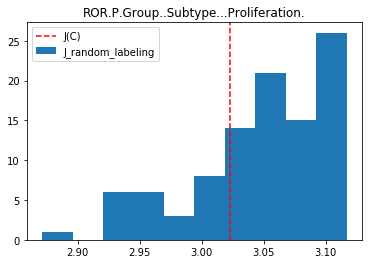

    ID_number ROR.P.Group..Subtype...Proliferation.
0   SCAN_0234                                     0
1   SCAN_0217                                     0
2   SCAN_0470                                     0
3   SCAN_0256                                     0
4   SCAN_0460                                     0
5   SCAN_0174                                     1
6   SCAN_0104                                     1
7   SCAN_0173                                     1
8   SCAN_0161                                     1
9   SCAN_0101                                     1
10  SCAN_0289                                     2
11  SCAN_0144                                     2
12  SCAN_0286                                     2
13  SCAN_0093                                     2
14  SCAN_0327                                     2
torch.Size([64, 1, 1])
J_C:  3.046860922137896
mean hist:  3.04264427104334
-0.004216651094556045


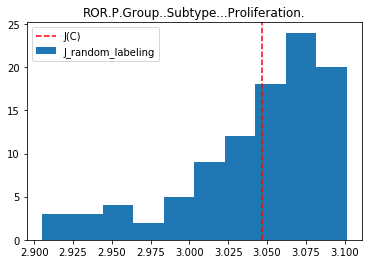

    ID_number ROR.P.Group..Subtype...Proliferation.
0   SCAN_0462                                     0
1   SCAN_0163                                     0
2   SCAN_0295                                     0
3   SCAN_0192                                     0
4   SCAN_0272                                     0
5   SCAN_0260                                     1
6   SCAN_0251                                     1
7   SCAN_0221                                     1
8   SCAN_0213                                     1
9   SCAN_0110                                     1
10  SCAN_0463                                     2
11  SCAN_0133                                     2
12  SCAN_0056                                     2
13  SCAN_0073                                     2
14  SCAN_0082                                     2
torch.Size([64, 1, 1])
J_C:  3.0016214340925216
mean hist:  3.112333106904029
0.11071167281150762


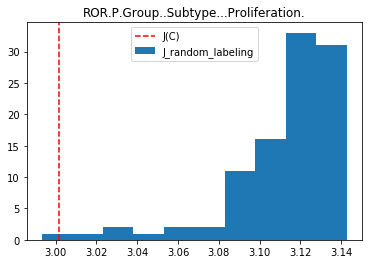

    ID_number ROR.P.Group..Subtype...Proliferation.
0   SCAN_0197                                     0
1   SCAN_0225                                     0
2   SCAN_0214                                     0
3   SCAN_0196                                     0
4   SCAN_0293                                     0
5   SCAN_0231                                     1
6   SCAN_0105                                     1
7   SCAN_0226                                     1
8   SCAN_0240                                     1
9   SCAN_0188                                     1
10  SCAN_0156                                     2
11  SCAN_0054                                     2
12  SCAN_0125                                     2
13  SCAN_0130                                     2
14  SCAN_0232                                     2
torch.Size([64, 1, 1])
J_C:  3.001464996417363
mean hist:  2.99778055819273
-0.0036844382246332685


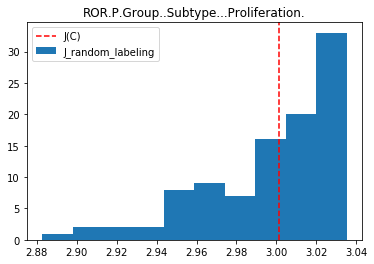

    ID_number ROR.P.Group..Subtype...Proliferation.
0   SCAN_0315                                     0
1   SCAN_0319                                     0
2   SCAN_0277                                     0
3   SCAN_0158                                     0
4   SCAN_0218                                     0
5   SCAN_0058                                     1
6   SCAN_0185                                     1
7   SCAN_0466                                     1
8   SCAN_0227                                     1
9   SCAN_0101                                     1
10  SCAN_0128                                     2
11  SCAN_0108                                     2
12  SCAN_0143                                     2
13  SCAN_0268                                     2
14  SCAN_0123                                     2
torch.Size([64, 1, 1])
J_C:  3.463161590624664
mean hist:  3.463612498632125
0.0004509080074606153


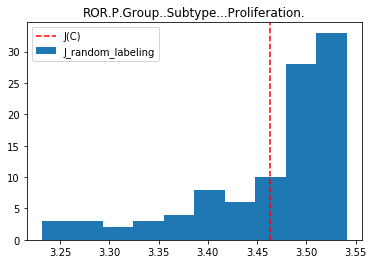

    ID_number ROR.P.Group..Subtype...Proliferation.
0   SCAN_0459                                     0
1   SCAN_0158                                     0
2   SCAN_0311                                     0
3   SCAN_0211                                     0
4   SCAN_0207                                     0
5   SCAN_0104                                     1
6   SCAN_0285                                     1
7   SCAN_0091                                     1
8   SCAN_0188                                     1
9   SCAN_0310                                     1
10  SCAN_0136                                     2
11  SCAN_0255                                     2
12  SCAN_0113                                     2
13  SCAN_0258                                     2
14  SCAN_0076                                     2
torch.Size([64, 1, 1])
J_C:  3.202752848466237
mean hist:  3.205795180908242
0.0030423324420048026


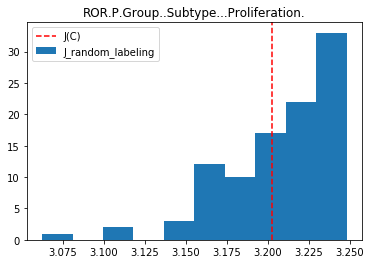

    ID_number ROR.P.Group..Subtype...Proliferation.
0   SCAN_0204                                     0
1   SCAN_0163                                     0
2   SCAN_0234                                     0
3   SCAN_0296                                     0
4   SCAN_0182                                     0
5   SCAN_0322                                     1
6   SCAN_0161                                     1
7   SCAN_0213                                     1
8   SCAN_0171                                     1
9   SCAN_0324                                     1
10  SCAN_0095                                     2
11  SCAN_0327                                     2
12  SCAN_0080                                     2
13  SCAN_0083                                     2
14  SCAN_0077                                     2
torch.Size([64, 1, 1])
J_C:  2.682356233031235
mean hist:  2.7341625226128174
0.05180628958158229


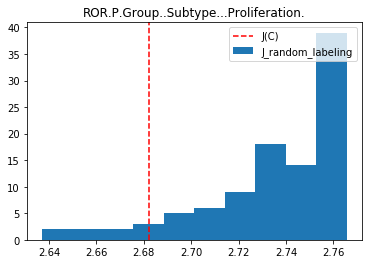

    ID_number ROR.P.Group..Subtype...Proliferation.
0   SCAN_0163                                     0
1   SCAN_0159                                     0
2   SCAN_0299                                     0
3   SCAN_0262                                     0
4   SCAN_0192                                     0
5   SCAN_0171                                     1
6   SCAN_0221                                     1
7   SCAN_0464                                     1
8   SCAN_0310                                     1
9   SCAN_0104                                     1
10  SCAN_0265                                     2
11  SCAN_0142                                     2
12  SCAN_0255                                     2
13  SCAN_0270                                     2
14  SCAN_0118                                     2
torch.Size([64, 1, 1])
J_C:  2.5482577385902405
mean hist:  2.591928399317662
0.04367066072742132


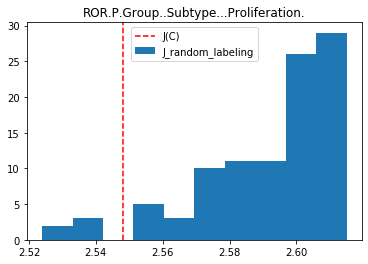

    ID_number ROR.P.Group..Subtype...Proliferation.
0   SCAN_0296                                     0
1   SCAN_0300                                     0
2   SCAN_0319                                     0
3   SCAN_0191                                     0
4   SCAN_0211                                     0
5   SCAN_0105                                     1
6   SCAN_0466                                     1
7   SCAN_0137                                     1
8   SCAN_0190                                     1
9   SCAN_0455                                     1
10  SCAN_0269                                     2
11  SCAN_0056                                     2
12  SCAN_0095                                     2
13  SCAN_0074                                     2
14  SCAN_0089                                     2
torch.Size([64, 1, 1])
J_C:  3.2284793156285247
mean hist:  3.3045074159407815
0.07602810031225671


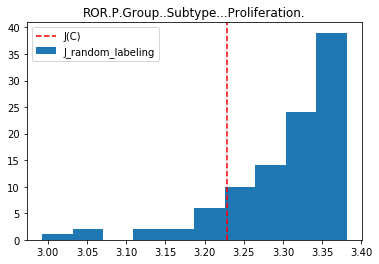

In [99]:
label = 'ROR.P.Group..Subtype...Proliferation.'
for i in range(10):
    sampled_df = get_dataset_ROR(label, i)
    print(sampled_df)
    dataset = BiopsyDataset100("/storage/Chloe/zoom_20_512", sampled_df, label, transform=transform)
    distance, mean, percentage = binning_eval(dataset, sampled_df, encoder, label)
    new_row = {'Label': label, 'Encoder': '64', 'Distance': distance, 'Mean of distribution': mean, "Percentage": percentage}
    df_results = df_results.append(new_row, ignore_index=True)

   ID_number PR status
0  SCAN_0103         0
1  SCAN_0060         0
2  SCAN_0090         0
3  SCAN_0156         0
4  SCAN_0130         0
5  SCAN_0057         1
6  SCAN_0095         1
7  SCAN_0126         1
8  SCAN_0077         1
9  SCAN_0074         1
torch.Size([64, 1, 1])
J_C:  3.7706028200222543
mean hist:  3.762500768319556
-0.008102051702698176


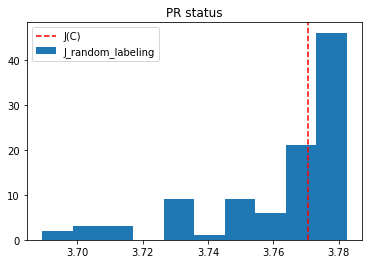

   ID_number PR status
0  SCAN_0065         0
1  SCAN_0132         0
2  SCAN_0082         0
3  SCAN_0103         0
4  SCAN_0061         0
5  SCAN_0106         1
6  SCAN_0096         1
7  SCAN_0112         1
8  SCAN_0131         1
9  SCAN_0155         1
torch.Size([64, 1, 1])
J_C:  3.6404081188045345
mean hist:  3.611713044271694
-0.028695074532840703


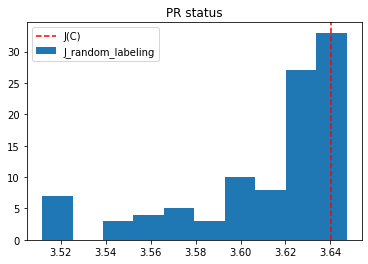

   ID_number PR status
0  SCAN_0092         0
1  SCAN_0067         0
2  SCAN_0130         0
3  SCAN_0056         0
4  SCAN_0103         0
5  SCAN_0101         1
6  SCAN_0093         1
7  SCAN_0125         1
8  SCAN_0085         1
9  SCAN_0077         1
torch.Size([64, 1, 1])
J_C:  3.2639206973466584
mean hist:  3.250691133825527
-0.013229563521131471


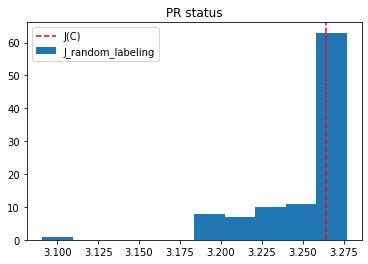

   ID_number PR status
0  SCAN_0119         0
1  SCAN_0061         0
2  SCAN_0060         0
3  SCAN_0144         0
4  SCAN_0067         0
5  SCAN_0129         1
6  SCAN_0085         1
7  SCAN_0058         1
8  SCAN_0070         1
9  SCAN_0088         1
torch.Size([64, 1, 1])
J_C:  3.314001458996875
mean hist:  3.3215621694202055
0.007560710423330619


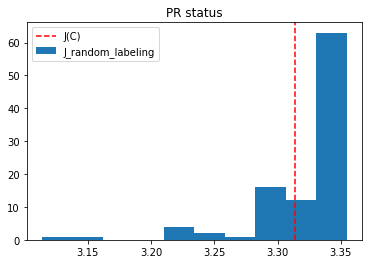

   ID_number PR status
0  SCAN_0082         0
1  SCAN_0065         0
2  SCAN_0150         0
3  SCAN_0119         0
4  SCAN_0067         0
5  SCAN_0110         1
6  SCAN_0075         1
7  SCAN_0074         1
8  SCAN_0124         1
9  SCAN_0131         1
torch.Size([64, 1, 1])
J_C:  3.3901155708985717
mean hist:  3.4448116570615115
0.05469608616293975


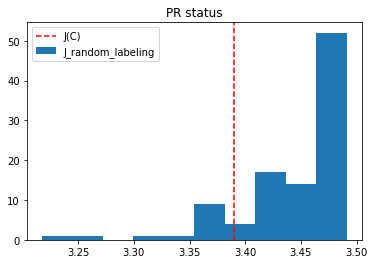

   ID_number PR status
0  SCAN_0061         0
1  SCAN_0060         0
2  SCAN_0114         0
3  SCAN_0103         0
4  SCAN_0069         0
5  SCAN_0106         1
6  SCAN_0102         1
7  SCAN_0122         1
8  SCAN_0148         1
9  SCAN_0125         1
torch.Size([64, 1, 1])
J_C:  3.3835236795544623
mean hist:  3.395872247357368
0.01234856780290583


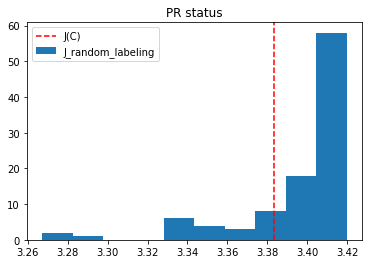

   ID_number PR status
0  SCAN_0069         0
1  SCAN_0144         0
2  SCAN_0061         0
3  SCAN_0114         0
4  SCAN_0090         0
5  SCAN_0157         1
6  SCAN_0085         1
7  SCAN_0141         1
8  SCAN_0078         1
9  SCAN_0140         1
torch.Size([64, 1, 1])
J_C:  3.797439198076725
mean hist:  3.752415373486281
-0.04502382459044396


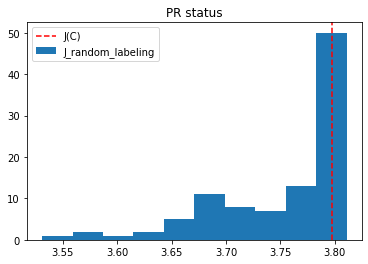

   ID_number PR status
0  SCAN_0060         0
1  SCAN_0061         0
2  SCAN_0069         0
3  SCAN_0156         0
4  SCAN_0056         0
5  SCAN_0081         1
6  SCAN_0143         1
7  SCAN_0154         1
8  SCAN_0135         1
9  SCAN_0140         1
torch.Size([64, 1, 1])
J_C:  3.9371472523212434
mean hist:  3.889879138123393
-0.0472681141978506


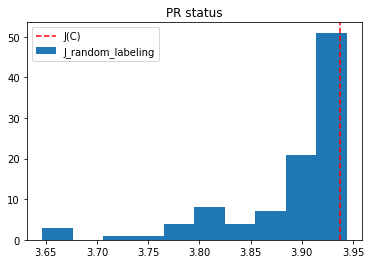

   ID_number PR status
0  SCAN_0130         0
1  SCAN_0082         0
2  SCAN_0144         0
3  SCAN_0114         0
4  SCAN_0067         0
5  SCAN_0087         1
6  SCAN_0072         1
7  SCAN_0055         1
8  SCAN_0073         1
9  SCAN_0097         1
torch.Size([64, 1, 1])
J_C:  3.3343686871528626
mean hist:  3.299822831773162
-0.03454585537970045


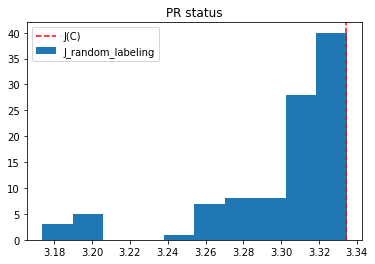

   ID_number PR status
0  SCAN_0065         0
1  SCAN_0082         0
2  SCAN_0086         0
3  SCAN_0069         0
4  SCAN_0144         0
5  SCAN_0107         1
6  SCAN_0102         1
7  SCAN_0141         1
8  SCAN_0112         1
9  SCAN_0142         1
torch.Size([64, 1, 1])
J_C:  3.7175996712446215
mean hist:  3.708777002347112
-0.008822668897509711


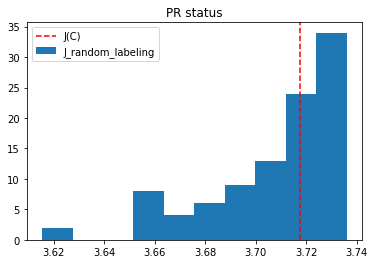

In [100]:
label = 'PR status'
for i in range(10):
    sampled_df = get_dataset_pos_neg(label, i)
    print(sampled_df)
    dataset = BiopsyDataset100("/storage/Chloe/zoom_20_512", sampled_df, label, transform=transform)
    distance, mean, percentage = binning_eval(dataset, sampled_df, encoder, label)
    new_row = {'Label': label, 'Encoder': '64', 'Distance': distance, 'Mean of distribution': mean, "Percentage": percentage}
    df_results = df_results.append(new_row, ignore_index=True)
    

   ID_number PAM50 subtype
0  SCAN_0315             A
1  SCAN_0460             A
2  SCAN_0257             A
3  SCAN_0324             A
4  SCAN_0468             A
5  SCAN_0318             B
6  SCAN_0286             B
7  SCAN_0289             B
8  SCAN_0269             B
9  SCAN_0253             B
torch.Size([64, 1, 1])
J_C:  3.1615374296307563
mean hist:  3.2620573583126076
0.10051992868185122


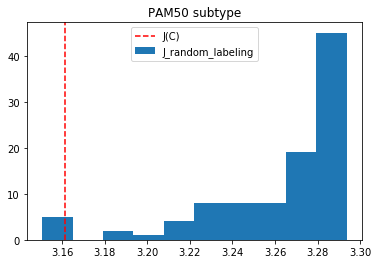

   ID_number PAM50 subtype
0  SCAN_0171             A
1  SCAN_0216             A
2  SCAN_0297             A
3  SCAN_0254             A
4  SCAN_0226             A
5  SCAN_0287             B
6  SCAN_0280             B
7  SCAN_0258             B
8  SCAN_0253             B
9  SCAN_0303             B
torch.Size([64, 1, 1])
J_C:  2.900602743354947
mean hist:  2.8856137772067147
-0.014988966148232308


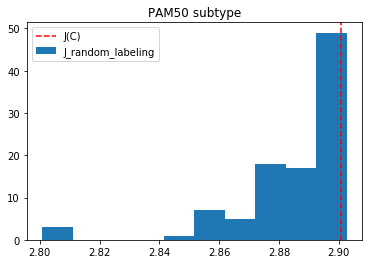

   ID_number PAM50 subtype
0  SCAN_0234             A
1  SCAN_0197             A
2  SCAN_0190             A
3  SCAN_0310             A
4  SCAN_0250             A
5  SCAN_0281             B
6  SCAN_0280             B
7  SCAN_0323             B
8  SCAN_0463             B
9  SCAN_0303             B
torch.Size([64, 1, 1])
J_C:  2.653676509076331
mean hist:  2.65319557817482
-0.00048093090151057893


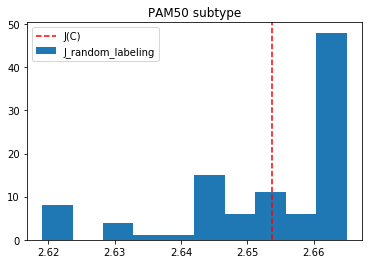

   ID_number PAM50 subtype
0  SCAN_0291             A
1  SCAN_0256             A
2  SCAN_0250             A
3  SCAN_0315             A
4  SCAN_0308             A
5  SCAN_0461             B
6  SCAN_0258             B
7  SCAN_0255             B
8  SCAN_0280             B
9  SCAN_0209             B
torch.Size([64, 1, 1])
J_C:  3.044268250465393
mean hist:  3.0317097485262154
-0.012558501939177624


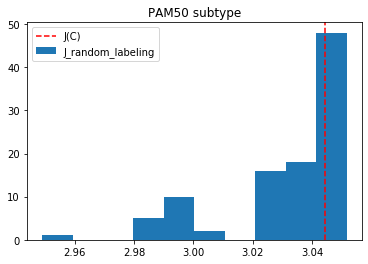

   ID_number PAM50 subtype
0  SCAN_0264             A
1  SCAN_0466             A
2  SCAN_0310             A
3  SCAN_0263             A
4  SCAN_0254             A
5  SCAN_0289             B
6  SCAN_0227             B
7  SCAN_0160             B
8  SCAN_0318             B
9  SCAN_0178             B
torch.Size([64, 1, 1])
J_C:  3.3366232815980914
mean hist:  3.3394527027118204
0.0028294211137289693


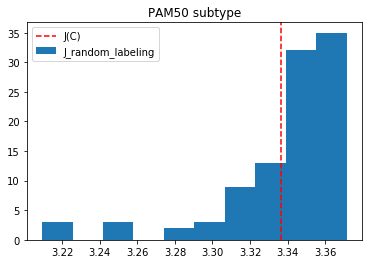

   ID_number PAM50 subtype
0  SCAN_0322             A
1  SCAN_0208             A
2  SCAN_0462             A
3  SCAN_0466             A
4  SCAN_0211             A
5  SCAN_0280             B
6  SCAN_0194             B
7  SCAN_0268             B
8  SCAN_0323             B
9  SCAN_0160             B
torch.Size([64, 1, 1])
J_C:  3.0555576619505884
mean hist:  3.058470189341009
0.002912527390420472


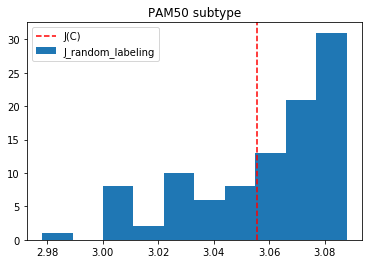

   ID_number PAM50 subtype
0  SCAN_0300             A
1  SCAN_0189             A
2  SCAN_0163             A
3  SCAN_0296             A
4  SCAN_0316             A
5  SCAN_0283             B
6  SCAN_0323             B
7  SCAN_0318             B
8  SCAN_0253             B
9  SCAN_0280             B
torch.Size([64, 1, 1])
J_C:  2.230468728938499
mean hist:  2.2362966597837963
0.005827930845297313


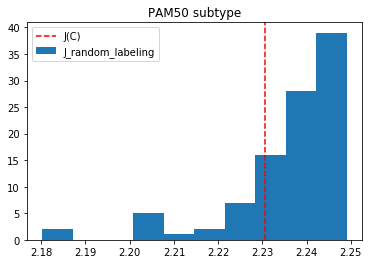

   ID_number PAM50 subtype
0  SCAN_0235             A
1  SCAN_0218             A
2  SCAN_0167             A
3  SCAN_0298             A
4  SCAN_0315             A
5  SCAN_0287             B
6  SCAN_0283             B
7  SCAN_0232             B
8  SCAN_0289             B
9  SCAN_0461             B
torch.Size([64, 1, 1])
J_C:  2.8013022321462633
mean hist:  2.771895583204627
-0.02940664894163625


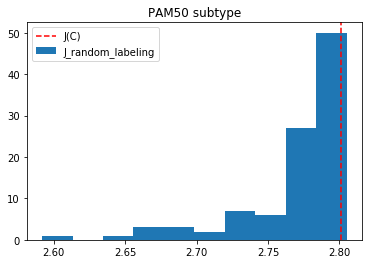

   ID_number PAM50 subtype
0  SCAN_0212             A
1  SCAN_0285             A
2  SCAN_0206             A
3  SCAN_0233             A
4  SCAN_0251             A
5  SCAN_0227             B
6  SCAN_0238             B
7  SCAN_0283             B
8  SCAN_0253             B
9  SCAN_0281             B
torch.Size([64, 1, 1])
J_C:  2.72657375395298
mean hist:  2.7343001544010646
0.0077264004480843695


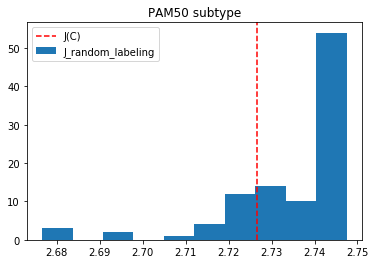

   ID_number PAM50 subtype
0  SCAN_0158             A
1  SCAN_0179             A
2  SCAN_0177             A
3  SCAN_0183             A
4  SCAN_0297             A
5  SCAN_0252             B
6  SCAN_0178             B
7  SCAN_0286             B
8  SCAN_0280             B
9  SCAN_0283             B
torch.Size([64, 1, 1])
J_C:  2.546176384270191
mean hist:  2.5484885515081883
0.002312167237997098


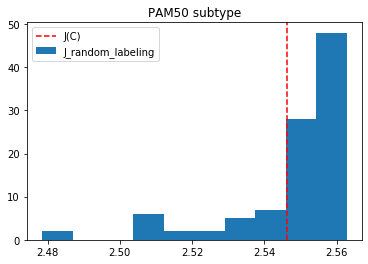

In [101]:
label = 'PAM50 subtype'
for i in range(10):
    sampled_df = get_dataset_PAM50(label, i)
    print(sampled_df)
    dataset = BiopsyDataset100("/storage/Chloe/zoom_20_512", sampled_df, label, transform=transform)
    distance, mean, percentage = binning_eval(dataset, sampled_df, encoder, label)
    new_row = {'Label': label, 'Encoder': '64', 'Distance': distance, 'Mean of distribution': mean, "Percentage": percentage}
    df_results = df_results.append(new_row, ignore_index=True)
    

In [102]:
df_results

,Label,Encoder,Distance,Mean of distribution,Percentage
0,Ki67 (%),No encoder,0.248609,206.088552,63.0
1,Ki67 (%),No encoder,12.491632,203.237264,97.0
2,Ki67 (%),No encoder,-0.270534,206.013481,54.0
3,Ki67 (%),No encoder,11.781205,201.536183,95.0
4,Ki67 (%),No encoder,13.686516,200.189516,100.0
...,...,...,...,...,...
445,PAM50 subtype,64,0.002913,3.058470,62.0
446,PAM50 subtype,64,0.005828,2.236297,81.0
447,PAM50 subtype,64,-0.029407,2.771896,16.0
448,PAM50 subtype,64,0.007726,2.734300,75.0


In [103]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 8, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(8, 4, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(4, 2, kernel_size=3, stride=2, padding=1),
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(2, 4, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(4, 8, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid(),    
        )
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [104]:
autoencoder = Autoencoder()

In [105]:
autoencoder.load_state_dict(torch.load('/storage/Chloe/final_model_autoencoder/autoencoder_2*1*1_split41.pth'))

<All keys matched successfully>

In [106]:
encoder = autoencoder.encoder

In [107]:
encoder

Sequential(
  (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (3): ReLU()
  (4): Conv2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (5): ReLU()
  (6): Conv2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (7): ReLU()
  (8): Conv2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (9): ReLU()
  (10): Conv2d(8, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (11): ReLU()
  (12): Conv2d(4, 2, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
)

    ID_number Ki67 (%)
0   SCAN_0250        A
1   SCAN_0306        A
2   SCAN_0294        A
3   SCAN_0282        A
4   SCAN_0276        A
5   SCAN_0087        B
6   SCAN_0279        B
7   SCAN_0138        B
8   SCAN_0466        B
9   SCAN_0079        B
10  SCAN_0082        C
11  SCAN_0066        C
12  SCAN_0133        C
13  SCAN_0321        C
14  SCAN_0209        C
torch.Size([2, 1, 1])
J_C:  0.888440030011814
mean hist:  0.8911752295549051
0.0027351995430910936


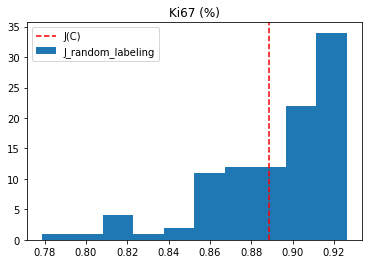

    ID_number Ki67 (%)
0   SCAN_0177        A
1   SCAN_0208        A
2   SCAN_0455        A
3   SCAN_0170        A
4   SCAN_0213        A
5   SCAN_0094        B
6   SCAN_0465        B
7   SCAN_0061        B
8   SCAN_0464        B
9   SCAN_0280        B
10  SCAN_0080        C
11  SCAN_0135        C
12  SCAN_0139        C
13  SCAN_0096        C
14  SCAN_0235        C
torch.Size([2, 1, 1])
J_C:  0.840016284417361
mean hist:  0.9618860347863637
0.12186975036900272


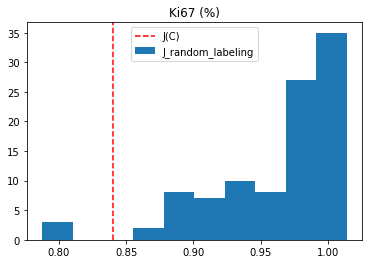

    ID_number Ki67 (%)
0   SCAN_0170        A
1   SCAN_0293        A
2   SCAN_0310        A
3   SCAN_0250        A
4   SCAN_0295        A
5   SCAN_0119        B
6   SCAN_0193        B
7   SCAN_0251        B
8   SCAN_0076        B
9   SCAN_0164        B
10  SCAN_0131        C
11  SCAN_0194        C
12  SCAN_0116        C
13  SCAN_0114        C
14  SCAN_0233        C
torch.Size([2, 1, 1])
J_C:  0.7564176684220583
mean hist:  0.7512705159825634
-0.005147152439494818


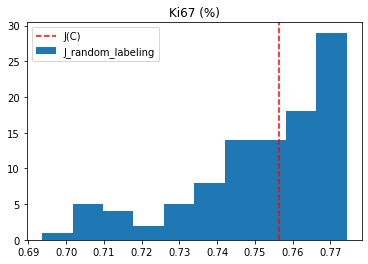

    ID_number Ki67 (%)
0   SCAN_0198        A
1   SCAN_0176        A
2   SCAN_0470        A
3   SCAN_0266        A
4   SCAN_0200        A
5   SCAN_0125        B
6   SCAN_0061        B
7   SCAN_0173        B
8   SCAN_0138        B
9   SCAN_0158        B
10  SCAN_0136        C
11  SCAN_0154        C
12  SCAN_0117        C
13  SCAN_0075        C
14  SCAN_0134        C
torch.Size([2, 1, 1])
J_C:  0.8181279964779193
mean hist:  0.9246637874036564
0.10653579092573706


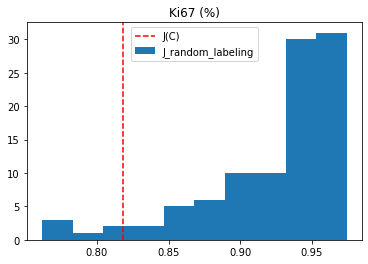

    ID_number Ki67 (%)
0   SCAN_0276        A
1   SCAN_0198        A
2   SCAN_0310        A
3   SCAN_0267        A
4   SCAN_0163        A
5   SCAN_0265        B
6   SCAN_0180        B
7   SCAN_0283        B
8   SCAN_0286        B
9   SCAN_0085        B
10  SCAN_0145        C
11  SCAN_0117        C
12  SCAN_0155        C
13  SCAN_0139        C
14  SCAN_0235        C
torch.Size([2, 1, 1])
J_C:  0.6635209592965742
mean hist:  0.7786014101897056
0.11508045089313146


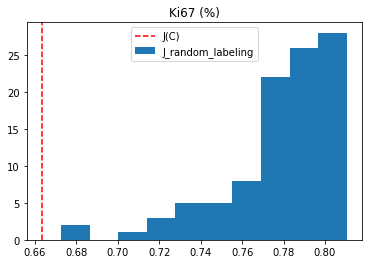

    ID_number Ki67 (%)
0   SCAN_0320        A
1   SCAN_0312        A
2   SCAN_0161        A
3   SCAN_0213        A
4   SCAN_0167        A
5   SCAN_0465        B
6   SCAN_0077        B
7   SCAN_0106        B
8   SCAN_0125        B
9   SCAN_0178        B
10  SCAN_0080        C
11  SCAN_0118        C
12  SCAN_0081        C
13  SCAN_0142        C
14  SCAN_0115        C
torch.Size([2, 1, 1])
J_C:  0.771897891404065
mean hist:  0.8126375774098621
0.04073968600579714


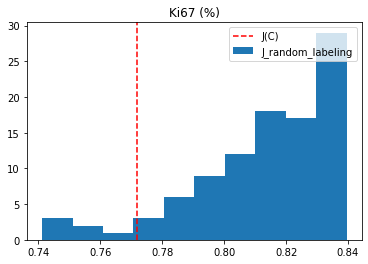

    ID_number Ki67 (%)
0   SCAN_0169        A
1   SCAN_0292        A
2   SCAN_0295        A
3   SCAN_0302        A
4   SCAN_0147        A
5   SCAN_0289        B
6   SCAN_0076        B
7   SCAN_0252        B
8   SCAN_0183        B
9   SCAN_0166        B
10  SCAN_0084        C
11  SCAN_0149        C
12  SCAN_0237        C
13  SCAN_0099        C
14  SCAN_0111        C
torch.Size([2, 1, 1])
J_C:  0.7756156395518531
mean hist:  0.8158186066938937
0.040202967142040635


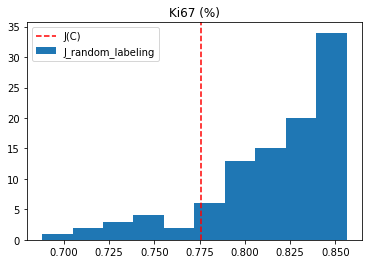

    ID_number Ki67 (%)
0   SCAN_0290        A
1   SCAN_0294        A
2   SCAN_0224        A
3   SCAN_0176        A
4   SCAN_0312        A
5   SCAN_0076        B
6   SCAN_0102        B
7   SCAN_0085        B
8   SCAN_0247        B
9   SCAN_0317        B
10  SCAN_0114        C
11  SCAN_0095        C
12  SCAN_0273        C
13  SCAN_0080        C
14  SCAN_0154        C
torch.Size([2, 1, 1])
J_C:  0.8594734851593773
mean hist:  0.8501597459771351
-0.009313739182242209


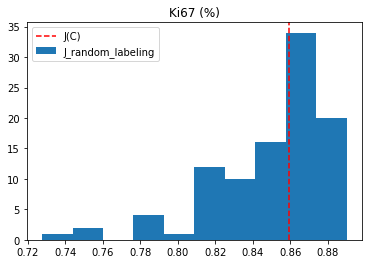

    ID_number Ki67 (%)
0   SCAN_0254        A
1   SCAN_0246        A
2   SCAN_0240        A
3   SCAN_0469        A
4   SCAN_0272        A
5   SCAN_0127        B
6   SCAN_0323        B
7   SCAN_0286        B
8   SCAN_0074        B
9   SCAN_0125        B
10  SCAN_0124        C
11  SCAN_0132        C
12  SCAN_0321        C
13  SCAN_0284        C
14  SCAN_0116        C
torch.Size([2, 1, 1])
J_C:  0.8371001574450342
mean hist:  0.8518572974774614
0.01475714003242723


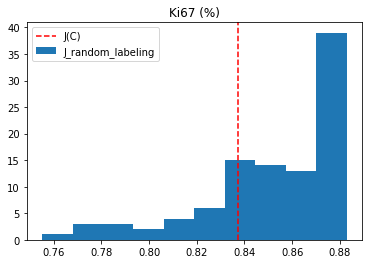

    ID_number Ki67 (%)
0   SCAN_0262        A
1   SCAN_0459        A
2   SCAN_0298        A
3   SCAN_0216        A
4   SCAN_0300        A
5   SCAN_0083        B
6   SCAN_0160        B
7   SCAN_0255        B
8   SCAN_0280        B
9   SCAN_0456        B
10  SCAN_0235        C
11  SCAN_0055        C
12  SCAN_0113        C
13  SCAN_0088        C
14  SCAN_0112        C
torch.Size([2, 1, 1])
J_C:  0.7425212834837536
mean hist:  0.7371154891242824
-0.005405794359471194


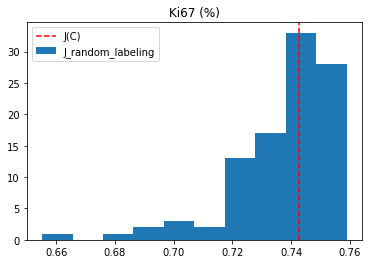

In [108]:
label = 'Ki67 (%)'
for i in range(10):
    sampled_df = get_dataset_continous(label, i)
    print(sampled_df)
    dataset = BiopsyDataset100("/storage/Chloe/zoom_20_512", sampled_df, label, transform=transform)
    distance, mean, percentage = binning_eval(dataset, sampled_df, encoder, label)
    new_row = {'Label': label, 'Encoder': '2', 'Distance': distance, 'Mean of distribution': mean, "Percentage": percentage}
    df_results = df_results.append(new_row, ignore_index=True)

    ID_number TILS (%)
0   SCAN_0067        A
1   SCAN_0271        A
2   SCAN_0255        A
3   SCAN_0102        A
4   SCAN_0305        A
5   SCAN_0108        B
6   SCAN_0232        B
7   SCAN_0247        B
8   SCAN_0188        B
9   SCAN_0099        B
10  SCAN_0203        C
11  SCAN_0118        C
12  SCAN_0170        C
13  SCAN_0128        C
14  SCAN_0086        C
torch.Size([2, 1, 1])
J_C:  0.8149850398829828
mean hist:  0.8087107726125683
-0.006274267270414469


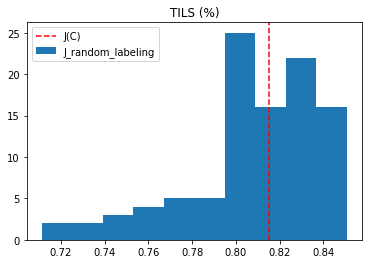

    ID_number TILS (%)
0   SCAN_0266        A
1   SCAN_0223        A
2   SCAN_0324        A
3   SCAN_0197        A
4   SCAN_0260        A
5   SCAN_0275        B
6   SCAN_0113        B
7   SCAN_0133        B
8   SCAN_0312        B
9   SCAN_0058        B
10  SCAN_0228        C
11  SCAN_0156        C
12  SCAN_0144        C
13  SCAN_0313        C
14  SCAN_0105        C
torch.Size([2, 1, 1])
J_C:  0.9006912871909638
mean hist:  0.9067357876820955
0.006044500491131699


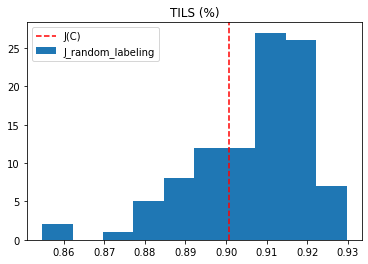

    ID_number TILS (%)
0   SCAN_0237        A
1   SCAN_0211        A
2   SCAN_0180        A
3   SCAN_0079        A
4   SCAN_0160        A
5   SCAN_0091        B
6   SCAN_0216        B
7   SCAN_0248        B
8   SCAN_0099        B
9   SCAN_0157        B
10  SCAN_0321        C
11  SCAN_0217        C
12  SCAN_0162        C
13  SCAN_0175        C
14  SCAN_0457        C
torch.Size([2, 1, 1])
J_C:  0.8211852314217637
mean hist:  0.8442175131562831
0.023032281734519433


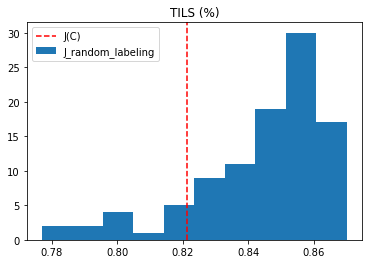

    ID_number TILS (%)
0   SCAN_0253        A
1   SCAN_0194        A
2   SCAN_0064        A
3   SCAN_0130        A
4   SCAN_0327        A
5   SCAN_0471        B
6   SCAN_0281        B
7   SCAN_0301        B
8   SCAN_0164        B
9   SCAN_0328        B
10  SCAN_0297        C
11  SCAN_0177        C
12  SCAN_0263        C
13  SCAN_0103        C
14  SCAN_0150        C
torch.Size([2, 1, 1])
J_C:  0.7603962017973741
mean hist:  0.7395857036152715
-0.020810498182102566


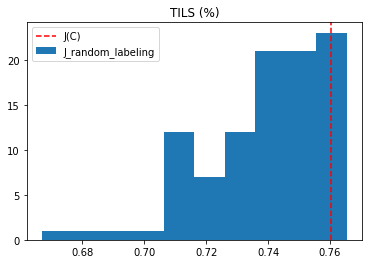

    ID_number TILS (%)
0   SCAN_0093        A
1   SCAN_0467        A
2   SCAN_0306        A
3   SCAN_0084        A
4   SCAN_0064        A
5   SCAN_0304        B
6   SCAN_0164        B
7   SCAN_0290        B
8   SCAN_0136        B
9   SCAN_0291        B
10  SCAN_0132        C
11  SCAN_0268        C
12  SCAN_0150        C
13  SCAN_0313        C
14  SCAN_0154        C
torch.Size([2, 1, 1])
J_C:  0.8990031742308178
mean hist:  0.9485994644099498
0.04959629017913203


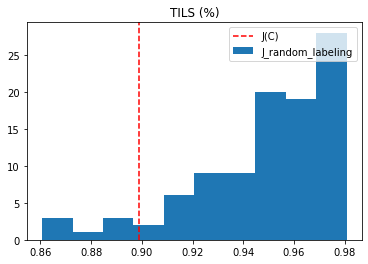

    ID_number TILS (%)
0   SCAN_0289        A
1   SCAN_0293        A
2   SCAN_0169        A
3   SCAN_0192        A
4   SCAN_0088        A
5   SCAN_0136        B
6   SCAN_0257        B
7   SCAN_0328        B
8   SCAN_0147        B
9   SCAN_0078        B
10  SCAN_0460        C
11  SCAN_0263        C
12  SCAN_0109        C
13  SCAN_0321        C
14  SCAN_0228        C
torch.Size([2, 1, 1])
J_C:  0.775754729289579
mean hist:  0.8461550263392043
0.07040029704962525


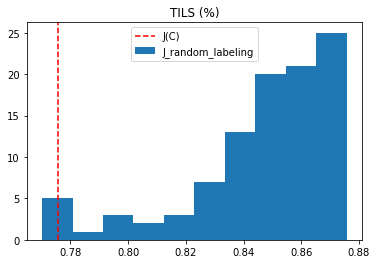

    ID_number TILS (%)
0   SCAN_0122        A
1   SCAN_0195        A
2   SCAN_0260        A
3   SCAN_0055        A
4   SCAN_0084        A
5   SCAN_0136        B
6   SCAN_0095        B
7   SCAN_0233        B
8   SCAN_0091        B
9   SCAN_0190        B
10  SCAN_0226        C
11  SCAN_0109        C
12  SCAN_0118        C
13  SCAN_0459        C
14  SCAN_0297        C
torch.Size([2, 1, 1])
J_C:  0.9444610009702543
mean hist:  0.9125644925550107
-0.03189650841524361


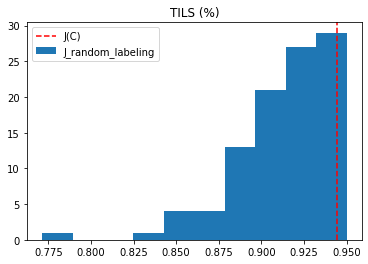

    ID_number TILS (%)
0   SCAN_0208        A
1   SCAN_0191        A
2   SCAN_0189        A
3   SCAN_0158        A
4   SCAN_0149        A
5   SCAN_0301        B
6   SCAN_0470        B
7   SCAN_0287        B
8   SCAN_0468        B
9   SCAN_0070        B
10  SCAN_0288        C
11  SCAN_0273        C
12  SCAN_0217        C
13  SCAN_0131        C
14  SCAN_0109        C
torch.Size([2, 1, 1])
J_C:  0.8791904588577648
mean hist:  0.9003863476924684
0.02119588883470358


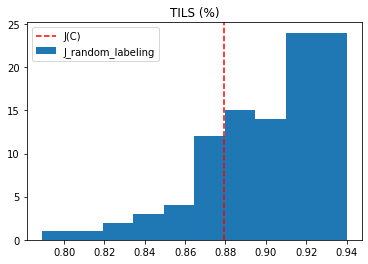

    ID_number TILS (%)
0   SCAN_0158        A
1   SCAN_0197        A
2   SCAN_0183        A
3   SCAN_0458        A
4   SCAN_0062        A
5   SCAN_0198        B
6   SCAN_0135        B
7   SCAN_0087        B
8   SCAN_0095        B
9   SCAN_0106        B
10  SCAN_0285        C
11  SCAN_0162        C
12  SCAN_0228        C
13  SCAN_0170        C
14  SCAN_0150        C
torch.Size([2, 1, 1])
J_C:  0.8040219177530661
mean hist:  0.8174256636855461
0.01340374593248006


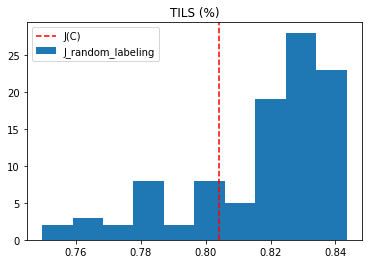

    ID_number TILS (%)
0   SCAN_0192        A
1   SCAN_0061        A
2   SCAN_0112        A
3   SCAN_0467        A
4   SCAN_0071        A
5   SCAN_0326        B
6   SCAN_0291        B
7   SCAN_0114        B
8   SCAN_0233        B
9   SCAN_0276        B
10  SCAN_0265        C
11  SCAN_0263        C
12  SCAN_0213        C
13  SCAN_0132        C
14  SCAN_0056        C
torch.Size([2, 1, 1])
J_C:  0.8308832369368272
mean hist:  0.8499705901650333
0.019087353228206094


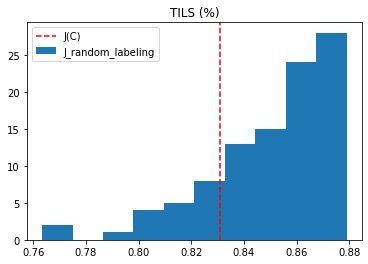

In [109]:
label = 'TILS (%)'
for i in range(10):
    sampled_df = get_dataset_continous(label, i)
    print(sampled_df)
    dataset = BiopsyDataset100("/storage/Chloe/zoom_20_512", sampled_df, label, transform=transform)
    distance, mean, percentage = binning_eval(dataset, sampled_df, encoder, label)
    new_row = {'Label': label, 'Encoder': '2', 'Distance': distance, 'Mean of distribution': mean, "Percentage": percentage}
    df_results = df_results.append(new_row, ignore_index=True)

    ID_number MYC
0   SCAN_0056   A
1   SCAN_0089   A
2   SCAN_0290   A
3   SCAN_0262   A
4   SCAN_0174   A
5   SCAN_0099   B
6   SCAN_0092   B
7   SCAN_0071   B
8   SCAN_0286   B
9   SCAN_0323   B
10  SCAN_0192   C
11  SCAN_0205   C
12  SCAN_0471   C
13  SCAN_0097   C
14  SCAN_0199   C
torch.Size([2, 1, 1])
J_C:  0.8243461972661316
mean hist:  0.8000008841265458
-0.024345313139585767


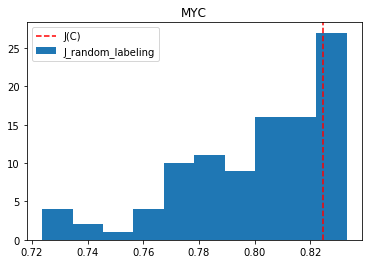

    ID_number MYC
0   SCAN_0296   A
1   SCAN_0202   A
2   SCAN_0266   A
3   SCAN_0292   A
4   SCAN_0325   A
5   SCAN_0096   B
6   SCAN_0322   B
7   SCAN_0065   B
8   SCAN_0318   B
9   SCAN_0204   B
10  SCAN_0198   C
11  SCAN_0180   C
12  SCAN_0157   C
13  SCAN_0197   C
14  SCAN_0123   C
torch.Size([2, 1, 1])
J_C:  0.7747603356155256
mean hist:  0.7676678846502
-0.007092450965325625


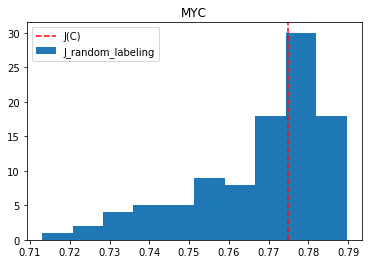

    ID_number MYC
0   SCAN_0293   A
1   SCAN_0111   A
2   SCAN_0251   A
3   SCAN_0056   A
4   SCAN_0119   A
5   SCAN_0115   B
6   SCAN_0323   B
7   SCAN_0063   B
8   SCAN_0173   B
9   SCAN_0465   B
10  SCAN_0209   C
11  SCAN_0098   C
12  SCAN_0205   C
13  SCAN_0129   C
14  SCAN_0219   C
torch.Size([2, 1, 1])
J_C:  1.0006790914919301
mean hist:  0.9598137628045168
-0.04086532868741333


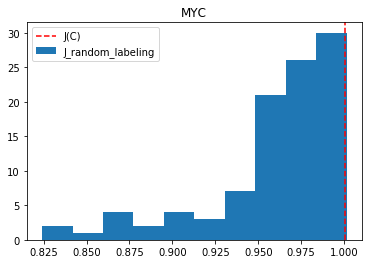

    ID_number MYC
0   SCAN_0215   A
1   SCAN_0161   A
2   SCAN_0457   A
3   SCAN_0468   A
4   SCAN_0257   A
5   SCAN_0115   B
6   SCAN_0065   B
7   SCAN_0216   B
8   SCAN_0126   B
9   SCAN_0162   B
10  SCAN_0235   C
11  SCAN_0217   C
12  SCAN_0137   C
13  SCAN_0462   C
14  SCAN_0134   C
torch.Size([2, 1, 1])
J_C:  0.9974456583267698
mean hist:  0.9757130035902343
-0.021732654736535517


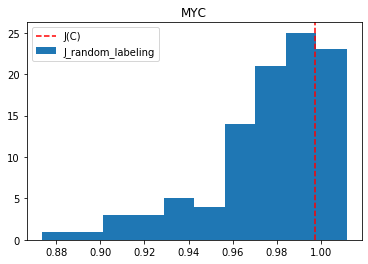

    ID_number MYC
0   SCAN_0089   A
1   SCAN_0316   A
2   SCAN_0251   A
3   SCAN_0085   A
4   SCAN_0290   A
5   SCAN_0258   B
6   SCAN_0173   B
7   SCAN_0272   B
8   SCAN_0274   B
9   SCAN_0090   B
10  SCAN_0231   C
11  SCAN_0058   C
12  SCAN_0195   C
13  SCAN_0200   C
14  SCAN_0157   C
torch.Size([2, 1, 1])
J_C:  0.8088278631506371
mean hist:  0.7827464162421962
-0.02608144690844094


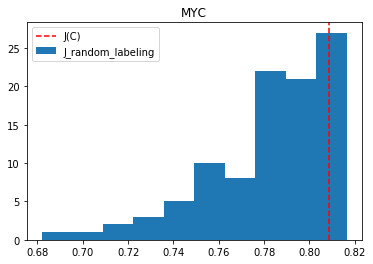

    ID_number MYC
0   SCAN_0257   A
1   SCAN_0253   A
2   SCAN_0295   A
3   SCAN_0298   A
4   SCAN_0232   A
5   SCAN_0272   B
6   SCAN_0065   B
7   SCAN_0122   B
8   SCAN_0322   B
9   SCAN_0310   B
10  SCAN_0211   C
11  SCAN_0196   C
12  SCAN_0124   C
13  SCAN_0195   C
14  SCAN_0315   C
torch.Size([2, 1, 1])
J_C:  0.7783434750400483
mean hist:  0.7496836070596968
-0.028659867980351472


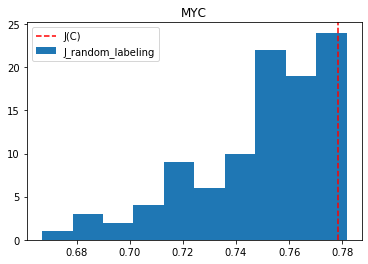

    ID_number MYC
0   SCAN_0291   A
1   SCAN_0109   A
2   SCAN_0119   A
3   SCAN_0141   A
4   SCAN_0054   A
5   SCAN_0281   B
6   SCAN_0077   B
7   SCAN_0248   B
8   SCAN_0181   B
9   SCAN_0310   B
10  SCAN_0139   C
11  SCAN_0287   C
12  SCAN_0222   C
13  SCAN_0157   C
14  SCAN_0170   C
torch.Size([2, 1, 1])
J_C:  0.8105875645668057
mean hist:  0.826690665346409
0.016103100779603308


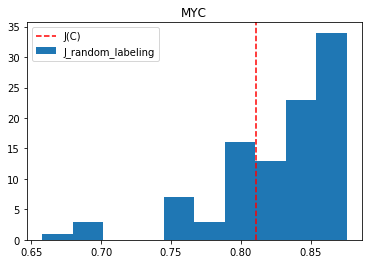

    ID_number MYC
0   SCAN_0106   A
1   SCAN_0118   A
2   SCAN_0320   A
3   SCAN_0296   A
4   SCAN_0253   A
5   SCAN_0077   B
6   SCAN_0100   B
7   SCAN_0090   B
8   SCAN_0145   B
9   SCAN_0307   B
10  SCAN_0194   C
11  SCAN_0178   C
12  SCAN_0193   C
13  SCAN_0200   C
14  SCAN_0170   C
torch.Size([2, 1, 1])
J_C:  0.7248079987832832
mean hist:  0.7875682872070223
0.06276028842373915


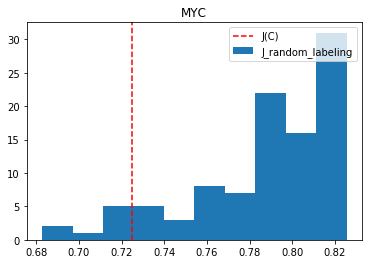

    ID_number MYC
0   SCAN_0251   A
1   SCAN_0202   A
2   SCAN_0296   A
3   SCAN_0461   A
4   SCAN_0277   A
5   SCAN_0216   B
6   SCAN_0204   B
7   SCAN_0260   B
8   SCAN_0062   B
9   SCAN_0258   B
10  SCAN_0163   C
11  SCAN_0177   C
12  SCAN_0188   C
13  SCAN_0205   C
14  SCAN_0460   C
torch.Size([2, 1, 1])
J_C:  0.6488542207380978
mean hist:  0.6826451187961937
0.033790898058095875


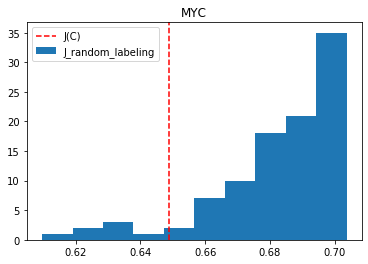

    ID_number MYC
0   SCAN_0268   A
1   SCAN_0136   A
2   SCAN_0292   A
3   SCAN_0317   A
4   SCAN_0319   A
5   SCAN_0084   B
6   SCAN_0322   B
7   SCAN_0162   B
8   SCAN_0328   B
9   SCAN_0263   B
10  SCAN_0165   C
11  SCAN_0132   C
12  SCAN_0156   C
13  SCAN_0113   C
14  SCAN_0167   C
torch.Size([2, 1, 1])
J_C:  0.7978703404000234
mean hist:  0.7853768832971708
-0.012493457102852545


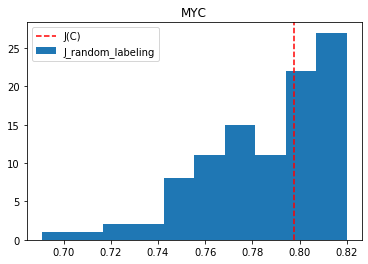

In [110]:
label = 'MYC'
for i in range(10):
    sampled_df = get_dataset_continous(label, i)
    print(sampled_df)
    dataset = BiopsyDataset100("/storage/Chloe/zoom_20_512", sampled_df, label, transform=transform)
    distance, mean, percentage = binning_eval(dataset, sampled_df, encoder, label)
    new_row = {'Label': label, 'Encoder': '2', 'Distance': distance, 'Mean of distribution': mean, "Percentage": percentage}
    df_results = df_results.append(new_row, ignore_index=True)

    ID_number FOXA1
0   SCAN_0070     A
1   SCAN_0143     A
2   SCAN_0182     A
3   SCAN_0165     A
4   SCAN_0237     A
5   SCAN_0089     B
6   SCAN_0085     B
7   SCAN_0069     B
8   SCAN_0280     B
9   SCAN_0298     B
10  SCAN_0290     C
11  SCAN_0316     C
12  SCAN_0471     C
13  SCAN_0078     C
14  SCAN_0307     C
torch.Size([2, 1, 1])
J_C:  0.8734813891357436
mean hist:  0.849964977689708
-0.023516411446035557


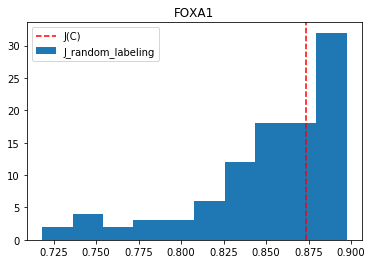

    ID_number FOXA1
0   SCAN_0190     A
1   SCAN_0241     A
2   SCAN_0167     A
3   SCAN_0184     A
4   SCAN_0216     A
5   SCAN_0087     B
6   SCAN_0297     B
7   SCAN_0057     B
8   SCAN_0292     B
9   SCAN_0188     B
10  SCAN_0306     C
11  SCAN_0278     C
12  SCAN_0111     C
13  SCAN_0304     C
14  SCAN_0088     C
torch.Size([2, 1, 1])
J_C:  0.6865743139013648
mean hist:  0.6933932014905771
0.006818887589212341


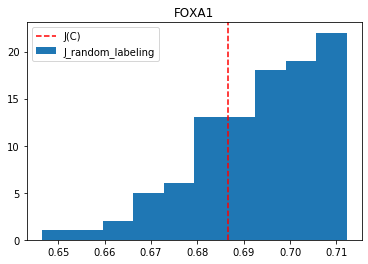

    ID_number FOXA1
0   SCAN_0186     A
1   SCAN_0267     A
2   SCAN_0326     A
3   SCAN_0070     A
4   SCAN_0276     A
5   SCAN_0116     B
6   SCAN_0298     B
7   SCAN_0056     B
8   SCAN_0466     B
9   SCAN_0329     B
10  SCAN_0322     C
11  SCAN_0079     C
12  SCAN_0316     C
13  SCAN_0091     C
14  SCAN_0467     C
torch.Size([2, 1, 1])
J_C:  0.8522279890461653
mean hist:  0.8843784207496194
0.03215043170345411


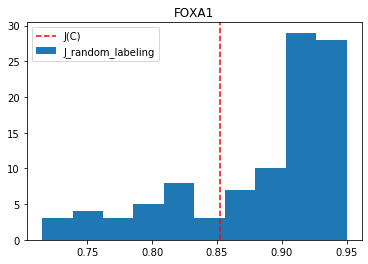

    ID_number FOXA1
0   SCAN_0469     A
1   SCAN_0235     A
2   SCAN_0225     A
3   SCAN_0234     A
4   SCAN_0163     A
5   SCAN_0116     B
6   SCAN_0057     B
7   SCAN_0204     B
8   SCAN_0131     B
9   SCAN_0458     B
10  SCAN_0213     C
11  SCAN_0462     C
12  SCAN_0099     C
13  SCAN_0253     C
14  SCAN_0098     C
torch.Size([2, 1, 1])
J_C:  0.8046439055272688
mean hist:  0.8217152550948547
0.017071349567585825


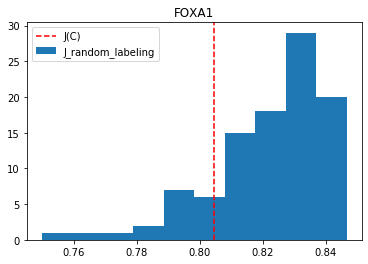

    ID_number FOXA1
0   SCAN_0143     A
1   SCAN_0207     A
2   SCAN_0326     A
3   SCAN_0132     A
4   SCAN_0182     A
5   SCAN_0246     B
6   SCAN_0466     B
7   SCAN_0272     B
8   SCAN_0274     B
9   SCAN_0084     B
10  SCAN_0193     C
11  SCAN_0058     C
12  SCAN_0299     C
13  SCAN_0310     C
14  SCAN_0111     C
torch.Size([2, 1, 1])
J_C:  0.8832374624647026
mean hist:  0.8586876590976326
-0.024549803367070022


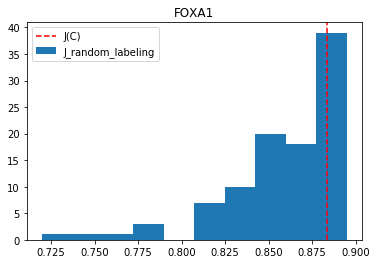

    ID_number FOXA1
0   SCAN_0163     A
1   SCAN_0460     A
2   SCAN_0189     A
3   SCAN_0196     A
4   SCAN_0470     A
5   SCAN_0272     B
6   SCAN_0057     B
7   SCAN_0130     B
8   SCAN_0297     B
9   SCAN_0287     B
10  SCAN_0325     C
11  SCAN_0301     C
12  SCAN_0090     C
13  SCAN_0299     C
14  SCAN_0157     C
torch.Size([2, 1, 1])
J_C:  0.754961202458789
mean hist:  0.7400264654502009
-0.01493473700858805


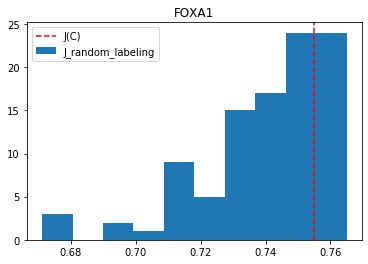

    ID_number FOXA1
0   SCAN_0183     A
1   SCAN_0260     A
2   SCAN_0276     A
3   SCAN_0305     A
4   SCAN_0064     A
5   SCAN_0275     B
6   SCAN_0076     B
7   SCAN_0148     B
8   SCAN_0164     B
9   SCAN_0287     B
10  SCAN_0102     C
11  SCAN_0125     C
12  SCAN_0468     C
13  SCAN_0111     C
14  SCAN_0264     C
torch.Size([2, 1, 1])
J_C:  0.7874638260124872
mean hist:  0.8505021292866006
0.06303830327411342


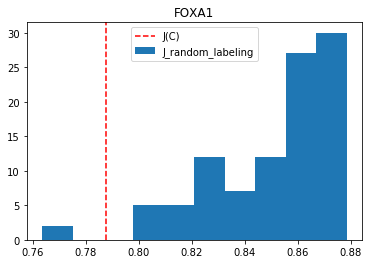

    ID_number FOXA1
0   SCAN_0155     A
1   SCAN_0268     A
2   SCAN_0212     A
3   SCAN_0190     A
4   SCAN_0460     A
5   SCAN_0076     B
6   SCAN_0094     B
7   SCAN_0084     B
8   SCAN_0137     B
9   SCAN_0285     B
10  SCAN_0293     C
11  SCAN_0271     C
12  SCAN_0291     C
13  SCAN_0310     C
14  SCAN_0264     C
torch.Size([2, 1, 1])
J_C:  0.8332478372802337
mean hist:  0.8756104074160335
0.042362570135799804


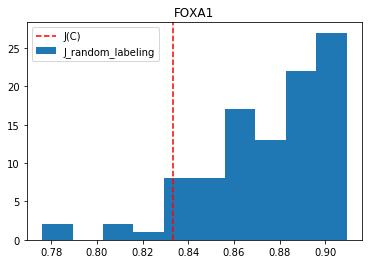

    ID_number FOXA1
0   SCAN_0326     A
1   SCAN_0241     A
2   SCAN_0190     A
3   SCAN_0228     A
4   SCAN_0171     A
5   SCAN_0204     B
6   SCAN_0188     B
7   SCAN_0249     B
8   SCAN_0055     B
9   SCAN_0246     B
10  SCAN_0257     C
11  SCAN_0270     C
12  SCAN_0283     C
13  SCAN_0316     C
14  SCAN_0251     C
torch.Size([2, 1, 1])
J_C:  0.6077115703374147
mean hist:  0.595837645160517
-0.011873925176897782


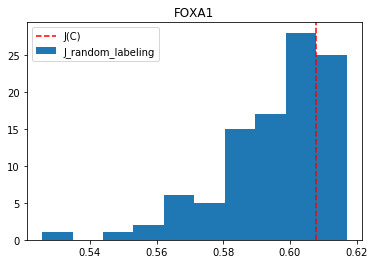

    ID_number FOXA1
0   SCAN_0169     A
1   SCAN_0296     A
2   SCAN_0184     A
3   SCAN_0210     A
4   SCAN_0211     A
5   SCAN_0082     B
6   SCAN_0297     B
7   SCAN_0458     B
8   SCAN_0317     B
9   SCAN_0252     B
10  SCAN_0258     C
11  SCAN_0093     C
12  SCAN_0110     C
13  SCAN_0086     C
14  SCAN_0261     C
torch.Size([2, 1, 1])
J_C:  0.7955095929838717
mean hist:  0.8375058796109631
0.04199628662709143


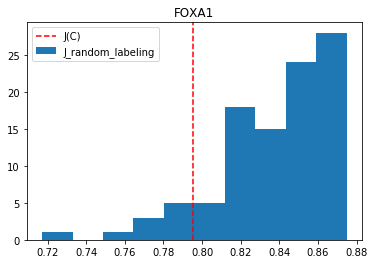

In [111]:
label = 'FOXA1'
for i in range(10):
    sampled_df = get_dataset_continous(label, i)
    print(sampled_df)
    dataset = BiopsyDataset100("/storage/Chloe/zoom_20_512", sampled_df, label, transform=transform)
    distance, mean, percentage = binning_eval(dataset, sampled_df, encoder, label)
    new_row = {'Label': label, 'Encoder': '2', 'Distance': distance, 'Mean of distribution': mean, "Percentage": percentage}
    df_results = df_results.append(new_row, ignore_index=True)

    ID_number HIF1A
0   SCAN_0061     A
1   SCAN_0081     A
2   SCAN_0271     A
3   SCAN_0150     A
4   SCAN_0215     A
5   SCAN_0115     B
6   SCAN_0110     B
7   SCAN_0082     B
8   SCAN_0305     B
9   SCAN_0328     B
10  SCAN_0169     C
11  SCAN_0189     C
12  SCAN_0469     C
13  SCAN_0098     C
14  SCAN_0181     C
torch.Size([2, 1, 1])
J_C:  0.9112191087758803
mean hist:  0.881157713840306
-0.03006139493557436


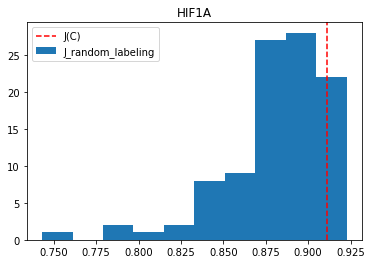

    ID_number HIF1A
0   SCAN_0291     A
1   SCAN_0222     A
2   SCAN_0156     A
3   SCAN_0276     A
4   SCAN_0463     A
5   SCAN_0114     B
6   SCAN_0327     B
7   SCAN_0071     B
8   SCAN_0321     B
9   SCAN_0205     B
10  SCAN_0178     C
11  SCAN_0162     C
12  SCAN_0258     C
13  SCAN_0177     C
14  SCAN_0130     C
torch.Size([2, 1, 1])
J_C:  0.7215855058624099
mean hist:  0.7239937595854936
0.002408253723083731


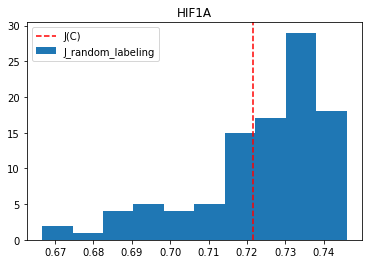

    ID_number HIF1A
0   SCAN_0277     A
1   SCAN_0093     A
2   SCAN_0132     A
3   SCAN_0061     A
4   SCAN_0097     A
5   SCAN_0131     B
6   SCAN_0328     B
7   SCAN_0066     B
8   SCAN_0182     B
9   SCAN_0160     B
10  SCAN_0202     C
11  SCAN_0103     C
12  SCAN_0189     C
13  SCAN_0137     C
14  SCAN_0218     C
torch.Size([2, 1, 1])
J_C:  0.8817599188954136
mean hist:  0.8497089720930002
-0.03205094680241338


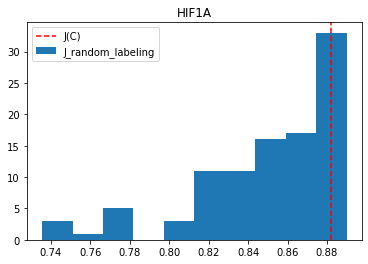

    ID_number HIF1A
0   SCAN_0223     A
1   SCAN_0208     A
2   SCAN_0168     A
3   SCAN_0200     A
4   SCAN_0147     A
5   SCAN_0131     B
6   SCAN_0071     B
7   SCAN_0210     B
8   SCAN_0143     B
9   SCAN_0173     B
10  SCAN_0234     C
11  SCAN_0213     C
12  SCAN_0146     C
13  SCAN_0301     C
14  SCAN_0145     C
torch.Size([2, 1, 1])
J_C:  0.790577414787064
mean hist:  0.7651239753095871
-0.025453439477476913


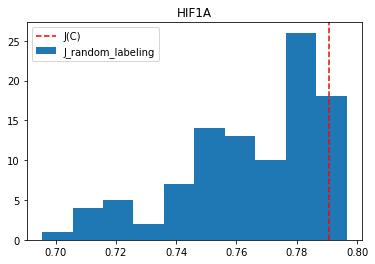

    ID_number HIF1A
0   SCAN_0081     A
1   SCAN_0324     A
2   SCAN_0132     A
3   SCAN_0073     A
4   SCAN_0271     A
5   SCAN_0273     B
6   SCAN_0182     B
7   SCAN_0294     B
8   SCAN_0298     B
9   SCAN_0109     B
10  SCAN_0231     C
11  SCAN_0054     C
12  SCAN_0175     C
13  SCAN_0184     C
14  SCAN_0258     C
torch.Size([2, 1, 1])
J_C:  0.8189414561234707
mean hist:  0.8055166434331663
-0.013424812690304377


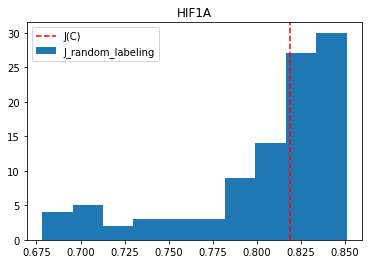

    ID_number HIF1A
0   SCAN_0147     A
1   SCAN_0136     A
2   SCAN_0283     A
3   SCAN_0303     A
4   SCAN_0471     A
5   SCAN_0294     B
6   SCAN_0071     B
7   SCAN_0140     B
8   SCAN_0327     B
9   SCAN_0314     B
10  SCAN_0207     C
11  SCAN_0176     C
12  SCAN_0134     C
13  SCAN_0175     C
14  SCAN_0295     C
torch.Size([2, 1, 1])
J_C:  0.9019098731789839
mean hist:  0.8964046177696773
-0.005505255409306575


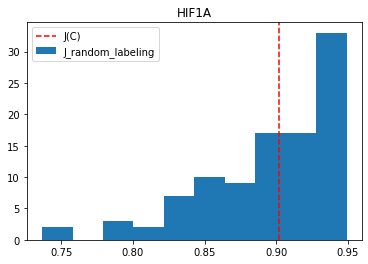

    ID_number HIF1A
0   SCAN_0275     A
1   SCAN_0092     A
2   SCAN_0097     A
3   SCAN_0113     A
4   SCAN_0055     A
5   SCAN_0300     B
6   SCAN_0095     B
7   SCAN_0262     B
8   SCAN_0183     B
9   SCAN_0314     B
10  SCAN_0151     C
11  SCAN_0285     C
12  SCAN_0219     C
13  SCAN_0258     C
14  SCAN_0329     C
torch.Size([2, 1, 1])
J_C:  0.7291401667799274
mean hist:  0.7336178044629611
0.004477637683033664


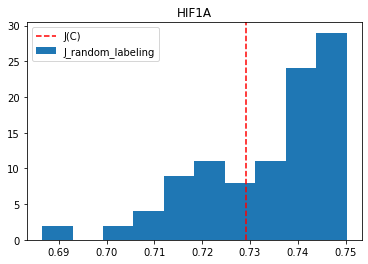

    ID_number HIF1A
0   SCAN_0090     A
1   SCAN_0096     A
2   SCAN_0457     A
3   SCAN_0291     A
4   SCAN_0136     A
5   SCAN_0095     B
6   SCAN_0116     B
7   SCAN_0109     B
8   SCAN_0252     B
9   SCAN_0312     B
10  SCAN_0171     C
11  SCAN_0468     C
12  SCAN_0170     C
13  SCAN_0184     C
14  SCAN_0329     C
torch.Size([2, 1, 1])
J_C:  0.9141996887524922
mean hist:  0.9797447840580421
0.06554509530554986


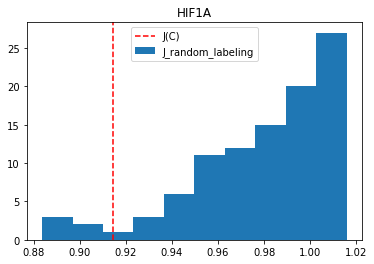

    ID_number HIF1A
0   SCAN_0132     A
1   SCAN_0222     A
2   SCAN_0291     A
3   SCAN_0191     A
4   SCAN_0256     A
5   SCAN_0210     B
6   SCAN_0205     B
7   SCAN_0278     B
8   SCAN_0058     B
9   SCAN_0273     B
10  SCAN_0317     C
11  SCAN_0462     C
12  SCAN_0164     C
13  SCAN_0189     C
14  SCAN_0296     C
torch.Size([2, 1, 1])
J_C:  0.7169949368010209
mean hist:  0.7626965292813243
0.045701592480303366


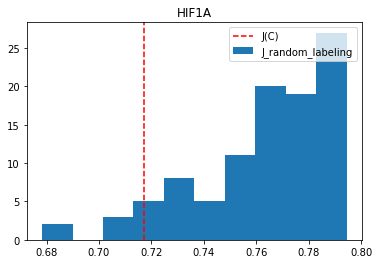

    ID_number HIF1A
0   SCAN_0253     A
1   SCAN_0111     A
2   SCAN_0276     A
3   SCAN_0325     A
4   SCAN_0455     A
5   SCAN_0108     B
6   SCAN_0327     B
7   SCAN_0173     B
8   SCAN_0465     B
9   SCAN_0281     B
10  SCAN_0322     C
11  SCAN_0144     C
12  SCAN_0257     C
13  SCAN_0128     C
14  SCAN_0323     C
torch.Size([2, 1, 1])
J_C:  0.9624550204438468
mean hist:  0.9132104161972275
-0.04924460424661925


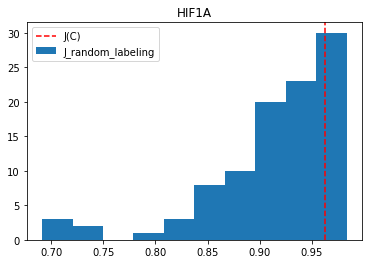

In [112]:
label = 'HIF1A'
for i in range(10):
    sampled_df = get_dataset_continous(label, i)
    print(sampled_df)
    dataset = BiopsyDataset100("/storage/Chloe/zoom_20_512", sampled_df, label, transform=transform)
    distance, mean, percentage = binning_eval(dataset, sampled_df, encoder, label)
    new_row = {'Label': label, 'Encoder': '2', 'Distance': distance, 'Mean of distribution': mean, "Percentage": percentage}
    df_results = df_results.append(new_row, ignore_index=True)
    

    ID_number ROR.S.Group..Subtype.Only.
0   SCAN_0311                          0
1   SCAN_0292                          0
2   SCAN_0190                          0
3   SCAN_0329                          0
4   SCAN_0259                          0
5   SCAN_0115                          1
6   SCAN_0111                          1
7   SCAN_0181                          1
8   SCAN_0097                          1
9   SCAN_0248                          1
10  SCAN_0313                          2
11  SCAN_0238                          2
12  SCAN_0145                          2
13  SCAN_0134                          2
14  SCAN_0112                          2
torch.Size([2, 1, 1])
J_C:  0.833757981195425
mean hist:  0.8760479768024618
0.042289995607036834


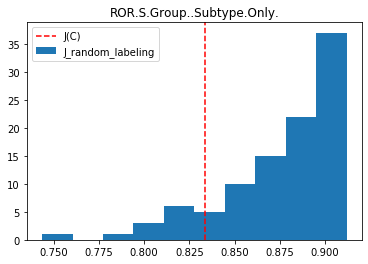

    ID_number ROR.S.Group..Subtype.Only.
0   SCAN_0233                          0
1   SCAN_0212                          0
2   SCAN_0459                          0
3   SCAN_0460                          0
4   SCAN_0301                          0
5   SCAN_0094                          1
6   SCAN_0137                          1
7   SCAN_0248                          1
8   SCAN_0209                          1
9   SCAN_0136                          1
10  SCAN_0112                          2
11  SCAN_0082                          2
12  SCAN_0253                          2
13  SCAN_0145                          2
14  SCAN_0129                          2
torch.Size([2, 1, 1])
J_C:  0.9024455151179184
mean hist:  0.952360684049391
0.04991516893147263


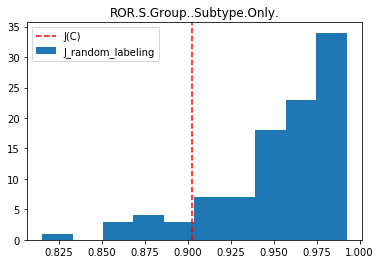

    ID_number ROR.S.Group..Subtype.Only.
0   SCAN_0197                          0
1   SCAN_0305                          0
2   SCAN_0266                          0
3   SCAN_0250                          0
4   SCAN_0298                          0
5   SCAN_0090                          1
6   SCAN_0138                          1
7   SCAN_0461                          1
8   SCAN_0078                          1
9   SCAN_0265                          1
10  SCAN_0268                          2
11  SCAN_0128                          2
12  SCAN_0134                          2
13  SCAN_0130                          2
14  SCAN_0154                          2
torch.Size([2, 1, 1])
J_C:  0.8831080905512596
mean hist:  0.9461209962241195
0.06301290567285989


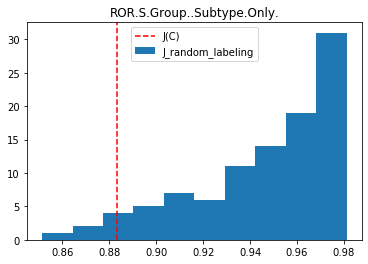

    ID_number ROR.S.Group..Subtype.Only.
0   SCAN_0304                          0
1   SCAN_0259                          0
2   SCAN_0221                          0
3   SCAN_0302                          0
4   SCAN_0254                          0
5   SCAN_0081                          1
6   SCAN_0084                          1
7   SCAN_0186                          1
8   SCAN_0060                          1
9   SCAN_0127                          1
10  SCAN_0232                          2
11  SCAN_0318                          2
12  SCAN_0150                          2
13  SCAN_0092                          2
14  SCAN_0135                          2
torch.Size([2, 1, 1])
J_C:  0.8293419544658575
mean hist:  0.8456697455446927
0.016327791078835197


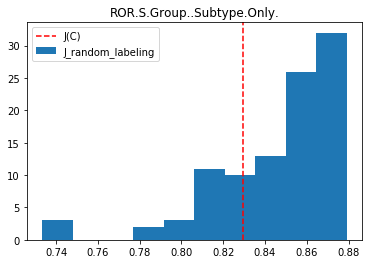

    ID_number ROR.S.Group..Subtype.Only.
0   SCAN_0254                          0
1   SCAN_0292                          0
2   SCAN_0297                          0
3   SCAN_0467                          0
4   SCAN_0282                          0
5   SCAN_0314                          1
6   SCAN_0054                          1
7   SCAN_0101                          1
8   SCAN_0148                          1
9   SCAN_0270                          1
10  SCAN_0056                          2
11  SCAN_0238                          2
12  SCAN_0092                          2
13  SCAN_0068                          2
14  SCAN_0129                          2
torch.Size([2, 1, 1])
J_C:  0.8558497682876759
mean hist:  0.8972635393686755
0.04141377108099964


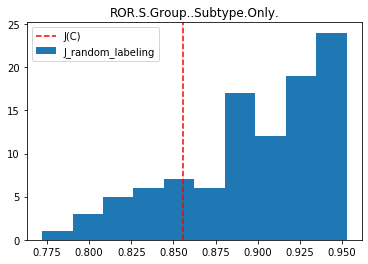

    ID_number ROR.S.Group..Subtype.Only.
0   SCAN_0185                          0
1   SCAN_0326                          0
2   SCAN_0277                          0
3   SCAN_0291                          0
4   SCAN_0212                          0
5   SCAN_0088                          1
6   SCAN_0148                          1
7   SCAN_0283                          1
8   SCAN_0140                          1
9   SCAN_0094                          1
10  SCAN_0100                          2
11  SCAN_0284                          2
12  SCAN_0103                          2
13  SCAN_0129                          2
14  SCAN_0082                          2
torch.Size([2, 1, 1])
J_C:  0.9100541813804185
mean hist:  0.9619663711923334
0.05191218981191492


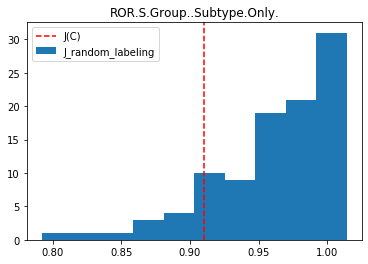

    ID_number ROR.S.Group..Subtype.Only.
0   SCAN_0231                          0
1   SCAN_0211                          0
2   SCAN_0295                          0
3   SCAN_0208                          0
4   SCAN_0058                          0
5   SCAN_0186                          1
6   SCAN_0138                          1
7   SCAN_0133                          1
8   SCAN_0060                          1
9   SCAN_0078                          1
10  SCAN_0108                          2
11  SCAN_0100                          2
12  SCAN_0109                          2
13  SCAN_0132                          2
14  SCAN_0141                          2
torch.Size([2, 1, 1])
J_C:  0.9204446386975833
mean hist:  1.021562506917639
0.10111786822005575


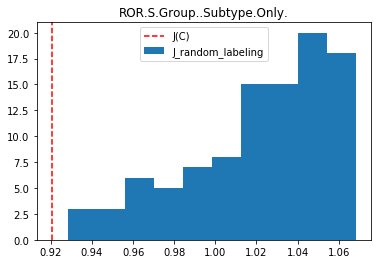

    ID_number ROR.S.Group..Subtype.Only.
0   SCAN_0192                          0
1   SCAN_0231                          0
2   SCAN_0471                          0
3   SCAN_0240                          0
4   SCAN_0312                          0
5   SCAN_0469                          1
6   SCAN_0126                          1
7   SCAN_0265                          1
8   SCAN_0089                          1
9   SCAN_0307                          1
10  SCAN_0144                          2
11  SCAN_0117                          2
12  SCAN_0128                          2
13  SCAN_0150                          2
14  SCAN_0086                          2
torch.Size([2, 1, 1])
J_C:  0.9795235948542964
mean hist:  0.9629627803227914
-0.01656081453150504


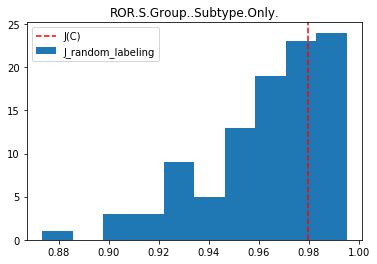

    ID_number ROR.S.Group..Subtype.Only.
0   SCAN_0224                          0
1   SCAN_0225                          0
2   SCAN_0167                          0
3   SCAN_0191                          0
4   SCAN_0251                          0
5   SCAN_0148                          1
6   SCAN_0252                          1
7   SCAN_0084                          1
8   SCAN_0275                          1
9   SCAN_0075                          1
10  SCAN_0313                          2
11  SCAN_0323                          2
12  SCAN_0150                          2
13  SCAN_0156                          2
14  SCAN_0157                          2
torch.Size([2, 1, 1])
J_C:  0.8534854832479416
mean hist:  0.8827990787802987
0.02931359553235713


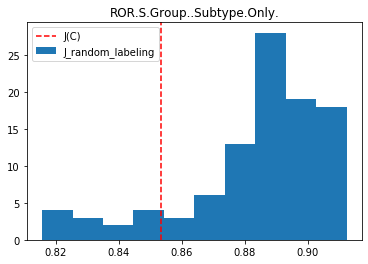

    ID_number ROR.S.Group..Subtype.Only.
0   SCAN_0259                          0
1   SCAN_0250                          0
2   SCAN_0310                          0
3   SCAN_0189                          0
4   SCAN_0263                          0
5   SCAN_0062                          1
6   SCAN_0160                          1
7   SCAN_0281                          1
8   SCAN_0127                          1
9   SCAN_0102                          1
10  SCAN_0142                          2
11  SCAN_0063                          2
12  SCAN_0156                          2
13  SCAN_0114                          2
14  SCAN_0145                          2
torch.Size([2, 1, 1])
J_C:  0.8440785650772352
mean hist:  0.8643247377286322
0.020246172651396943


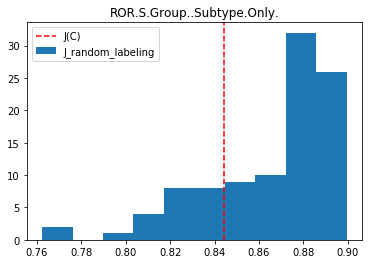

In [113]:
label = 'ROR.S.Group..Subtype.Only.'
for i in range(10):
    sampled_df = get_dataset_ROR(label, i)
    print(sampled_df)
    dataset = BiopsyDataset100("/storage/Chloe/zoom_20_512", sampled_df, label, transform=transform)
    distance, mean, percentage = binning_eval(dataset, sampled_df, encoder, label)
    new_row = {'Label': label, 'Encoder': '2', 'Distance': distance, 'Mean of distribution': mean, "Percentage": percentage}
    df_results = df_results.append(new_row, ignore_index=True)

    ID_number ROR.P.Group..Subtype...Proliferation.
0   SCAN_0203                                     0
1   SCAN_0208                                     0
2   SCAN_0308                                     0
3   SCAN_0470                                     0
4   SCAN_0329                                     0
5   SCAN_0124                                     1
6   SCAN_0210                                     1
7   SCAN_0461                                     1
8   SCAN_0464                                     1
9   SCAN_0314                                     1
10  SCAN_0074                                     2
11  SCAN_0092                                     2
12  SCAN_0063                                     2
13  SCAN_0072                                     2
14  SCAN_0109                                     2
torch.Size([2, 1, 1])
J_C:  0.8180971211889603
mean hist:  0.8946478155115689
0.07655069432260864


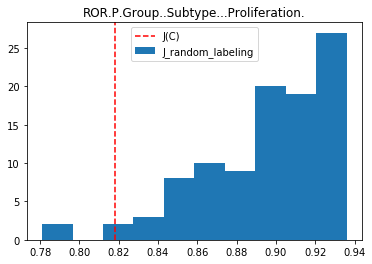

    ID_number ROR.P.Group..Subtype...Proliferation.
0   SCAN_0299                                     0
1   SCAN_0207                                     0
2   SCAN_0277                                     0
3   SCAN_0236                                     0
4   SCAN_0206                                     0
5   SCAN_0161                                     1
6   SCAN_0301                                     1
7   SCAN_0105                                     1
8   SCAN_0317                                     1
9   SCAN_0254                                     1
10  SCAN_0123                                     2
11  SCAN_0275                                     2
12  SCAN_0194                                     2
13  SCAN_0323                                     2
14  SCAN_0068                                     2
torch.Size([2, 1, 1])
J_C:  0.816915234545309
mean hist:  0.8138045291395797
-0.0031107054057293304


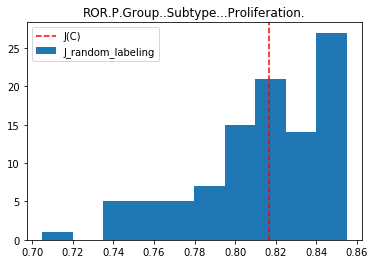

    ID_number ROR.P.Group..Subtype...Proliferation.
0   SCAN_0234                                     0
1   SCAN_0217                                     0
2   SCAN_0470                                     0
3   SCAN_0256                                     0
4   SCAN_0460                                     0
5   SCAN_0174                                     1
6   SCAN_0104                                     1
7   SCAN_0173                                     1
8   SCAN_0161                                     1
9   SCAN_0101                                     1
10  SCAN_0289                                     2
11  SCAN_0144                                     2
12  SCAN_0286                                     2
13  SCAN_0093                                     2
14  SCAN_0327                                     2
torch.Size([2, 1, 1])
J_C:  0.7790064429628352
mean hist:  0.7784558328442066
-0.0005506101186285584


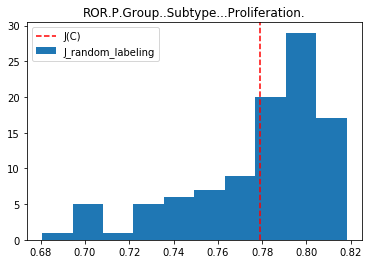

    ID_number ROR.P.Group..Subtype...Proliferation.
0   SCAN_0462                                     0
1   SCAN_0163                                     0
2   SCAN_0295                                     0
3   SCAN_0192                                     0
4   SCAN_0272                                     0
5   SCAN_0260                                     1
6   SCAN_0251                                     1
7   SCAN_0221                                     1
8   SCAN_0213                                     1
9   SCAN_0110                                     1
10  SCAN_0463                                     2
11  SCAN_0133                                     2
12  SCAN_0056                                     2
13  SCAN_0073                                     2
14  SCAN_0082                                     2
torch.Size([2, 1, 1])
J_C:  0.7549070878820494
mean hist:  0.8387024778538946
0.08379538997184521


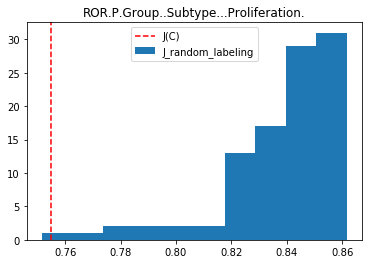

    ID_number ROR.P.Group..Subtype...Proliferation.
0   SCAN_0197                                     0
1   SCAN_0225                                     0
2   SCAN_0214                                     0
3   SCAN_0196                                     0
4   SCAN_0293                                     0
5   SCAN_0231                                     1
6   SCAN_0105                                     1
7   SCAN_0226                                     1
8   SCAN_0240                                     1
9   SCAN_0188                                     1
10  SCAN_0156                                     2
11  SCAN_0054                                     2
12  SCAN_0125                                     2
13  SCAN_0130                                     2
14  SCAN_0232                                     2
torch.Size([2, 1, 1])
J_C:  0.7840632307827472
mean hist:  0.7852049627740351
0.0011417319912878643


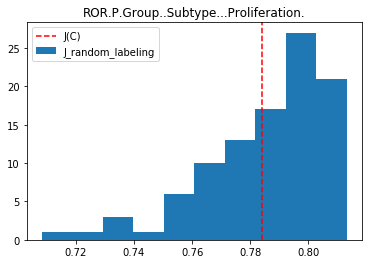

    ID_number ROR.P.Group..Subtype...Proliferation.
0   SCAN_0315                                     0
1   SCAN_0319                                     0
2   SCAN_0277                                     0
3   SCAN_0158                                     0
4   SCAN_0218                                     0
5   SCAN_0058                                     1
6   SCAN_0185                                     1
7   SCAN_0466                                     1
8   SCAN_0227                                     1
9   SCAN_0101                                     1
10  SCAN_0128                                     2
11  SCAN_0108                                     2
12  SCAN_0143                                     2
13  SCAN_0268                                     2
14  SCAN_0123                                     2
torch.Size([2, 1, 1])
J_C:  0.9457529503410146
mean hist:  0.9294070218156779
-0.016345928525336673


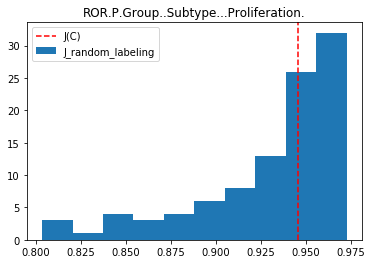

    ID_number ROR.P.Group..Subtype...Proliferation.
0   SCAN_0459                                     0
1   SCAN_0158                                     0
2   SCAN_0311                                     0
3   SCAN_0211                                     0
4   SCAN_0207                                     0
5   SCAN_0104                                     1
6   SCAN_0285                                     1
7   SCAN_0091                                     1
8   SCAN_0188                                     1
9   SCAN_0310                                     1
10  SCAN_0136                                     2
11  SCAN_0255                                     2
12  SCAN_0113                                     2
13  SCAN_0258                                     2
14  SCAN_0076                                     2
torch.Size([2, 1, 1])
J_C:  0.833644224666059
mean hist:  0.8352358972738735
0.0015916726078144539


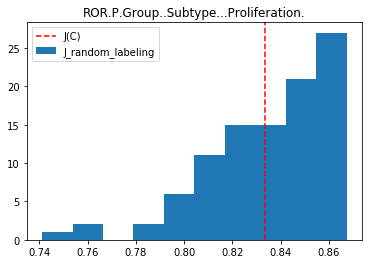

    ID_number ROR.P.Group..Subtype...Proliferation.
0   SCAN_0204                                     0
1   SCAN_0163                                     0
2   SCAN_0234                                     0
3   SCAN_0296                                     0
4   SCAN_0182                                     0
5   SCAN_0322                                     1
6   SCAN_0161                                     1
7   SCAN_0213                                     1
8   SCAN_0171                                     1
9   SCAN_0324                                     1
10  SCAN_0095                                     2
11  SCAN_0327                                     2
12  SCAN_0080                                     2
13  SCAN_0083                                     2
14  SCAN_0077                                     2
torch.Size([2, 1, 1])
J_C:  0.6415610781788763
mean hist:  0.6813416508386257
0.039780572659749436


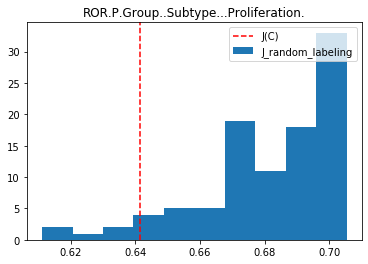

    ID_number ROR.P.Group..Subtype...Proliferation.
0   SCAN_0163                                     0
1   SCAN_0159                                     0
2   SCAN_0299                                     0
3   SCAN_0262                                     0
4   SCAN_0192                                     0
5   SCAN_0171                                     1
6   SCAN_0221                                     1
7   SCAN_0464                                     1
8   SCAN_0310                                     1
9   SCAN_0104                                     1
10  SCAN_0265                                     2
11  SCAN_0142                                     2
12  SCAN_0255                                     2
13  SCAN_0270                                     2
14  SCAN_0118                                     2
torch.Size([2, 1, 1])
J_C:  0.5887587943850084
mean hist:  0.6243833613475537
0.035624566962545234


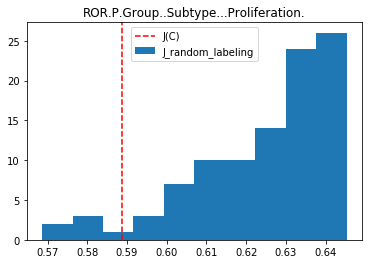

    ID_number ROR.P.Group..Subtype...Proliferation.
0   SCAN_0296                                     0
1   SCAN_0300                                     0
2   SCAN_0319                                     0
3   SCAN_0191                                     0
4   SCAN_0211                                     0
5   SCAN_0105                                     1
6   SCAN_0466                                     1
7   SCAN_0137                                     1
8   SCAN_0190                                     1
9   SCAN_0455                                     1
10  SCAN_0269                                     2
11  SCAN_0056                                     2
12  SCAN_0095                                     2
13  SCAN_0074                                     2
14  SCAN_0089                                     2
torch.Size([2, 1, 1])
J_C:  0.8822220388398159
mean hist:  0.928188406265196
0.045966367425380183


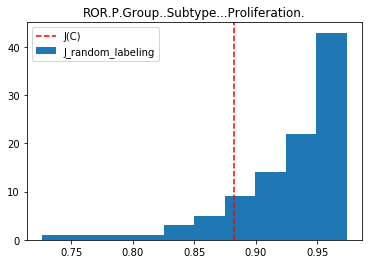

In [114]:
label = 'ROR.P.Group..Subtype...Proliferation.'
for i in range(10):
    sampled_df = get_dataset_ROR(label, i)
    print(sampled_df)
    dataset = BiopsyDataset100("/storage/Chloe/zoom_20_512", sampled_df, label, transform=transform)
    distance, mean, percentage = binning_eval(dataset, sampled_df, encoder, label)
    new_row = {'Label': label, 'Encoder': '2', 'Distance': distance, 'Mean of distribution': mean, "Percentage": percentage}
    df_results = df_results.append(new_row, ignore_index=True)

   ID_number PR status
0  SCAN_0103         0
1  SCAN_0060         0
2  SCAN_0090         0
3  SCAN_0156         0
4  SCAN_0130         0
5  SCAN_0057         1
6  SCAN_0095         1
7  SCAN_0126         1
8  SCAN_0077         1
9  SCAN_0074         1
torch.Size([2, 1, 1])
J_C:  1.0132219676623504
mean hist:  1.0077302056215547
-0.005491762040795711


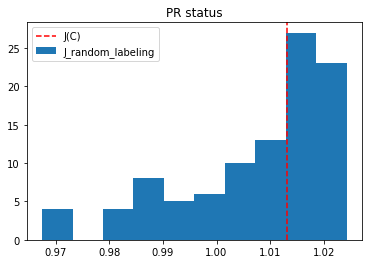

   ID_number PR status
0  SCAN_0065         0
1  SCAN_0132         0
2  SCAN_0082         0
3  SCAN_0103         0
4  SCAN_0061         0
5  SCAN_0106         1
6  SCAN_0096         1
7  SCAN_0112         1
8  SCAN_0131         1
9  SCAN_0155         1
torch.Size([2, 1, 1])
J_C:  1.0226873806579873
mean hist:  1.0022716933144005
-0.020415687343586786


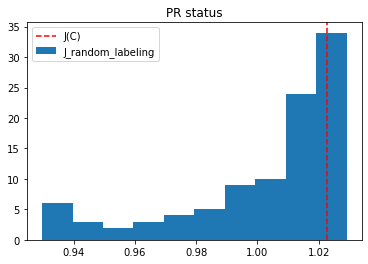

   ID_number PR status
0  SCAN_0092         0
1  SCAN_0067         0
2  SCAN_0130         0
3  SCAN_0056         0
4  SCAN_0103         0
5  SCAN_0101         1
6  SCAN_0093         1
7  SCAN_0125         1
8  SCAN_0085         1
9  SCAN_0077         1
torch.Size([2, 1, 1])
J_C:  0.9186472583640088
mean hist:  0.9031765835925537
-0.01547067477145514


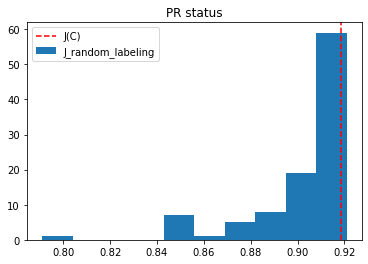

   ID_number PR status
0  SCAN_0119         0
1  SCAN_0061         0
2  SCAN_0060         0
3  SCAN_0144         0
4  SCAN_0067         0
5  SCAN_0129         1
6  SCAN_0085         1
7  SCAN_0058         1
8  SCAN_0070         1
9  SCAN_0088         1
torch.Size([2, 1, 1])
J_C:  0.9232223842833882
mean hist:  0.9294285017588512
0.006206117475462958


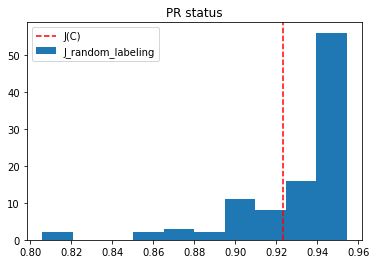

   ID_number PR status
0  SCAN_0082         0
1  SCAN_0065         0
2  SCAN_0150         0
3  SCAN_0119         0
4  SCAN_0067         0
5  SCAN_0110         1
6  SCAN_0075         1
7  SCAN_0074         1
8  SCAN_0124         1
9  SCAN_0131         1
torch.Size([2, 1, 1])
J_C:  0.9153986075813737
mean hist:  0.9468541680243172
0.03145556044294351


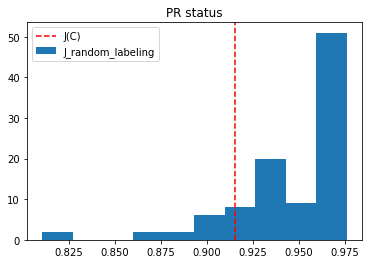

   ID_number PR status
0  SCAN_0061         0
1  SCAN_0060         0
2  SCAN_0114         0
3  SCAN_0103         0
4  SCAN_0069         0
5  SCAN_0106         1
6  SCAN_0102         1
7  SCAN_0122         1
8  SCAN_0148         1
9  SCAN_0125         1
torch.Size([2, 1, 1])
J_C:  0.9632432267246768
mean hist:  0.9729981665678956
0.009754939843218846


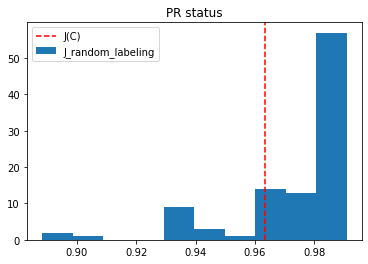

   ID_number PR status
0  SCAN_0069         0
1  SCAN_0144         0
2  SCAN_0061         0
3  SCAN_0114         0
4  SCAN_0090         0
5  SCAN_0157         1
6  SCAN_0085         1
7  SCAN_0141         1
8  SCAN_0078         1
9  SCAN_0140         1
torch.Size([2, 1, 1])
J_C:  1.1065937456879764
mean hist:  1.0743938365742658
-0.03219990911371062


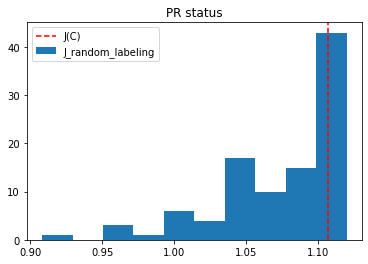

   ID_number PR status
0  SCAN_0060         0
1  SCAN_0061         0
2  SCAN_0069         0
3  SCAN_0156         0
4  SCAN_0056         0
5  SCAN_0081         1
6  SCAN_0143         1
7  SCAN_0154         1
8  SCAN_0135         1
9  SCAN_0140         1
torch.Size([2, 1, 1])
J_C:  1.0965608037542551
mean hist:  1.07415565300046
-0.022405150753795233


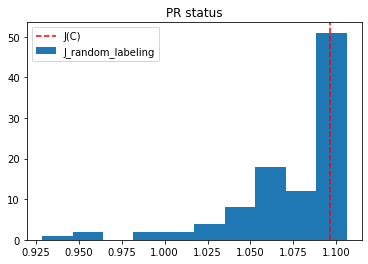

   ID_number PR status
0  SCAN_0130         0
1  SCAN_0082         0
2  SCAN_0144         0
3  SCAN_0114         0
4  SCAN_0067         0
5  SCAN_0087         1
6  SCAN_0072         1
7  SCAN_0055         1
8  SCAN_0073         1
9  SCAN_0097         1
torch.Size([2, 1, 1])
J_C:  0.9337443996705115
mean hist:  0.9110498410026124
-0.022694558667899045


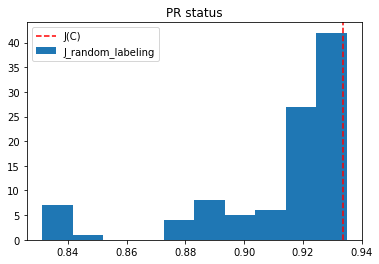

   ID_number PR status
0  SCAN_0065         0
1  SCAN_0082         0
2  SCAN_0086         0
3  SCAN_0069         0
4  SCAN_0144         0
5  SCAN_0107         1
6  SCAN_0102         1
7  SCAN_0141         1
8  SCAN_0112         1
9  SCAN_0142         1
torch.Size([2, 1, 1])
J_C:  1.0474640482626856
mean hist:  1.0410310453367118
-0.006433002925973819


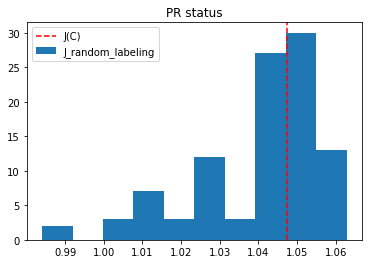

In [115]:
label = 'PR status'
for i in range(10):
    sampled_df = get_dataset_pos_neg(label, i)
    print(sampled_df)
    dataset = BiopsyDataset100("/storage/Chloe/zoom_20_512", sampled_df, label, transform=transform)
    distance, mean, percentage = binning_eval(dataset, sampled_df, encoder, label)
    new_row = {'Label': label, 'Encoder': '2', 'Distance': distance, 'Mean of distribution': mean, "Percentage": percentage}
    df_results = df_results.append(new_row, ignore_index=True)
    

   ID_number PAM50 subtype
0  SCAN_0315             A
1  SCAN_0460             A
2  SCAN_0257             A
3  SCAN_0324             A
4  SCAN_0468             A
5  SCAN_0318             B
6  SCAN_0286             B
7  SCAN_0289             B
8  SCAN_0269             B
9  SCAN_0253             B
torch.Size([2, 1, 1])
J_C:  0.7811880320254714
mean hist:  0.8643355913251337
0.08314755929966233


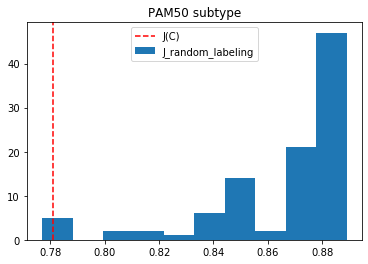

   ID_number PAM50 subtype
0  SCAN_0171             A
1  SCAN_0216             A
2  SCAN_0297             A
3  SCAN_0254             A
4  SCAN_0226             A
5  SCAN_0287             B
6  SCAN_0280             B
7  SCAN_0258             B
8  SCAN_0253             B
9  SCAN_0303             B
torch.Size([2, 1, 1])
J_C:  0.686174036168359
mean hist:  0.6675191250570128
-0.018654911111346206


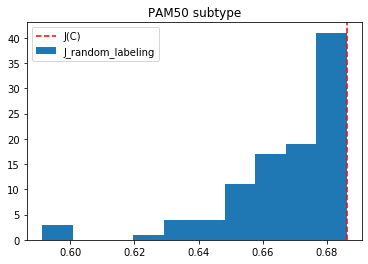

   ID_number PAM50 subtype
0  SCAN_0234             A
1  SCAN_0197             A
2  SCAN_0190             A
3  SCAN_0310             A
4  SCAN_0250             A
5  SCAN_0281             B
6  SCAN_0280             B
7  SCAN_0323             B
8  SCAN_0463             B
9  SCAN_0303             B
torch.Size([2, 1, 1])
J_C:  0.6049617706415727
mean hist:  0.6067549357990841
0.0017931651575113783


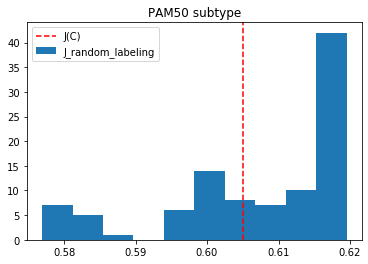

   ID_number PAM50 subtype
0  SCAN_0291             A
1  SCAN_0256             A
2  SCAN_0250             A
3  SCAN_0315             A
4  SCAN_0308             A
5  SCAN_0461             B
6  SCAN_0258             B
7  SCAN_0255             B
8  SCAN_0280             B
9  SCAN_0209             B
torch.Size([2, 1, 1])
J_C:  0.7821870943009853
mean hist:  0.7721743917391496
-0.010012702561835729


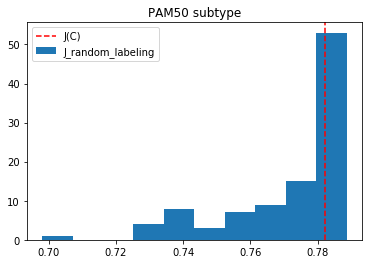

   ID_number PAM50 subtype
0  SCAN_0264             A
1  SCAN_0466             A
2  SCAN_0310             A
3  SCAN_0263             A
4  SCAN_0254             A
5  SCAN_0289             B
6  SCAN_0227             B
7  SCAN_0160             B
8  SCAN_0318             B
9  SCAN_0178             B
torch.Size([2, 1, 1])
J_C:  0.886919722721912
mean hist:  0.8837079836194974
-0.003211739102414568


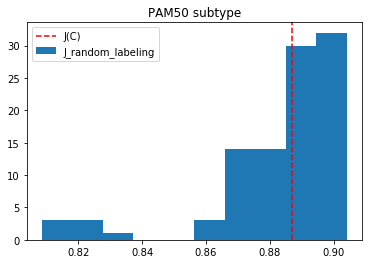

   ID_number PAM50 subtype
0  SCAN_0322             A
1  SCAN_0208             A
2  SCAN_0462             A
3  SCAN_0466             A
4  SCAN_0211             A
5  SCAN_0280             B
6  SCAN_0194             B
7  SCAN_0268             B
8  SCAN_0323             B
9  SCAN_0160             B
torch.Size([2, 1, 1])
J_C:  0.8021219357158988
mean hist:  0.7966880754852411
-0.005433860230657728


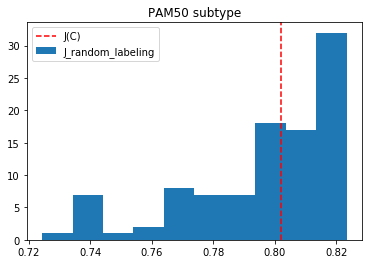

   ID_number PAM50 subtype
0  SCAN_0300             A
1  SCAN_0189             A
2  SCAN_0163             A
3  SCAN_0296             A
4  SCAN_0316             A
5  SCAN_0283             B
6  SCAN_0323             B
7  SCAN_0318             B
8  SCAN_0253             B
9  SCAN_0280             B
torch.Size([2, 1, 1])
J_C:  0.4999842102154838
mean hist:  0.5010442823263734
0.0010600721108896538


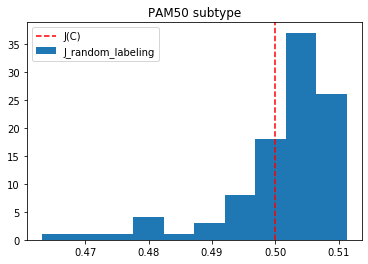

   ID_number PAM50 subtype
0  SCAN_0235             A
1  SCAN_0218             A
2  SCAN_0167             A
3  SCAN_0298             A
4  SCAN_0315             A
5  SCAN_0287             B
6  SCAN_0283             B
7  SCAN_0232             B
8  SCAN_0289             B
9  SCAN_0461             B
torch.Size([2, 1, 1])
J_C:  0.7048460611253977
mean hist:  0.6843141879378258
-0.02053187318757188


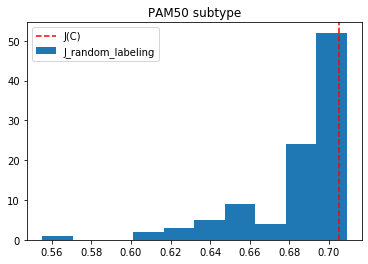

   ID_number PAM50 subtype
0  SCAN_0212             A
1  SCAN_0285             A
2  SCAN_0206             A
3  SCAN_0233             A
4  SCAN_0251             A
5  SCAN_0227             B
6  SCAN_0238             B
7  SCAN_0283             B
8  SCAN_0253             B
9  SCAN_0281             B
torch.Size([2, 1, 1])
J_C:  0.6146439494881779
mean hist:  0.6176383917329763
0.00299444224479839


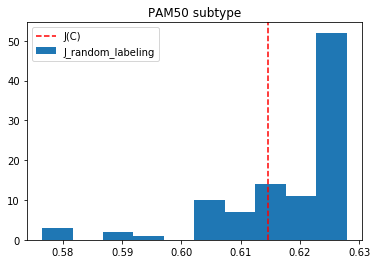

   ID_number PAM50 subtype
0  SCAN_0158             A
1  SCAN_0179             A
2  SCAN_0177             A
3  SCAN_0183             A
4  SCAN_0297             A
5  SCAN_0252             B
6  SCAN_0178             B
7  SCAN_0286             B
8  SCAN_0280             B
9  SCAN_0283             B
torch.Size([2, 1, 1])
J_C:  0.6359318994097412
mean hist:  0.6417282927026366
0.005796393292895496


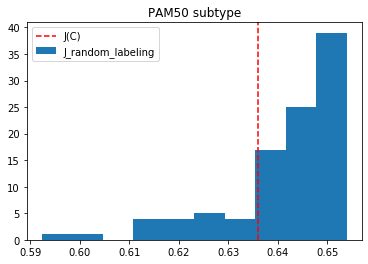

In [116]:
label = 'PAM50 subtype'
for i in range(10):
    sampled_df = get_dataset_PAM50(label, i)
    print(sampled_df)
    dataset = BiopsyDataset100("/storage/Chloe/zoom_20_512", sampled_df, label, transform=transform)
    distance, mean, percentage = binning_eval(dataset, sampled_df, encoder, label)
    new_row = {'Label': label, 'Encoder': '2', 'Distance': distance, 'Mean of distribution': mean, "Percentage": percentage}
    df_results = df_results.append(new_row, ignore_index=True)
    

In [117]:
df_results

,Label,Encoder,Distance,Mean of distribution,Percentage
0,Ki67 (%),No encoder,0.248609,206.088552,63.0
1,Ki67 (%),No encoder,12.491632,203.237264,97.0
2,Ki67 (%),No encoder,-0.270534,206.013481,54.0
3,Ki67 (%),No encoder,11.781205,201.536183,95.0
4,Ki67 (%),No encoder,13.686516,200.189516,100.0
...,...,...,...,...,...
535,PAM50 subtype,2,-0.005434,0.796688,53.0
536,PAM50 subtype,2,0.001060,0.501044,68.0
537,PAM50 subtype,2,-0.020532,0.684314,18.0
538,PAM50 subtype,2,0.002994,0.617638,71.0


In [118]:
df_results.to_csv('df_results_whole_image.csv', index=False)

In [2]:
df_results = pd.read_csv('df_results_whole_image.csv')

In [3]:
color_dict = {'FOXA1': '#7B2CBF', 'HIF1A': '#9D4EDD', 'Ki67 (%)': '#240046', 'MYC': '#5A189A', 'PAM50 subtype': '#72EFDD', 'PR status': '#64DFDF','ROR.P.Group..Subtype...Proliferation.': '#E0AAFF','ROR.S.Group..Subtype.Only.': '#C77DFF', 'TILS (%)': '#3C096C'}



In [4]:
import seaborn as sns

TypeError: move_legend() missing 1 required positional argument: 'obj'

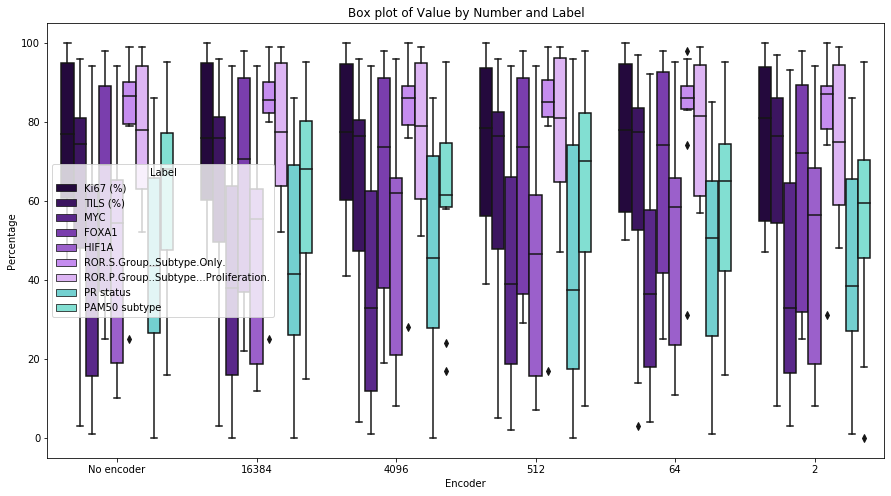

In [6]:
# Creating the box plot
plt.figure(figsize=(15, 8))
sns.boxplot(data=df_results, x="Encoder", y="Percentage", hue="Label", palette=color_dict)
# plt.axhline(0, color='red', linestyle='--')  # Add line for y=0
plt.title("Box plot of Value by Number and Label")
sns.move_legend(loc='upper right', frameon=True, facecolor='white', edgecolor='black')

plt.show()

<Figure size 1440x864 with 0 Axes>

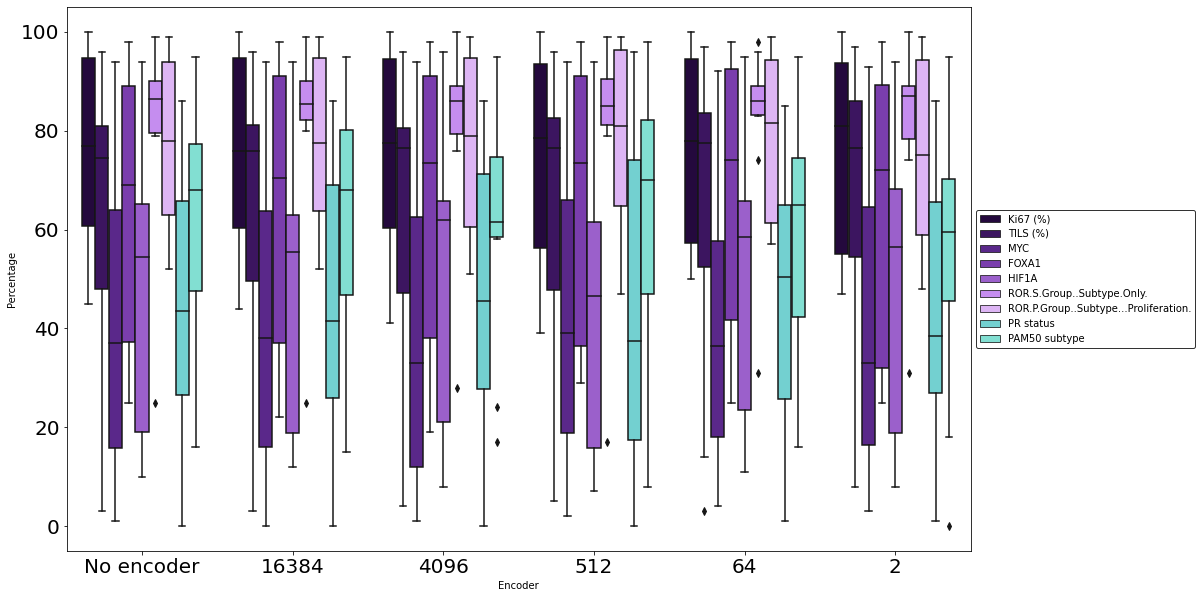

In [7]:
plt.figure(figsize=(20, 12))
fig, ax = plt.subplots(figsize=(18, 10))

sns.boxplot(data=df_results, x="Encoder", y="Percentage", hue="Label", palette=color_dict)

# Adding the legend with extra space
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.9, box.height])  # resize the plot area


plt.xticks(fontsize=20)  # Increase x-axis tick font size
plt.yticks(fontsize=20)


# Customizing the legend
legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=True)
frame = legend.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('black')
# plt.savefig("Fig. 1.png", bbox_inches='tight')
plt.show();

<Figure size 1440x864 with 0 Axes>

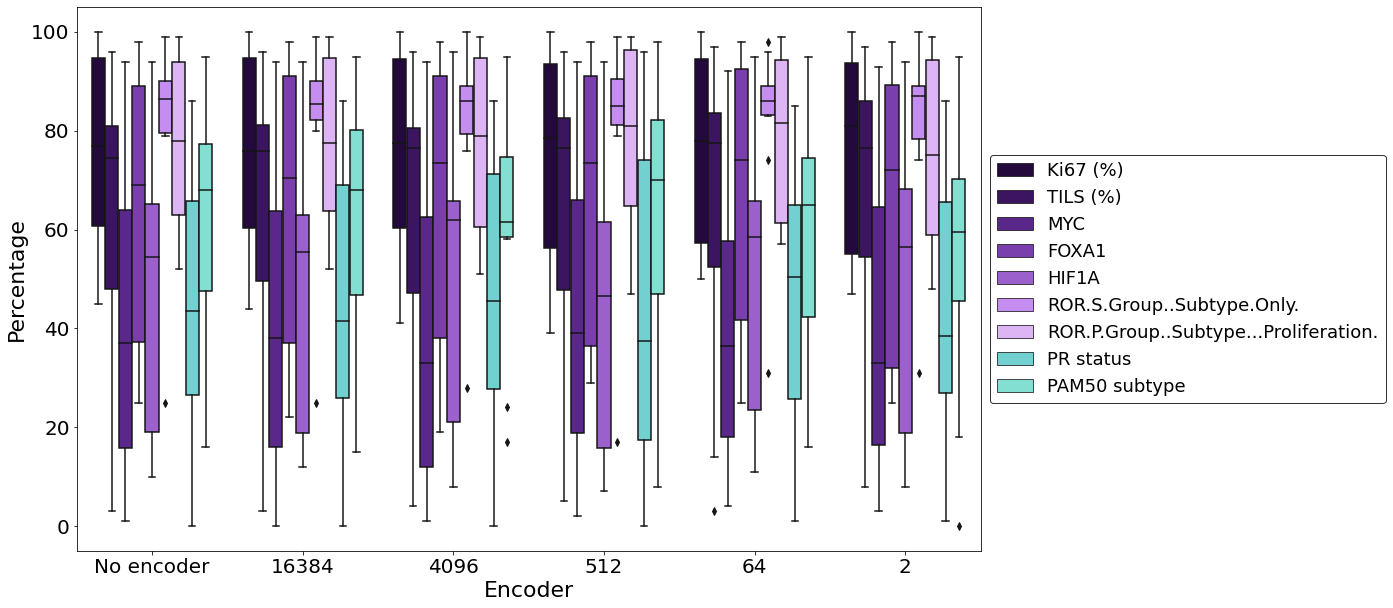

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create the figure and axes
plt.figure(figsize=(20, 12))
fig, ax = plt.subplots(figsize=(18, 10))

# Plot the boxplot
sns.boxplot(data=df_results, x="Encoder", y="Percentage", hue="Label", palette=color_dict, ax=ax)

# Resize the plot area to fit the legend better
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.9, box.height])  # Resize plot area

# Increase the font size of x and y axis ticks
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# Set x-axis and y-axis labels with larger font size
ax.set_xlabel("Encoder", fontsize=22)
ax.set_ylabel("Percentage", fontsize=22)

# Customize the legend with larger font size
legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=True, fontsize=18)  # Adjust legend font size

# Customize legend frame appearance
frame = legend.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('black')

# Show the plot
plt.savefig("Updated Fig 9.png", bbox_inches='tight')
plt.show()


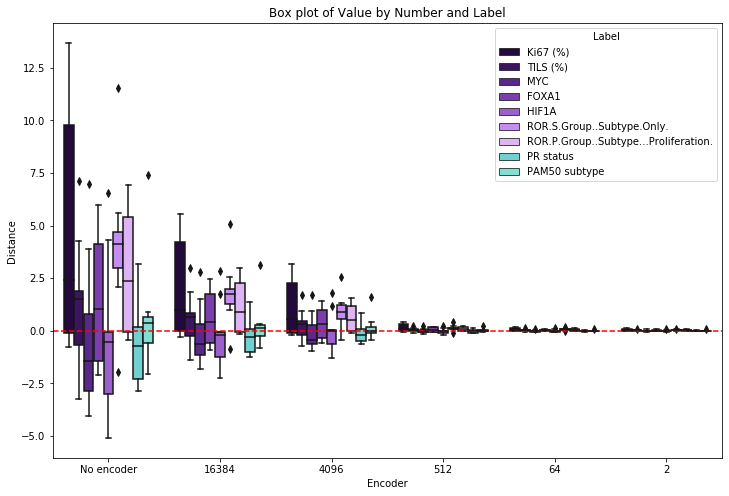

In [122]:
# Creating the box plot
plt.figure(figsize=(12, 8))
sns.boxplot(data=df_results, x="Encoder", y="Distance", hue="Label", palette=color_dict)
plt.axhline(0, color='red', linestyle='--')  # Add line for y=0
plt.title("Box plot of Value by Number and Label")
plt.show()